In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dt

import plotly.express as px
import pycountry
import pycountry_convert as pc

import geopandas as gpd
import json

import plotly.graph_objects as go

import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from scipy.stats import binom
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa

from sklearn.model_selection import TimeSeriesSplit

import datetime
from sklearn.experimental.enable_hist_gradient_boosting import *
from sklearn.ensemble import *
from sklearn.utils import *
from sklearn.preprocessing import *
from sklearn.dummy import * 
from sklearn.metrics import *
from sklearn.ensemble import *
from sklearn.neural_network import * 
from sklearn.tree import * 
from sklearn.ensemble import *
from sklearn.compose import *
from sklearn.linear_model import *
import seaborn as sns
from catboost import *
from lightgbm import * 
from xgboost import *

# import the regression module
import jinja2
from pycaret.regression import *# initialize setup

from sklearn.linear_model import PoissonRegressor, BayesianRidge, TweedieRegressor, TheilSenRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression, GammaRegressor, SGDRegressor, ARDRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVC, SVR

from sklearn.model_selection import train_test_split

/Users/faithudoeyo/anaconda3/envs/maternal_mortality/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
df_average = pd.read_pickle("df_average.pkl")

In [3]:
def iso_to_continent(x):
    # iso alpha 3 to alpha 2
    country_alpha2 = pycountry.countries.get(alpha_3=x).alpha_2
    
    # alpha 2 to continent
    try:
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    except:
        country_continent_code = ''
        
    try:
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    except:
        country_continent_name = ''
    return country_continent_name

In [4]:
def iso_to_countryname(x):
    try:
        country_name = pycountry.countries.get(alpha_3=x).name
    except:
        country_name = ''
    
    return country_name

In [5]:
def excess_category(x):
    if (x <= 0):
        return '0. No Excess Deaths'
    elif (0 < x) &  (x < 100):
        return '1. 0 to <100'    
    elif (100 <= x) &  (x < 300):
        return '2. 100 to <300'
    elif (300 <= x) & (x < 700):
        return '3. 300 to <700'
    elif (700 <= x) & (x < 1000):
        return '4. 700 to <1,000'
    elif (x >= 1000):
        return '5. Greater than 1,000'
    return 'not_applicable'

In [6]:
def test_train(df, value_col):
    #*# Train/Test Split
    train, test= np.split(df, [int(.98 * len(df))])

    #*# defining X and y for model training
    X_train = train['year_mid'].values.reshape(-1, 1)
    y_train = train[value_col]

    #*# defining X and y for model test
    X_test = test['year_mid'].values.reshape(-1, 1)
    y_test = test[value_col]
    
    return X_train, y_train, X_test, y_test

In [7]:
def model_test_metrics(y_test, y_pred_test):
    # Metrics for testing
    r2_test = r2_score(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=True)
    return r2_test, mse_test, mae_test, rmse_test

In [8]:
def model_train_metrics(y_train, y_pred_train):
    # Metrics for training
    r2_train = r2_score(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=True)
    return r2_train, mse_train, mae_train, rmse_train

In [9]:
def poisson_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    # Set lower and upper quantile
#     LOWER_ALPHA = 0.1
#     UPPER_ALPHA = 0.9

    # Each model has to be separate
#     lower_model = PoissonRegressor(alpha=LOWER_ALPHA)
#     upper_model = PoissonRegressor(alpha=UPPER_ALPHA)

    # The mid model will use the default loss
    mid_model = PoissonRegressor()

#     lower_model.fit(X_train, y_train)
    model_fit = mid_model.fit(X_train, y_train)
#     upper_model.fit(X_train, y_train)
    
    # Record actual values on test set
    predictions = pd.DataFrame(y_train)
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan

    # Predict
#     predictions['lower'] = lower_model.predict(X_train)
    predictions['mid'] = model_fit.predict(X_train)
#     y_pred_test = mid_model.predict(X_test)
#     predictions['upper'] = upper_model.predict(X_train)
    y_pred_train = model_fit.predict(X_train)
    
    model_name = "POISSON"
    
    return model_name, model_fit, predictions, y_pred_train

In [10]:
def xgb_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    pipeline = Pipeline([('model', XGBRegressor(objective = "count:poisson"))]) 
    
    # Predict
    model_fit = pipeline.fit(X_train, y_train)
#     y_pred_test = pipeline.predict(X_test)
    y_pred_train = model_fit.predict(X_train)

    predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_train], value_col: y_train}).reset_index()
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan
    
    model_name = "XGBOOST"
    
    return model_name, model_fit, predictions, y_pred_train

In [11]:
def quantile_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    pipeline = Pipeline([('model', QuantileRegressor())]) 
    
    # Predict
    model_fit = pipeline.fit(X_train, y_train)
#     y_pred_test = pipeline.predict(X_test)
    y_pred_train = model_fit.predict(X_train)

    predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_train], value_col: y_train}).reset_index()
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan
    
    model_name = "Quantile"
    
    return model_name, model_fit, predictions, y_pred_train

In [12]:
def theil_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    pipeline = Pipeline([('model', TheilSenRegressor())]) 
    
    # Predict
    model_fit = pipeline.fit(X_train, y_train)
#     y_pred_test = pipeline.predict(X_test)
    y_pred_train = model_fit.predict(X_train)

    predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_train], value_col: y_train}).reset_index()
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan
    
    model_name = "Theil"
    
    return model_name, model_fit, predictions, y_pred_train

In [13]:
def tweedie_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    pipeline = Pipeline([('model', TweedieRegressor())]) 
    
    # Predict
    model_fit = pipeline.fit(X_train, y_train)
#     y_pred_test = pipeline.predict(X_test)
    y_pred_train = model_fit.predict(X_train)

    predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_train], value_col: y_train}).reset_index()
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan
    
    model_name = "Tweedie"
    
    return model_name, model_fit, predictions, y_pred_train

In [14]:
def huber_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    pipeline = Pipeline([('model', HuberRegressor())]) 
    
    # Predict
    model_fit = pipeline.fit(X_train, y_train)
#     y_pred_test = pipeline.predict(X_test)
    y_pred_train = model_fit.predict(X_train)

    predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_train], value_col: y_train}).reset_index()
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan
    
    model_name = "Huber"
    
    return model_name, model_fit, predictions, y_pred_train

In [15]:
def sgd_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    pipeline = Pipeline([('model', SGDRegressor())]) 
    
    # Predict
    model_fit = pipeline.fit(X_train, y_train)
#     y_pred_test = pipeline.predict(X_test)
    y_pred_train = model_fit.predict(X_train)

    predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_train], value_col: y_train}).reset_index()
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan
    
    model_name = "SGD"
    
    return model_name, model_fit, predictions, y_pred_train

In [16]:
def bayesian_ard_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    pipeline = Pipeline([('model', ARDRegression())]) 
    
    # Predict
    model_fit = pipeline.fit(X_train, y_train)
#     y_pred_test = pipeline.predict(X_test)
    y_pred_train = model_fit.predict(X_train)

    predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_train], value_col: y_train}).reset_index()
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan
    
    model_name = "Bayesian_ARD"
    
    return model_name, model_fit, predictions, y_pred_train

In [17]:
def bayesian_ridge_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    pipeline = Pipeline([('model', BayesianRidge())]) 
    
    # Predict
    model_fit = pipeline.fit(X_train, y_train)
#     y_pred_test = pipeline.predict(X_test)
    y_pred_train = model_fit.predict(X_train)

    predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_train], value_col: y_train}).reset_index()
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan
    
    model_name = "Bayesian_ridge"
    
    return model_name, model_fit, predictions, y_pred_train

In [18]:
def histgradient_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    pipeline = Pipeline([('model', HistGradientBoostingRegressor(loss = "poisson"))])

    # Predict
    model_fit = pipeline.fit(X_train, y_train)
#     y_pred_test = pipeline.predict(X_test)
    y_pred_train = model_fit.predict(X_train)

    predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_train], value_col: y_train}).reset_index()
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan
    
    model_name = "HistoGradient"
    
    return model_name, model_fit, predictions, y_pred_train

In [19]:
def gamma_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    pipeline = Pipeline([('model', GammaRegressor())])

    # Predict
    model_fit = pipeline.fit(X_train, y_train)
#     y_pred_test = pipeline.predict(X_test)
    y_pred_train = model_fit.predict(X_train)

    predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_train], value_col: y_train}).reset_index()
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan
    
    model_name = "Gamma"
    
    return model_name, model_fit, predictions, y_pred_train

In [20]:
def svr_rbf_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    pipeline = Pipeline([('model', SVR(kernel='rbf'))]) #use

    # Predict
    model_fit = pipeline.fit(X_train, y_train)
#     y_pred_test = pipeline.predict(X_test)
    y_pred_train = model_fit.predict(X_train)

    predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_train], value_col: y_train}).reset_index()
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan
    
    model_name = "SVR_RBF"
    
    return model_name, model_fit, predictions, y_pred_train

In [21]:
def svr_poly_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    pipeline = Pipeline([('model', SVR(kernel='poly'))]) #use

    # Predict
    model_fit = pipeline.fit(X_train, y_train)
#     y_pred_test = pipeline.predict(X_test)
    y_pred_train = model_fit.predict(X_train)

    predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_train], value_col: y_train}).reset_index()
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan
    
    model_name = "SVR_RBF"
    
    return model_name, model_fit, predictions, y_pred_train

In [22]:
def svr_linear_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    pipeline = Pipeline([('model', SVR(kernel='linear'))]) #use
    
    # Predict
    model_fit = pipeline.fit(X_train, y_train)
#     y_pred_test = pipeline.predict(X_test)
    y_pred_train = model_fit.predict(X_train)

    predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_train], value_col: y_train}).reset_index()
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan
    
    model_name = "SVR_Linear"
    
    return model_name, model_fit, predictions, y_pred_train

In [23]:
def lgbm_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    pipeline = Pipeline([('model', LGBMRegressor(objective = "poisson"))])

    # Predict
    model_fit = pipeline.fit(X_train, y_train)
#     y_pred_test = pipeline.predict(X_test)
    y_pred_train = model_fit.predict(X_train)

    predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_train], value_col: y_train}).reset_index()
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan
    
    model_name = "LGBM"
    
    return model_name, model_fit, predictions, y_pred_train

In [24]:
def catboost_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    pipeline = Pipeline([('model', CatBoostRegressor(objective = "Poisson"))])

    # Predict
    model_fit = pipeline.fit(X_train, y_train)
#     y_pred_test = pipeline.predict(X_test)
    y_pred_train = model_fit.predict(X_train)

    predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_train], value_col: y_train}).reset_index()
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan
    
    model_name = "Catboost"
    
    return model_name, model_fit, predictions, y_pred_train

In [25]:
def randomforest_regression(X_train, y_train, value_col):
    
    #*# Run pipeline
    pipeline = Pipeline([('model', RandomForestRegressor(n_estimators=100, max_depth=2, random_state=42, bootstrap=True, max_samples=0.1))])

    # Predict
    model_fit = pipeline.fit(X_train, y_train)
#     y_pred_test = pipeline.predict(X_test)
    y_pred_train = model_fit.predict(X_train)

    predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_train], value_col: y_train}).reset_index()
    predictions["Year"] = X_train
    predictions['lower'] = np.nan
    predictions['upper'] = np.nan
    
    model_name = "RandomForest"
    
    return model_name, model_fit, predictions, y_pred_train

In [26]:
def run_model(df, models, value_col="value_col"):

    combined_data_values = []
    
    for x in df["iso_alpha_3_code"].unique().tolist():

        #*# Subset data
        sample_df = df[(df['iso_alpha_3_code']==x)].copy()
        
        sample_df[["year_mid", "0.5"]].set_index("year_mid").plot()
        plt.show()

        #*# Train/Test Split
        X_train, y_train, X_test, y_test = test_train(sample_df, value_col)

        #*# Identify best model
        best_score, best_model, best_model_name, best_r2_train, best_mse_train, best_mae_train, best_rmse_train = float("inf"), None, "", float("inf"), float("inf"), float("inf"), float("inf")
        
        for func in models:
            try:
                model_name, model_fit, predictions_train, y_pred_train = func(X_train, y_train, value_col)

#                 r2_test, mse_test, mae_test, rmse_test = model_test_metrics(y_test, y_pred_test)
                r2_train, mse_train, mae_train, rmse_train = model_train_metrics(y_train, y_pred_train)
                
                if (rmse_train > 0) & (rmse_train < best_score) & (r2_train > 0):
                    best_score, best_model, best_model_name, best_r2_train, best_mse_train, best_mae_train, best_rmse_train = rmse_train, model_fit, model_name, r2_train, mse_train, mae_train, rmse_train
                    print('Country: %s RMSE=%.3f R2=%.3f Model=%s' % (x,rmse_train,r2_train,func.__name__))
            except:
                pass
   
        #*# Predict 2020 values
        print('Best RMSE=%.3f Model=%s' % (best_score, best_model))
        y_pred_test = model_fit.predict(X_test)
        r2_test, mse_test, mae_test, rmse_test = model_test_metrics(y_test, y_pred_test)
        predictions = pd.DataFrame({'mid': [round(y, 0) for y in y_pred_test], value_col: y_test}).reset_index()
        
        #*# Add additional data insights
        predictions["iso_code"] = x
        predictions['model_type'] = best_model_name
        predictions["R2"] = r2_test
        predictions["MAE"] = mae_test
        predictions["MSE"] = mse_test
        predictions["RMSE"] = rmse_test
        predictions["R2_train"] = best_r2_train
        predictions["MAE_train"] = best_mae_train
        predictions["MSE_train"] = best_mse_train
        predictions["RMSE_train"] = best_rmse_train
        predictions["Year"] = X_test
        predictions['lower'] = np.nan
        predictions['upper'] = np.nan
        
        #*# Combine data values
        combined_data_values.append(predictions)
        
    return combined_data_values

# Train and Test Models

##  Normal Values

In [27]:
models = [poisson_regression, gamma_regression, huber_regression, bayesian_ard_regression, bayesian_ridge_regression, QuantileRegressor, TheilSenRegressor]

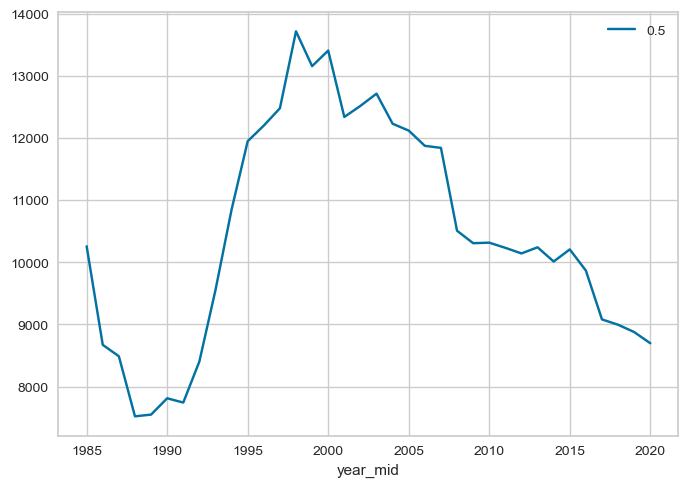

Country: AFG RMSE=3132333.713 R2=0.000 Model=gamma_regression
Country: AFG RMSE=3107070.337 R2=0.008 Model=huber_regression
Best RMSE=3107070.337 Model=Pipeline(steps=[('model', HuberRegressor())])


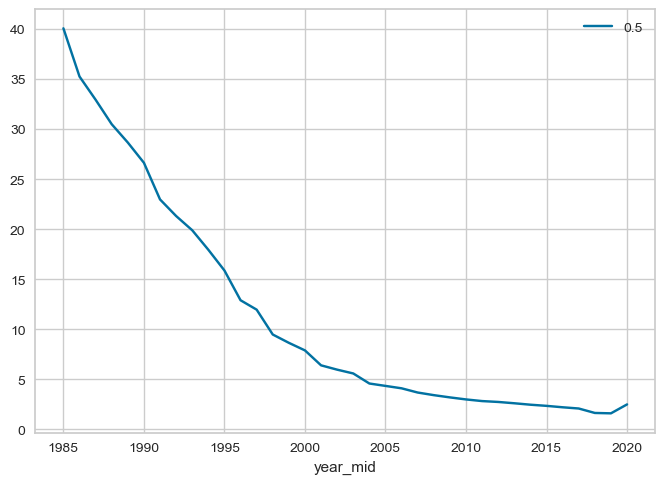

Country: ALB RMSE=1.161 R2=0.991 Model=poisson_regression
Best RMSE=1.161 Model=PoissonRegressor()


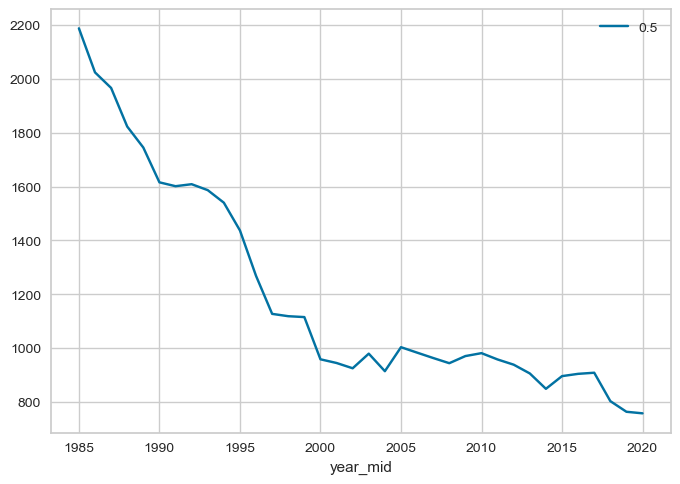

Country: DZA RMSE=17510.679 R2=0.886 Model=poisson_regression
Best RMSE=17510.679 Model=PoissonRegressor()


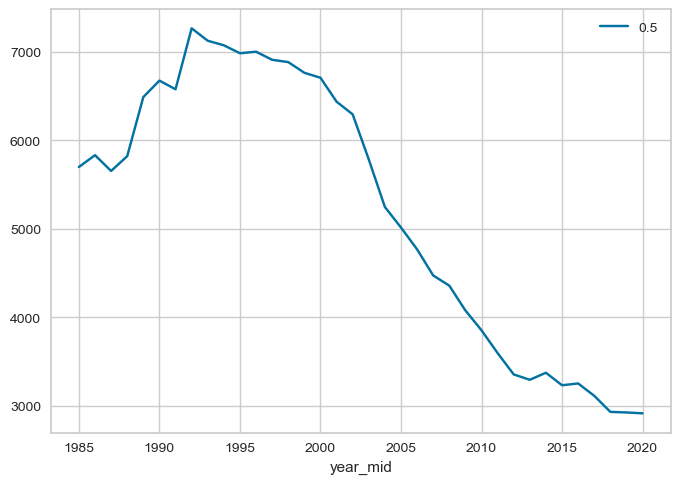

Country: AGO RMSE=811532.167 R2=0.636 Model=poisson_regression
Country: AGO RMSE=683273.307 R2=0.694 Model=huber_regression
Country: AGO RMSE=623513.930 R2=0.720 Model=bayesian_ard_regression
Best RMSE=623513.930 Model=Pipeline(steps=[('model', ARDRegression())])


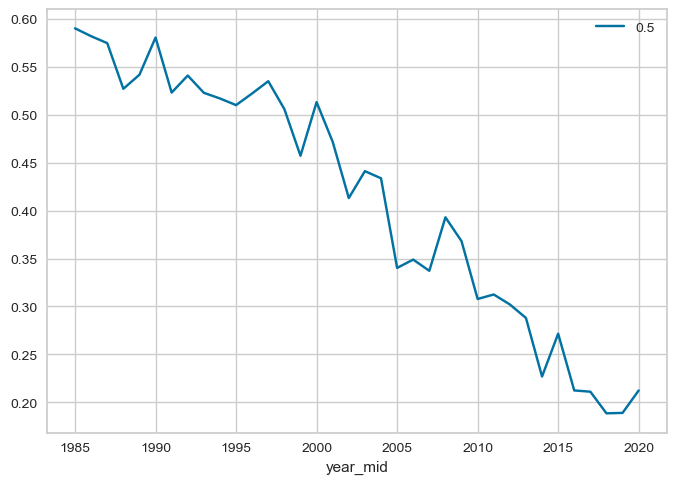

Country: ATG RMSE=0.101 R2=0.590 Model=poisson_regression
Country: ATG RMSE=0.067 R2=0.725 Model=bayesian_ard_regression
Best RMSE=0.067 Model=Pipeline(steps=[('model', ARDRegression())])


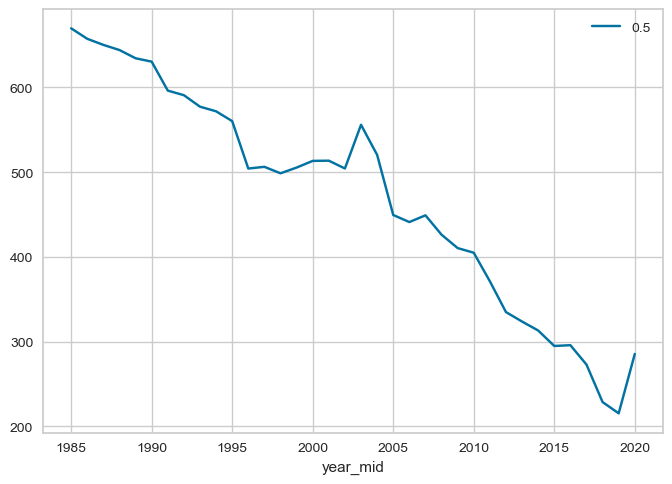

Country: ARG RMSE=1529.915 R2=0.907 Model=poisson_regression
Country: ARG RMSE=859.894 R2=0.948 Model=huber_regression
Country: ARG RMSE=850.943 R2=0.948 Model=bayesian_ard_regression
Best RMSE=850.943 Model=Pipeline(steps=[('model', ARDRegression())])


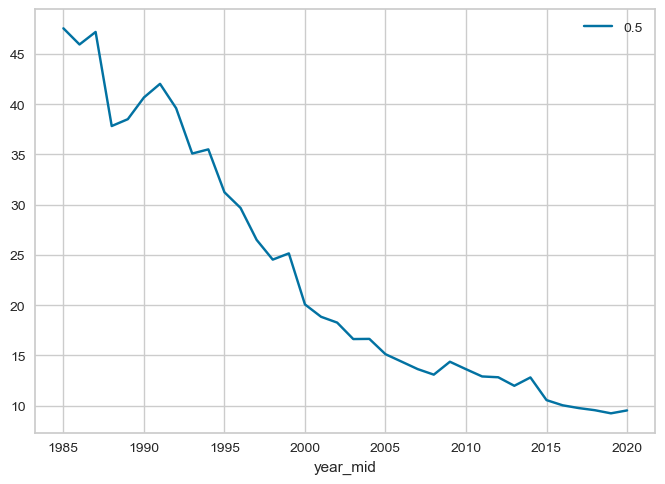

Country: ARM RMSE=5.215 R2=0.967 Model=poisson_regression
Best RMSE=5.215 Model=PoissonRegressor()


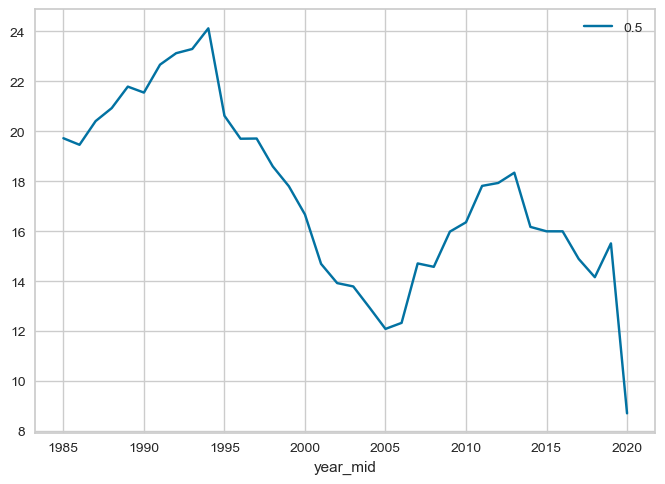

Country: AUS RMSE=5.624 R2=0.486 Model=poisson_regression
Best RMSE=5.624 Model=PoissonRegressor()


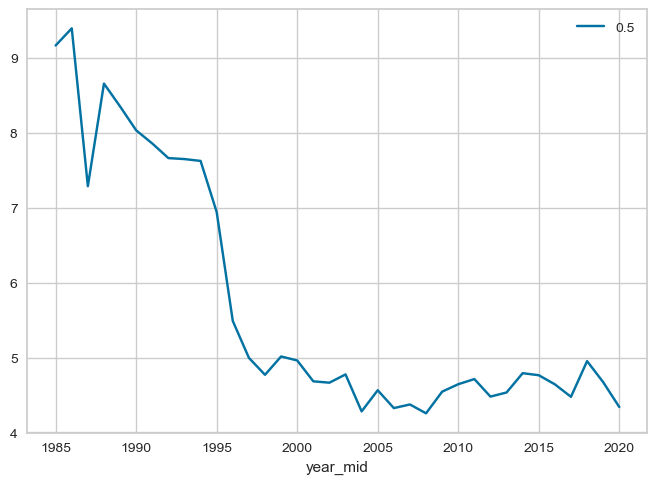

Country: AUT RMSE=0.789 R2=0.705 Model=poisson_regression
Best RMSE=0.789 Model=PoissonRegressor()


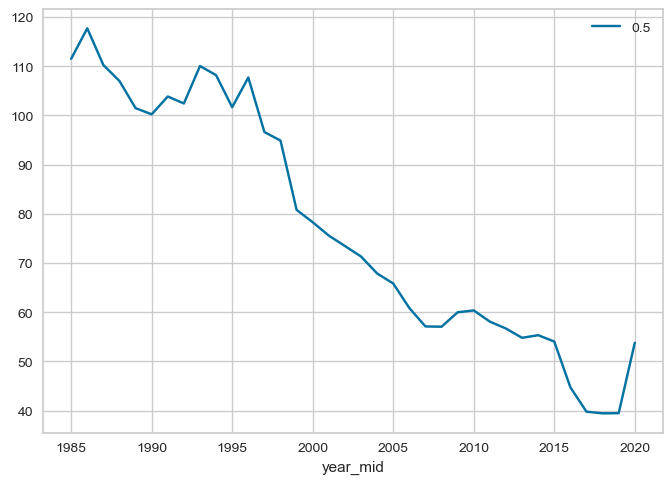

Country: AZE RMSE=49.855 R2=0.917 Model=poisson_regression
Country: AZE RMSE=36.690 R2=0.939 Model=bayesian_ard_regression
Best RMSE=36.690 Model=Pipeline(steps=[('model', ARDRegression())])


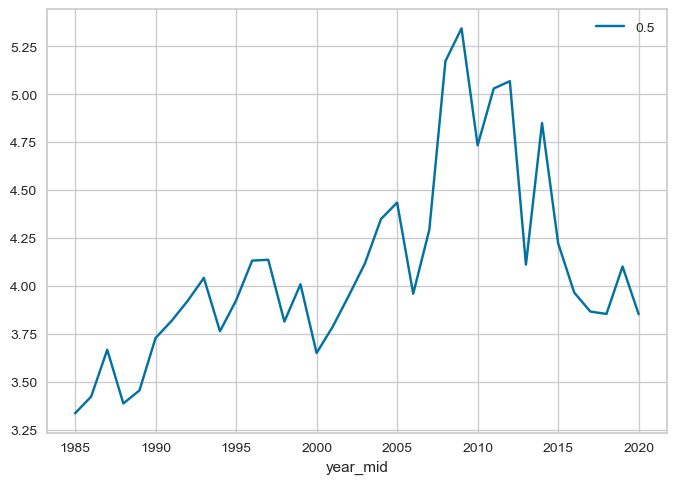

Country: BHS RMSE=0.187 R2=0.337 Model=gamma_regression
Country: BHS RMSE=0.182 R2=0.354 Model=bayesian_ard_regression
Best RMSE=0.182 Model=Pipeline(steps=[('model', ARDRegression())])


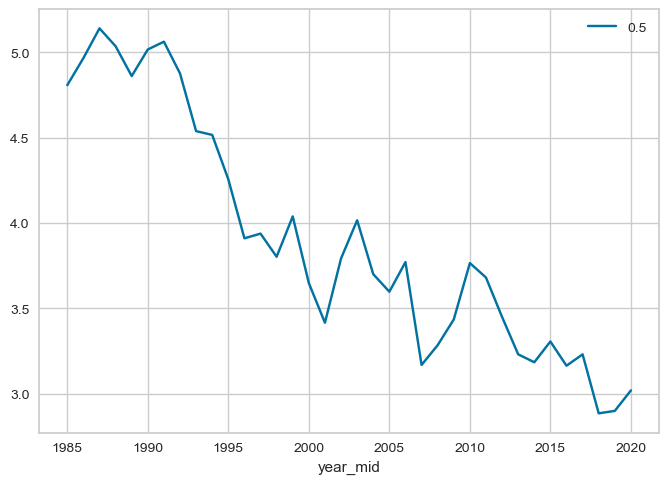

Country: BHR RMSE=0.120 R2=0.808 Model=poisson_regression
Best RMSE=0.120 Model=PoissonRegressor()


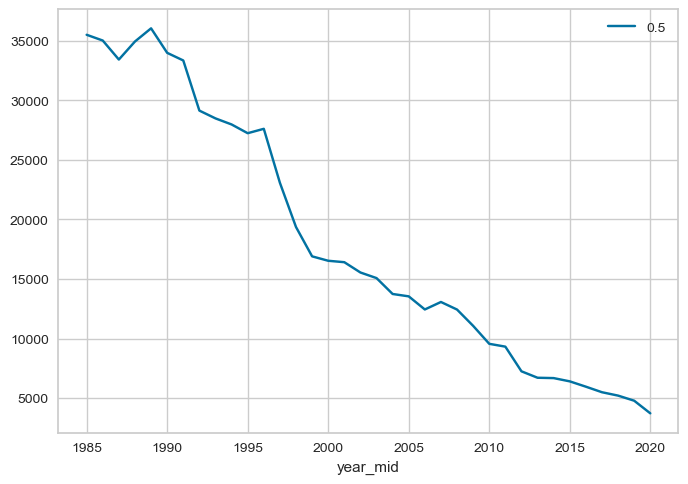

Country: BGD RMSE=5716041.390 R2=0.949 Model=poisson_regression
Country: BGD RMSE=5220161.403 R2=0.954 Model=bayesian_ard_regression
Country: BGD RMSE=5220161.403 R2=0.954 Model=bayesian_ridge_regression
Best RMSE=5220161.403 Model=Pipeline(steps=[('model', BayesianRidge())])


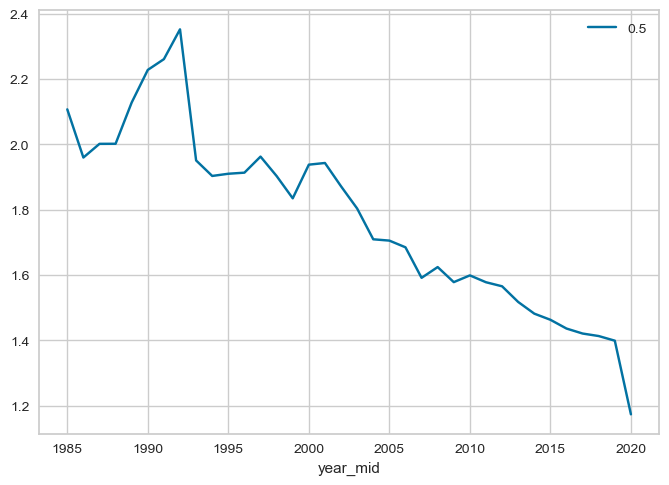

Country: BRB RMSE=0.088 R2=0.383 Model=poisson_regression
Country: BRB RMSE=0.082 R2=0.426 Model=bayesian_ard_regression
Best RMSE=0.082 Model=Pipeline(steps=[('model', ARDRegression())])


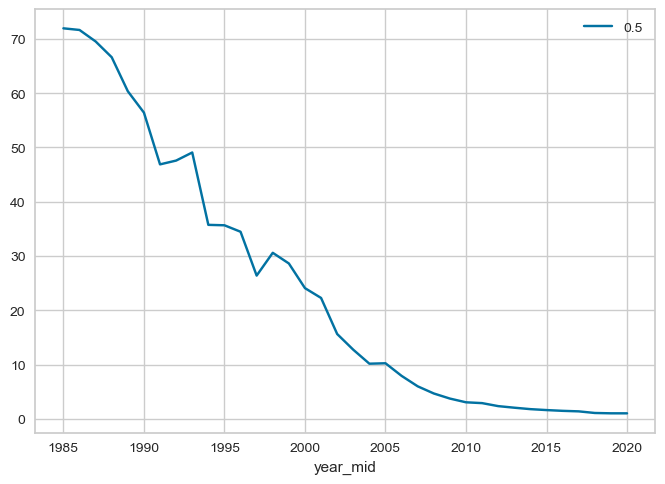

Country: BLR RMSE=32.597 R2=0.943 Model=poisson_regression
Best RMSE=32.597 Model=PoissonRegressor()


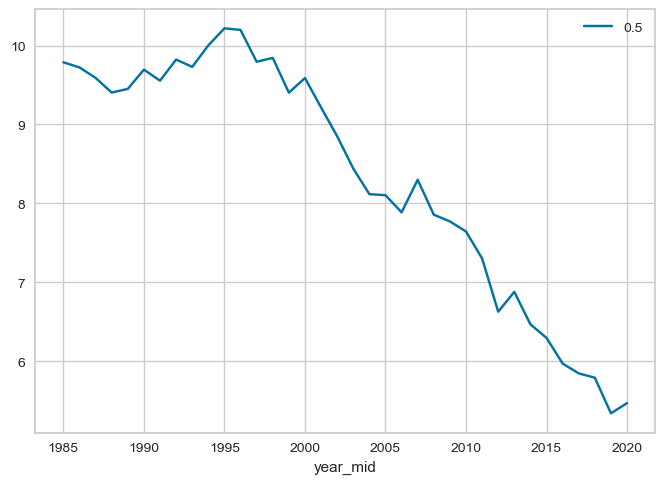

Country: BEL RMSE=0.499 R2=0.788 Model=poisson_regression
Country: BEL RMSE=0.396 R2=0.832 Model=huber_regression
Country: BEL RMSE=0.390 R2=0.835 Model=bayesian_ard_regression
Best RMSE=0.390 Model=Pipeline(steps=[('model', ARDRegression())])


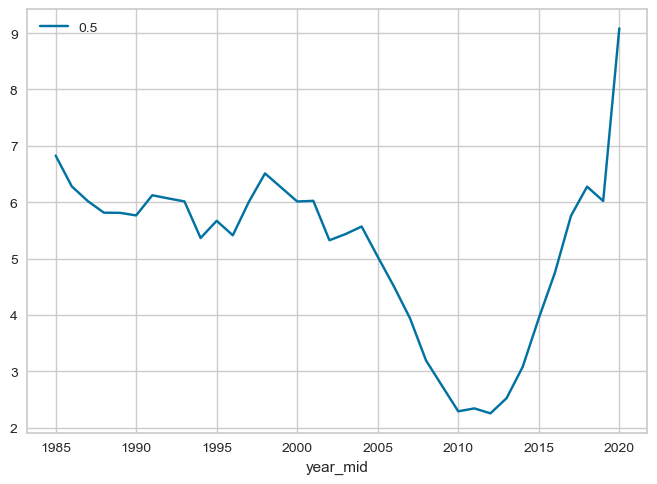

Country: BLZ RMSE=1.339 R2=0.329 Model=poisson_regression
Best RMSE=1.339 Model=PoissonRegressor()


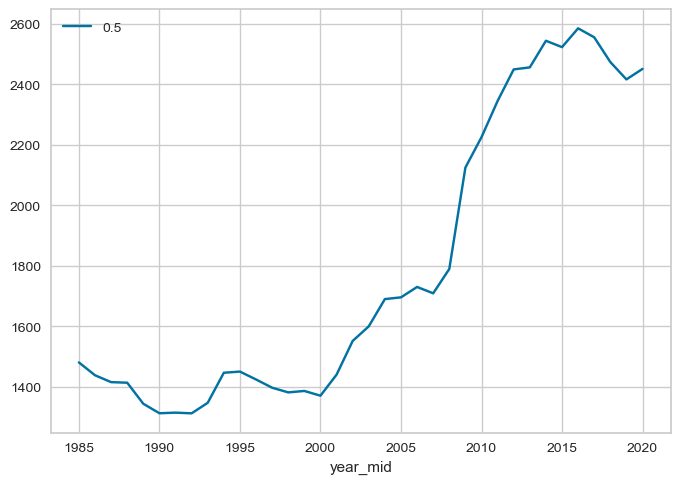

Country: BEN RMSE=32907.728 R2=0.847 Model=gamma_regression
Best RMSE=32907.728 Model=Pipeline(steps=[('model', GammaRegressor())])


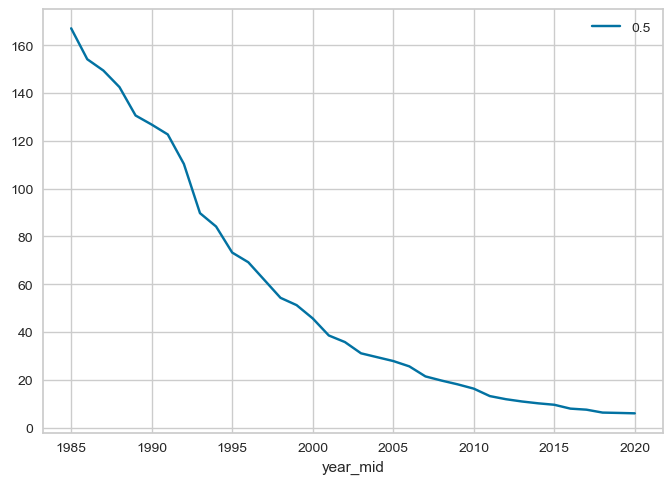

Country: BTN RMSE=44.816 R2=0.982 Model=poisson_regression
Best RMSE=44.816 Model=PoissonRegressor()


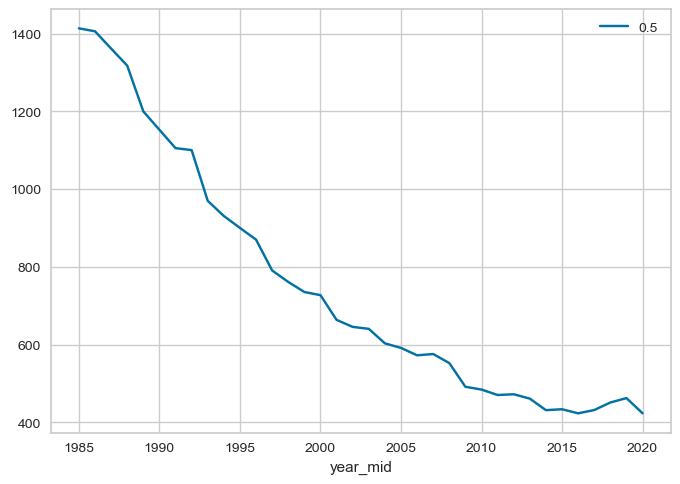

Country: BOL RMSE=2200.256 R2=0.978 Model=poisson_regression
Best RMSE=2200.256 Model=PoissonRegressor()


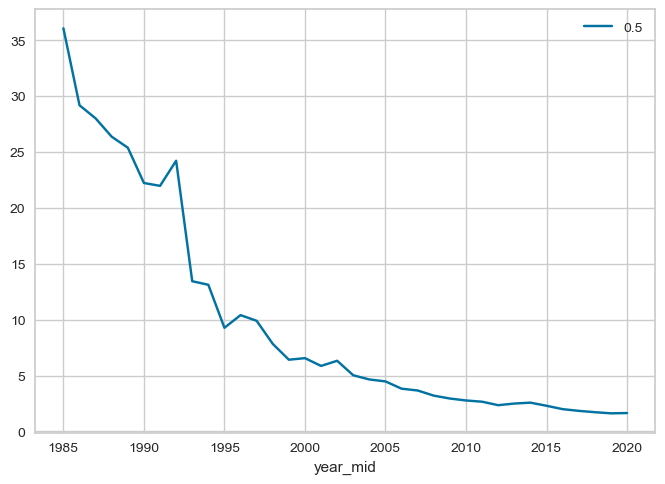

Country: BIH RMSE=3.050 R2=0.967 Model=poisson_regression
Best RMSE=3.050 Model=PoissonRegressor()


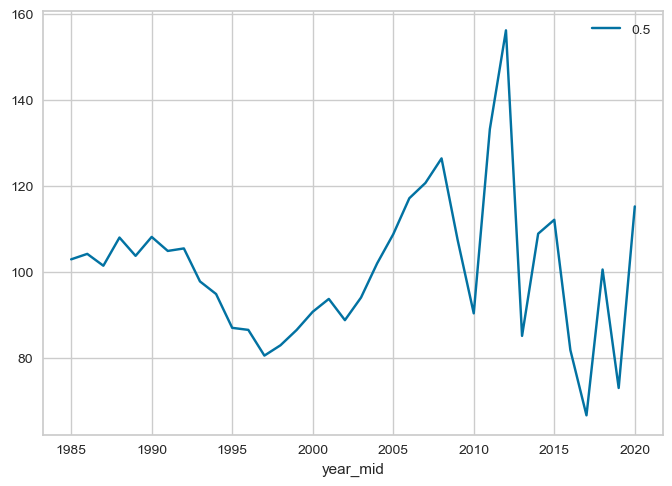

Country: BWA RMSE=289.497 R2=0.000 Model=gamma_regression
Country: BWA RMSE=289.497 R2=0.000 Model=bayesian_ard_regression
Best RMSE=289.497 Model=Pipeline(steps=[('model', ARDRegression())])


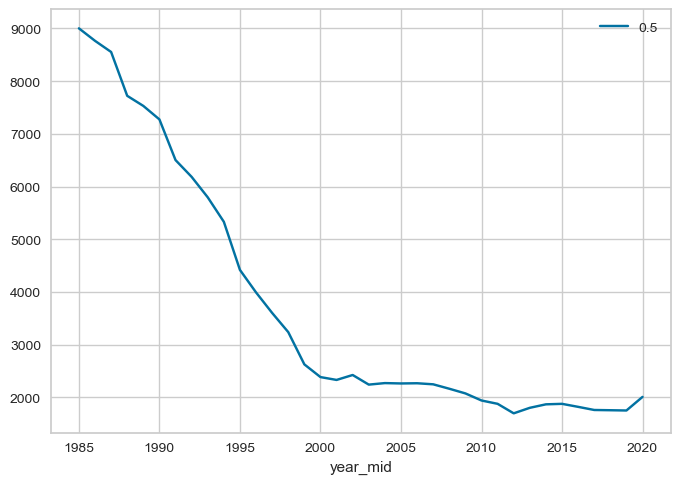

Country: BRA RMSE=304809.145 R2=0.947 Model=poisson_regression
Best RMSE=304809.145 Model=PoissonRegressor()


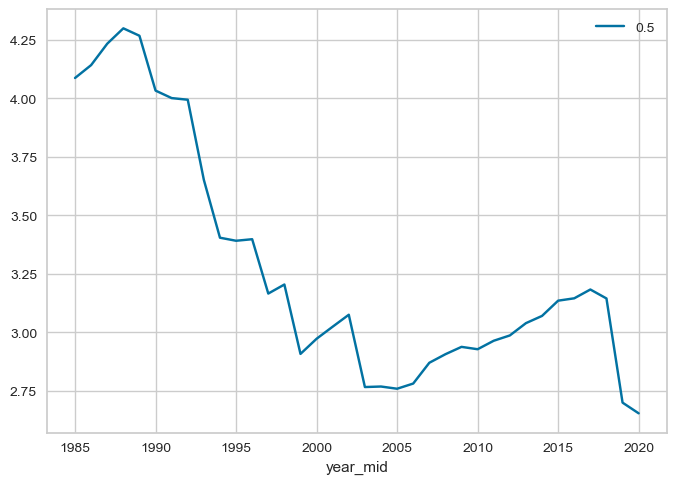

Country: BRN RMSE=0.075 R2=0.605 Model=poisson_regression
Best RMSE=0.075 Model=PoissonRegressor()


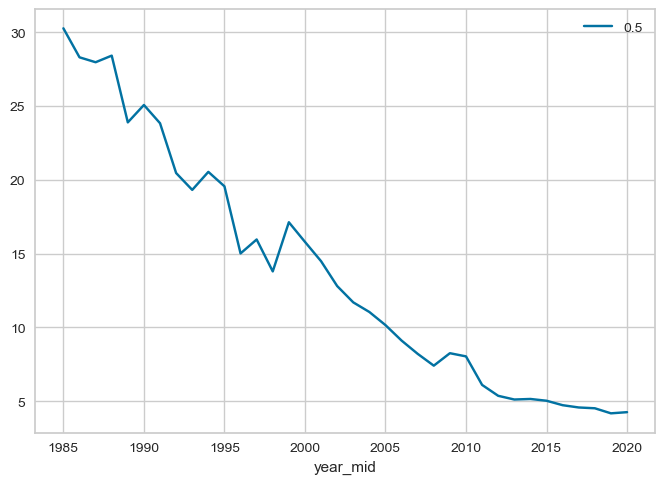

Country: BGR RMSE=1.784 R2=0.973 Model=poisson_regression
Best RMSE=1.784 Model=PoissonRegressor()


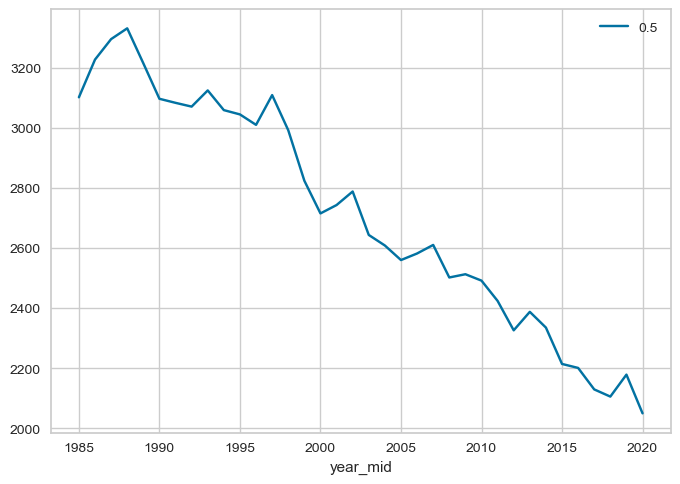

Country: BFA RMSE=7074.645 R2=0.948 Model=poisson_regression
Country: BFA RMSE=5577.267 R2=0.959 Model=bayesian_ard_regression
Best RMSE=5577.267 Model=Pipeline(steps=[('model', ARDRegression())])


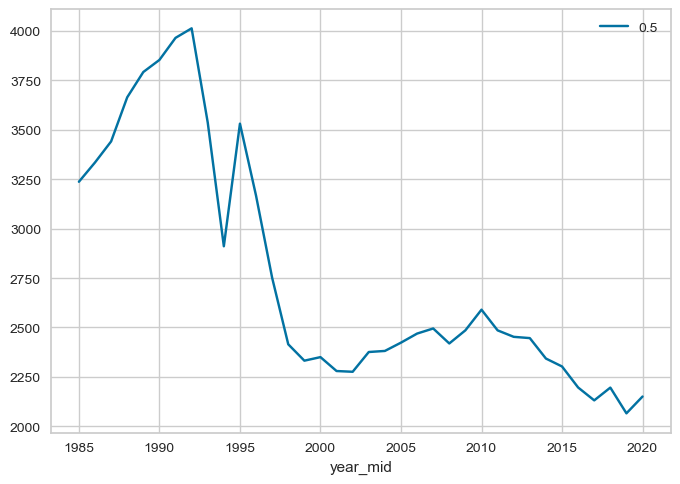

Country: BDI RMSE=107498.964 R2=0.696 Model=poisson_regression
Best RMSE=107498.964 Model=PoissonRegressor()


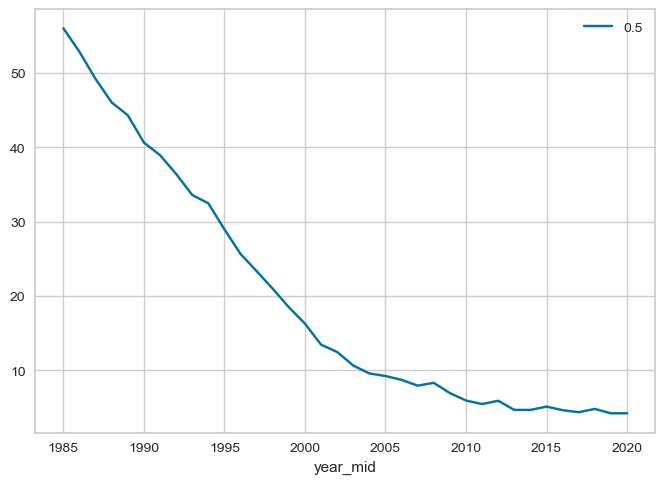

Country: CPV RMSE=3.878 R2=0.985 Model=poisson_regression
Best RMSE=3.878 Model=PoissonRegressor()


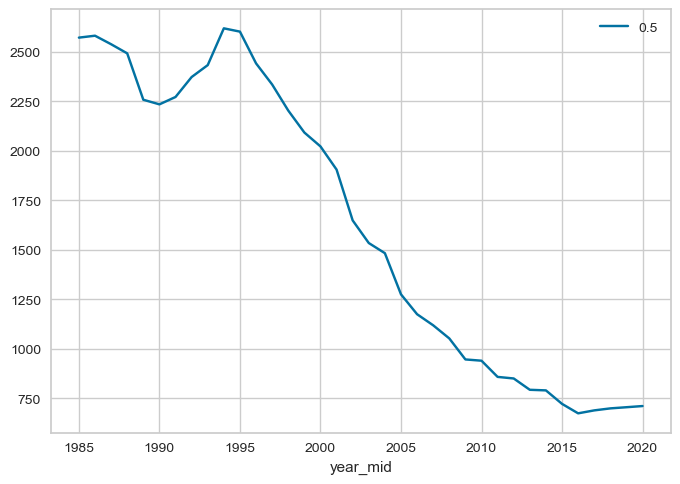

Country: KHM RMSE=80485.544 R2=0.847 Model=poisson_regression
Country: KHM RMSE=45388.557 R2=0.914 Model=huber_regression
Country: KHM RMSE=44015.936 R2=0.916 Model=bayesian_ard_regression
Best RMSE=44015.936 Model=Pipeline(steps=[('model', ARDRegression())])


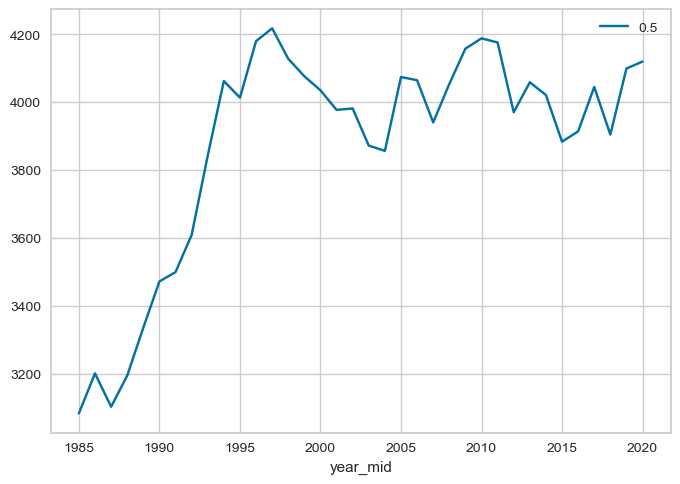

Country: CMR RMSE=107038.974 R2=0.000 Model=gamma_regression
Country: CMR RMSE=57957.261 R2=0.459 Model=bayesian_ard_regression
Best RMSE=57957.261 Model=Pipeline(steps=[('model', ARDRegression())])


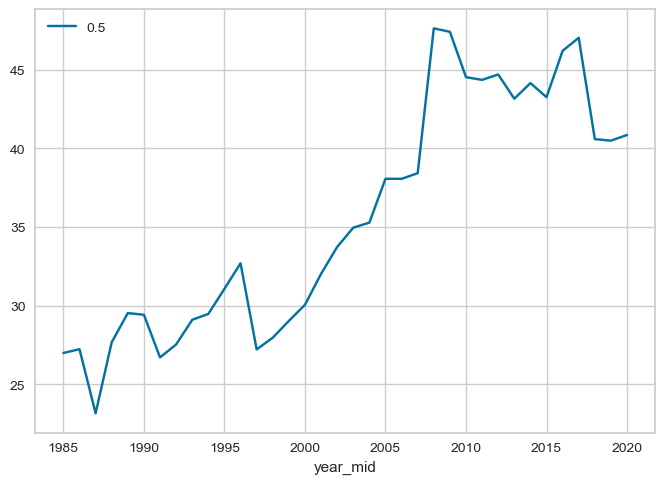

Country: CAN RMSE=10.959 R2=0.800 Model=gamma_regression
Country: CAN RMSE=10.648 R2=0.806 Model=bayesian_ard_regression
Country: CAN RMSE=10.648 R2=0.806 Model=bayesian_ridge_regression
Best RMSE=10.648 Model=Pipeline(steps=[('model', BayesianRidge())])


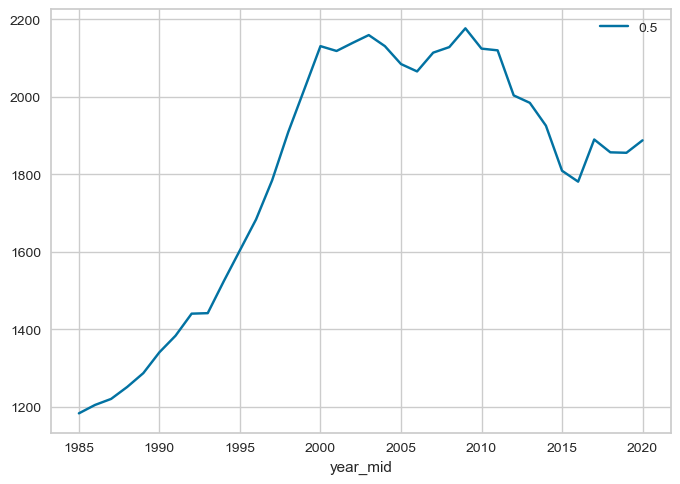

Country: CAF RMSE=59624.531 R2=0.456 Model=gamma_regression
Country: CAF RMSE=51305.452 R2=0.532 Model=bayesian_ard_regression
Best RMSE=51305.452 Model=Pipeline(steps=[('model', ARDRegression())])


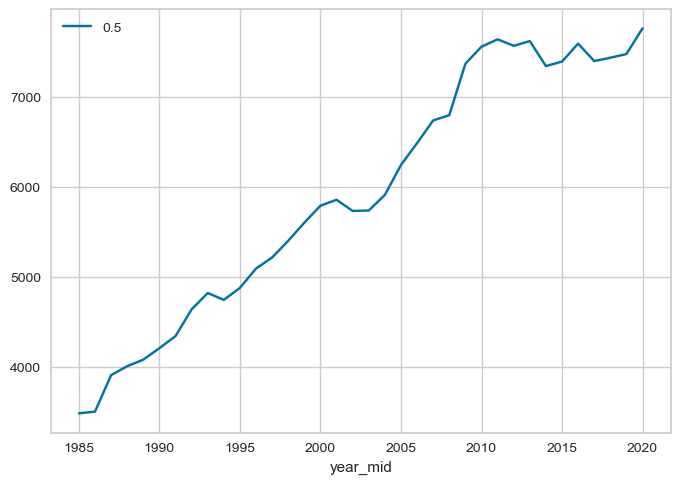

Country: TCD RMSE=142073.856 R2=0.923 Model=gamma_regression
Country: TCD RMSE=77088.667 R2=0.958 Model=bayesian_ard_regression
Best RMSE=77088.667 Model=Pipeline(steps=[('model', ARDRegression())])


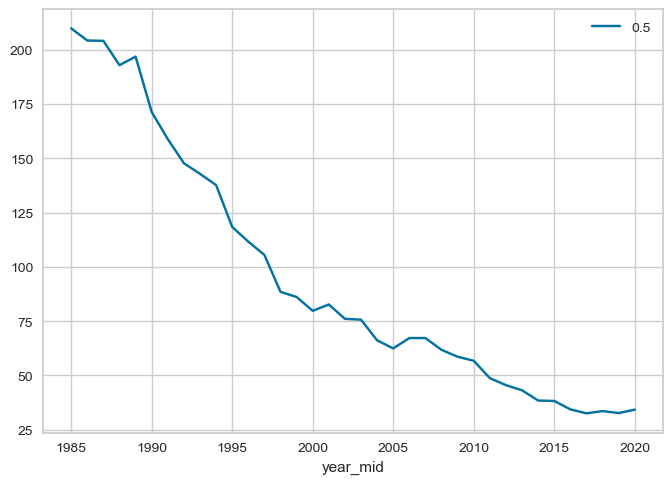

Country: CHL RMSE=48.029 R2=0.985 Model=poisson_regression
Best RMSE=48.029 Model=PoissonRegressor()


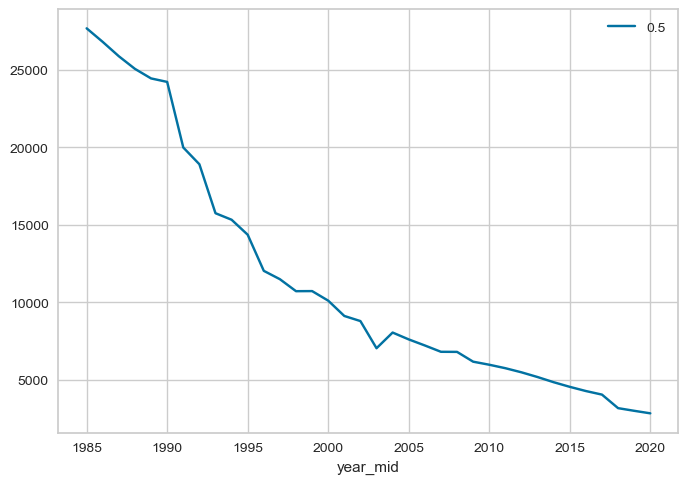

Country: CHN RMSE=1183277.751 R2=0.980 Model=poisson_regression
Best RMSE=1183277.751 Model=PoissonRegressor()


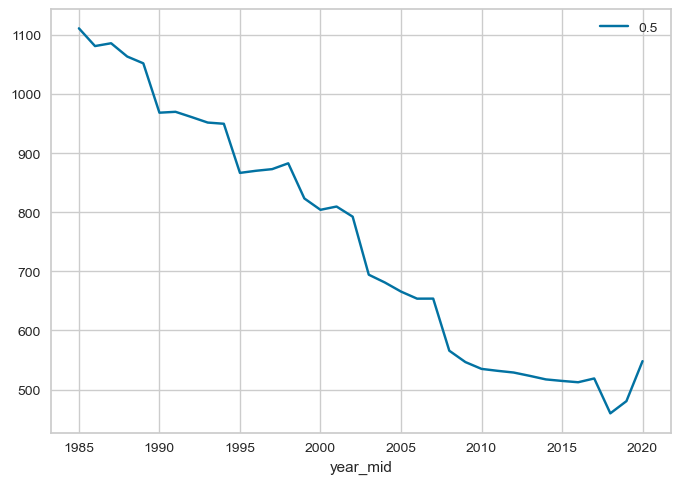

Country: COL RMSE=1126.434 R2=0.974 Model=poisson_regression
Best RMSE=1126.434 Model=PoissonRegressor()


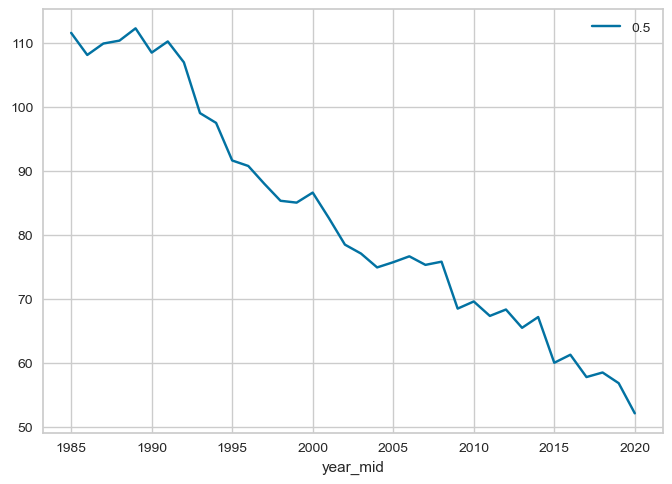

Country: COM RMSE=8.837 R2=0.972 Model=poisson_regression
Best RMSE=8.837 Model=PoissonRegressor()


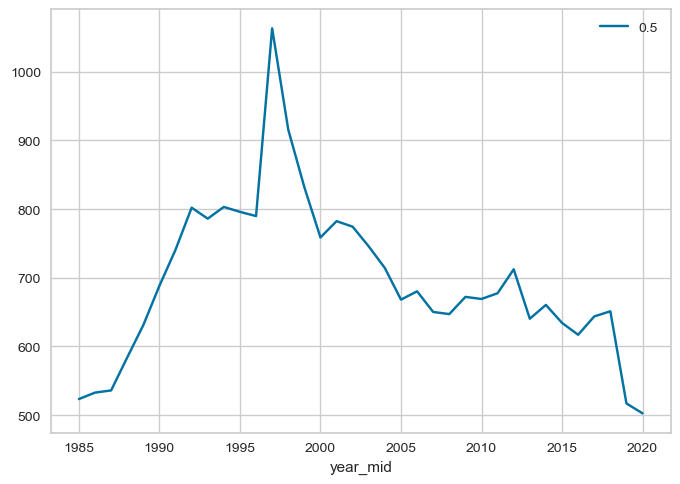

Country: COG RMSE=12295.430 R2=0.000 Model=poisson_regression
Country: COG RMSE=12294.236 R2=0.000 Model=bayesian_ard_regression
Best RMSE=12294.236 Model=Pipeline(steps=[('model', ARDRegression())])


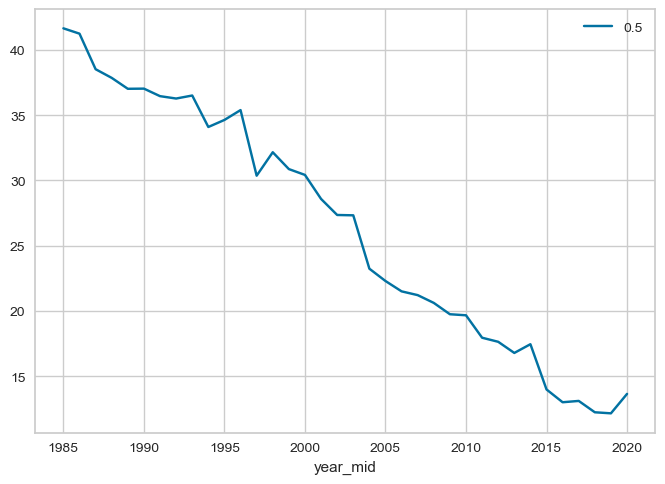

Country: CRI RMSE=4.448 R2=0.948 Model=poisson_regression
Country: CRI RMSE=1.535 R2=0.982 Model=bayesian_ard_regression
Country: CRI RMSE=1.535 R2=0.982 Model=bayesian_ridge_regression
Best RMSE=1.535 Model=Pipeline(steps=[('model', BayesianRidge())])


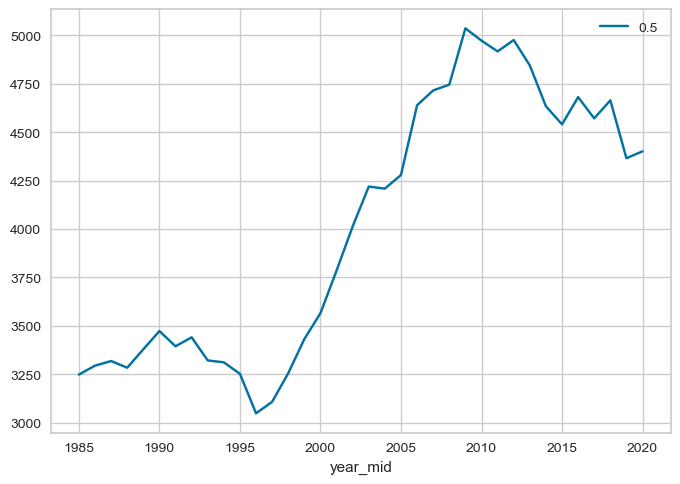

Country: CIV RMSE=112784.599 R2=0.752 Model=gamma_regression
Country: CIV RMSE=109449.430 R2=0.759 Model=bayesian_ard_regression
Best RMSE=109449.430 Model=Pipeline(steps=[('model', ARDRegression())])


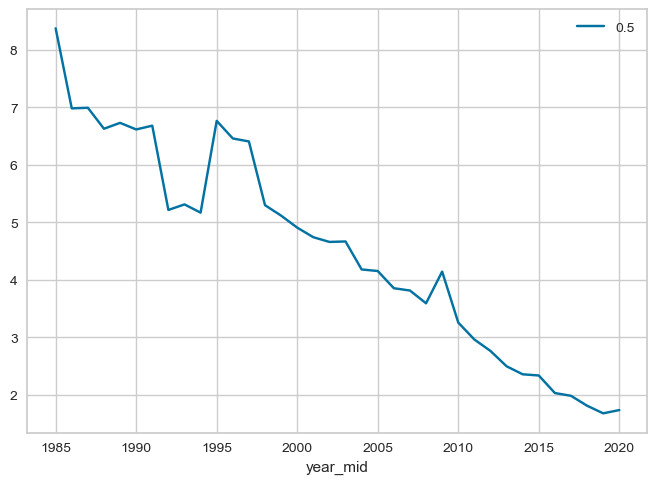

Country: HRV RMSE=0.375 R2=0.885 Model=poisson_regression
Country: HRV RMSE=0.261 R2=0.920 Model=bayesian_ard_regression
Best RMSE=0.261 Model=Pipeline(steps=[('model', ARDRegression())])


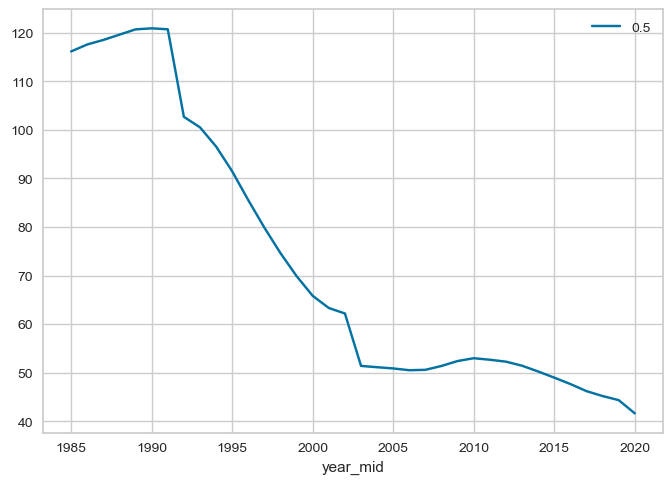

Country: CUB RMSE=62.053 R2=0.921 Model=poisson_regression
Best RMSE=62.053 Model=PoissonRegressor()


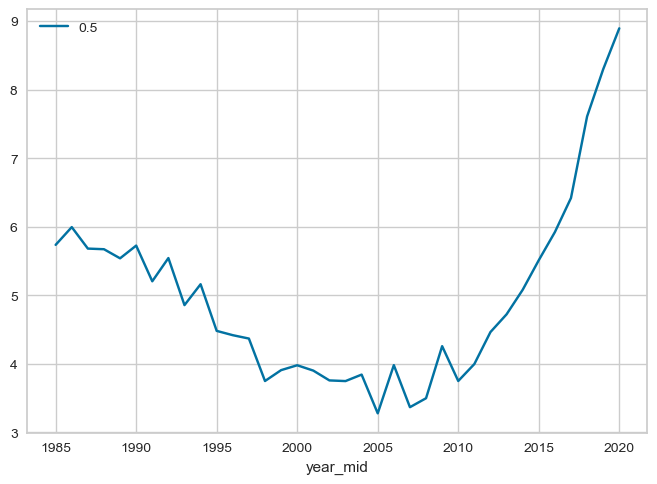

Country: CYP RMSE=1.551 R2=0.000 Model=gamma_regression
Country: CYP RMSE=1.551 R2=0.000 Model=bayesian_ridge_regression
Best RMSE=1.551 Model=Pipeline(steps=[('model', BayesianRidge())])


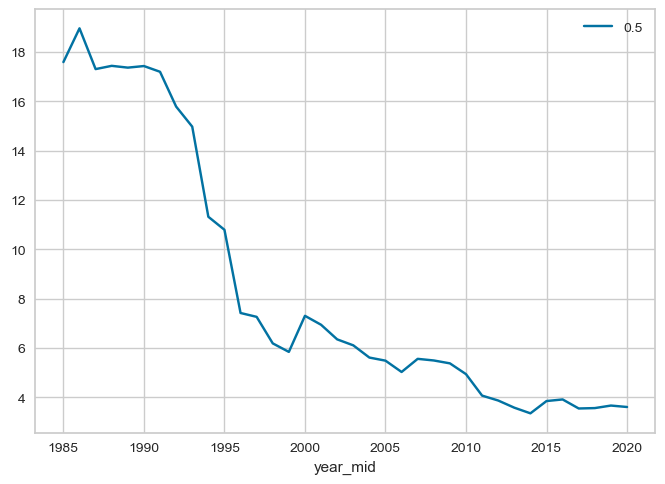

Country: CZE RMSE=2.449 R2=0.912 Model=poisson_regression
Best RMSE=2.449 Model=PoissonRegressor()


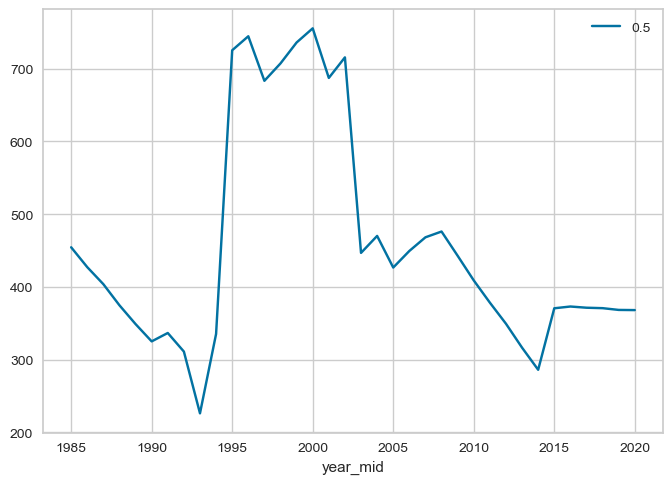

Country: PRK RMSE=23048.887 R2=0.000 Model=poisson_regression
Country: PRK RMSE=23046.115 R2=0.000 Model=bayesian_ard_regression
Best RMSE=23046.115 Model=Pipeline(steps=[('model', ARDRegression())])


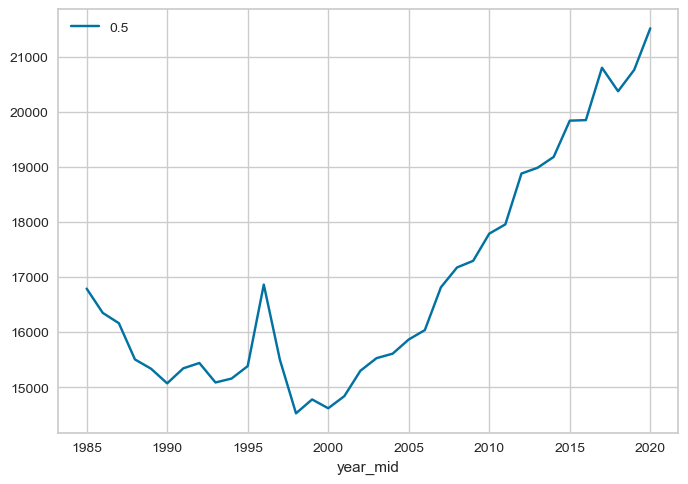

Country: COD RMSE=3590797.531 R2=0.000 Model=poisson_regression
Country: COD RMSE=1282819.978 R2=0.643 Model=gamma_regression
Best RMSE=1282819.978 Model=Pipeline(steps=[('model', GammaRegressor())])


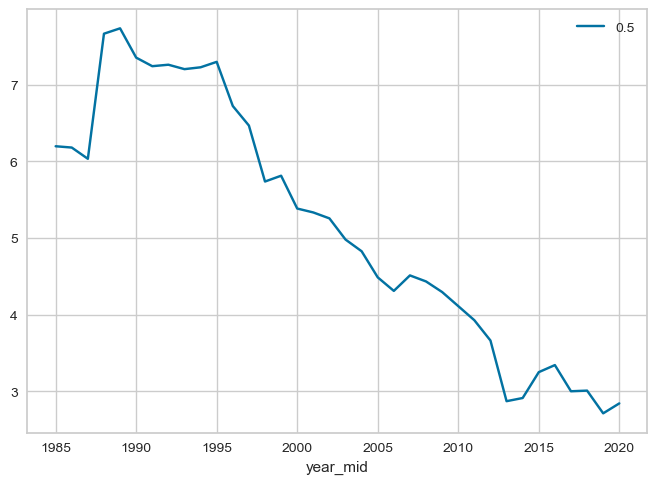

Country: DNK RMSE=0.493 R2=0.800 Model=poisson_regression
Country: DNK RMSE=0.384 R2=0.844 Model=bayesian_ard_regression
Best RMSE=0.384 Model=Pipeline(steps=[('model', ARDRegression())])


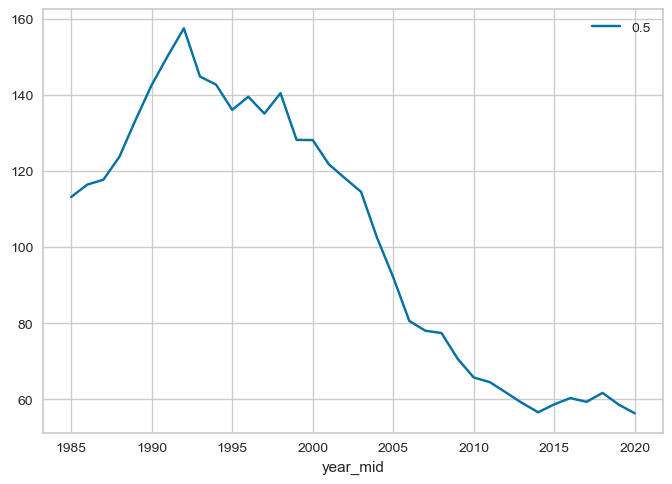

Country: DJI RMSE=359.953 R2=0.682 Model=poisson_regression
Country: DJI RMSE=270.422 R2=0.761 Model=bayesian_ard_regression
Best RMSE=270.422 Model=Pipeline(steps=[('model', ARDRegression())])


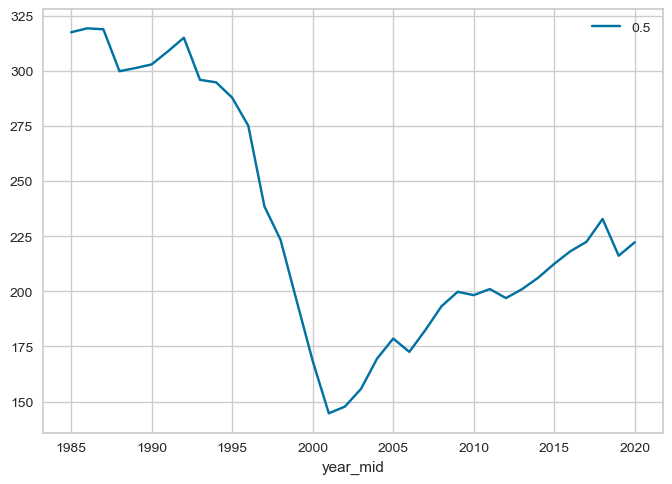

Country: DOM RMSE=1480.462 R2=0.528 Model=poisson_regression
Best RMSE=1480.462 Model=PoissonRegressor()


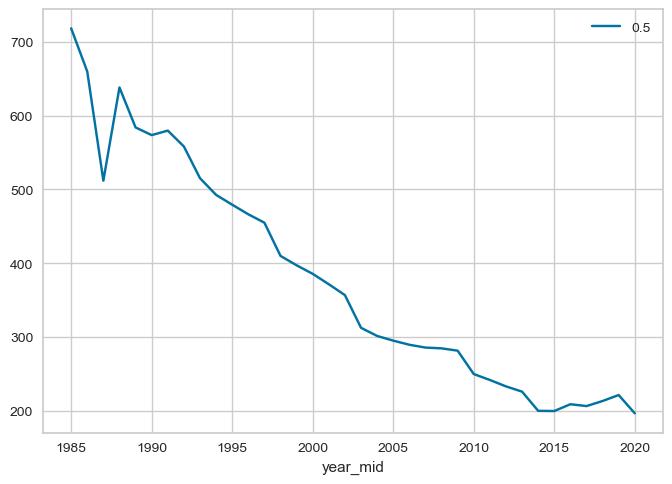

Country: ECU RMSE=747.216 R2=0.967 Model=poisson_regression
Best RMSE=747.216 Model=PoissonRegressor()


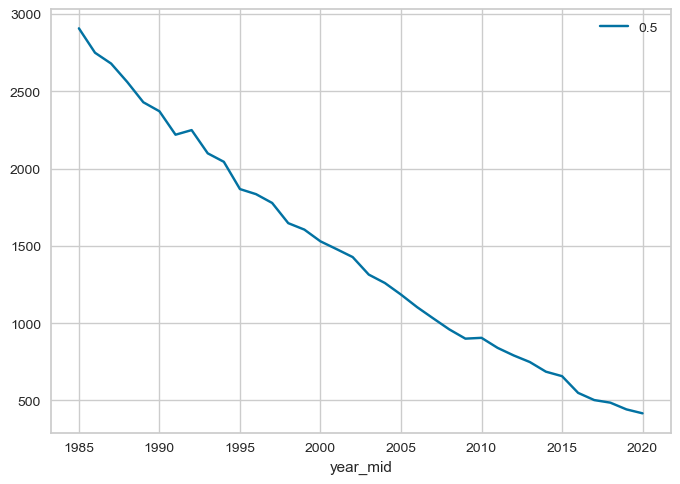

Country: EGY RMSE=6368.005 R2=0.988 Model=poisson_regression
Best RMSE=6368.005 Model=PoissonRegressor()


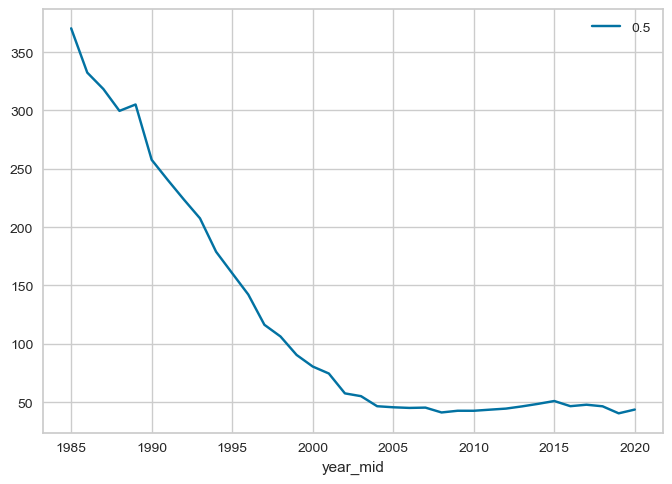

Country: SLV RMSE=356.554 R2=0.966 Model=poisson_regression
Best RMSE=356.554 Model=PoissonRegressor()


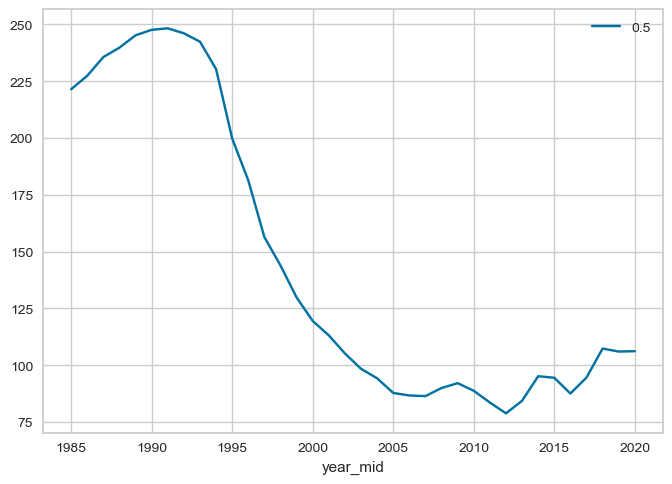

Country: GNQ RMSE=695.655 R2=0.832 Model=poisson_regression
Best RMSE=695.655 Model=PoissonRegressor()


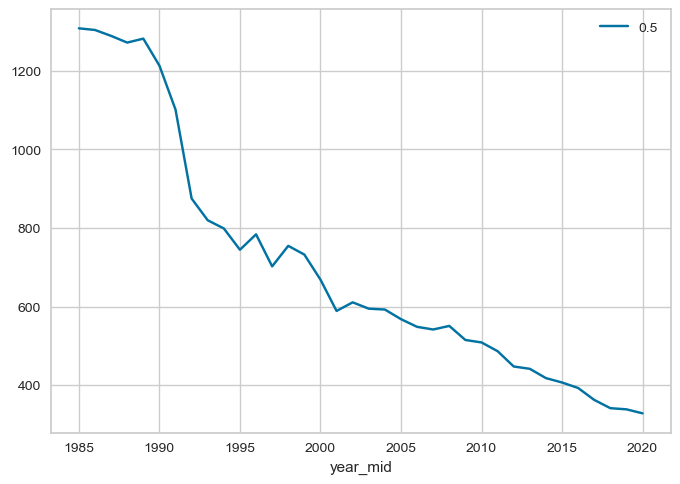

Country: ERI RMSE=4666.828 R2=0.950 Model=poisson_regression
Best RMSE=4666.828 Model=PoissonRegressor()


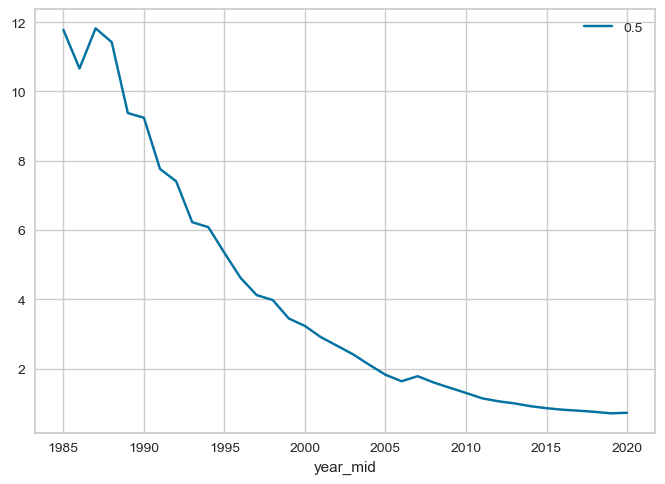

Country: EST RMSE=0.217 R2=0.983 Model=poisson_regression
Best RMSE=0.217 Model=PoissonRegressor()


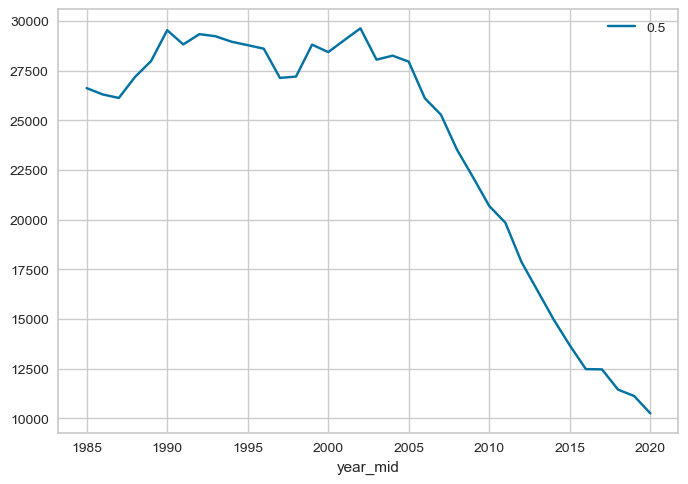

Country: ETH RMSE=15467443.179 R2=0.584 Model=poisson_regression
Country: ETH RMSE=12154652.153 R2=0.673 Model=bayesian_ard_regression
Country: ETH RMSE=12154652.153 R2=0.673 Model=bayesian_ridge_regression
Best RMSE=12154652.153 Model=Pipeline(steps=[('model', BayesianRidge())])


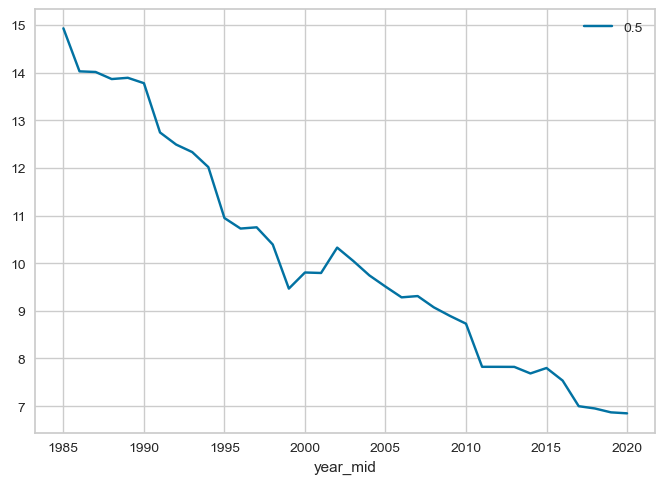

Country: FJI RMSE=0.255 R2=0.951 Model=poisson_regression
Best RMSE=0.255 Model=PoissonRegressor()


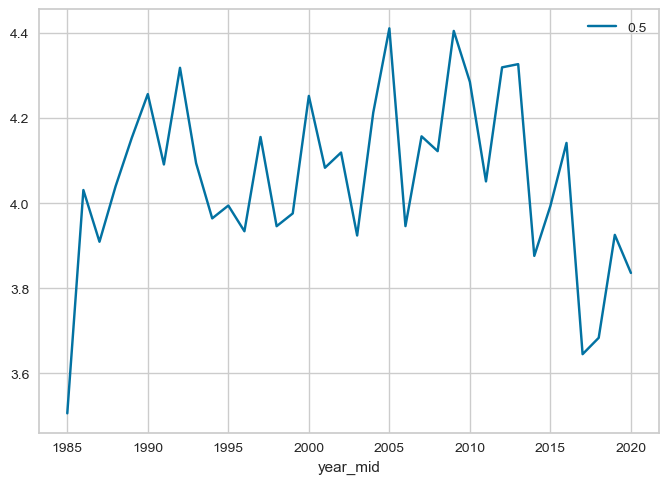

Best RMSE=inf Model=None


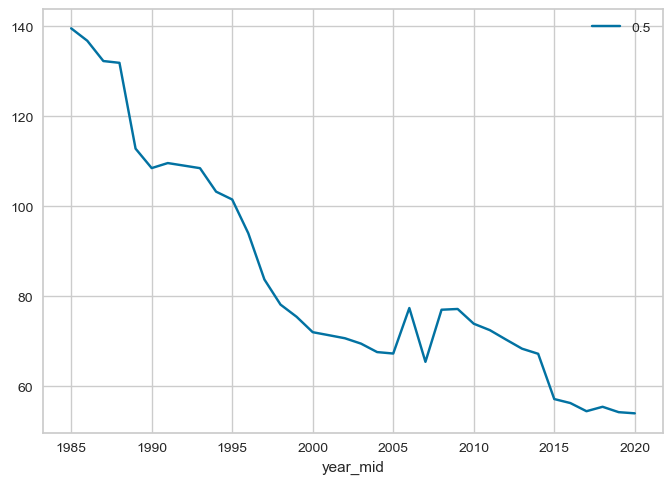

Country: FRA RMSE=64.974 R2=0.895 Model=poisson_regression
Best RMSE=64.974 Model=PoissonRegressor()


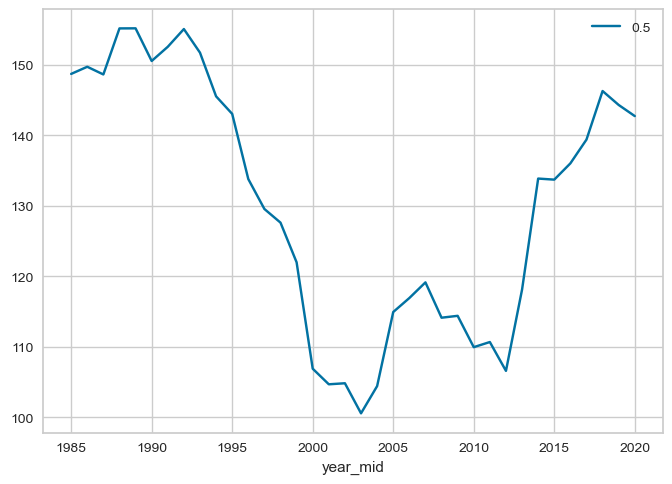

Country: GAB RMSE=244.466 R2=0.244 Model=poisson_regression
Best RMSE=244.466 Model=PoissonRegressor()


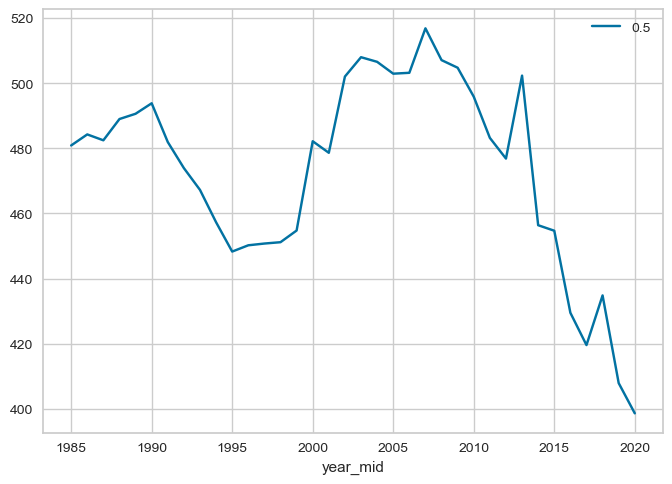

Country: GMB RMSE=732.084 R2=0.000 Model=poisson_regression
Country: GMB RMSE=690.240 R2=0.057 Model=bayesian_ard_regression
Best RMSE=690.240 Model=Pipeline(steps=[('model', ARDRegression())])


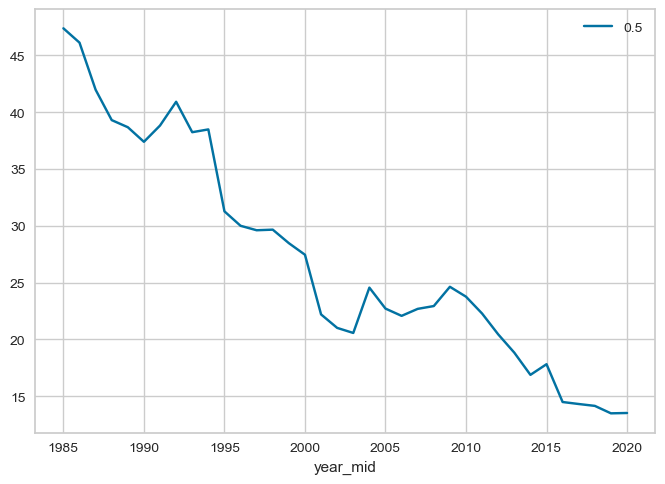

Country: GEO RMSE=5.852 R2=0.936 Model=poisson_regression
Best RMSE=5.852 Model=PoissonRegressor()


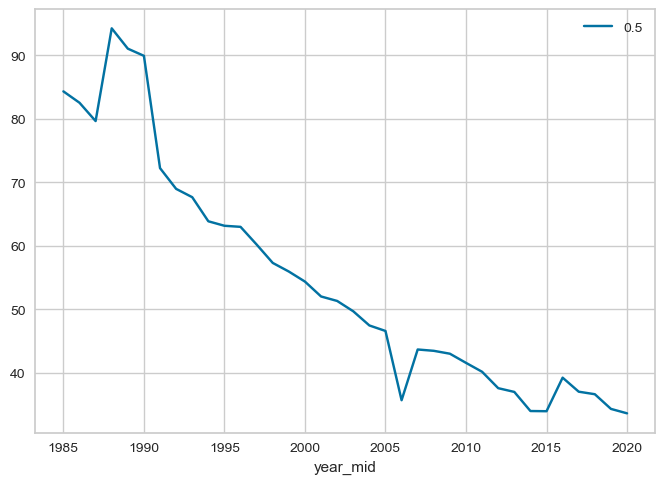

Country: DEU RMSE=23.082 R2=0.929 Model=poisson_regression
Best RMSE=23.082 Model=PoissonRegressor()


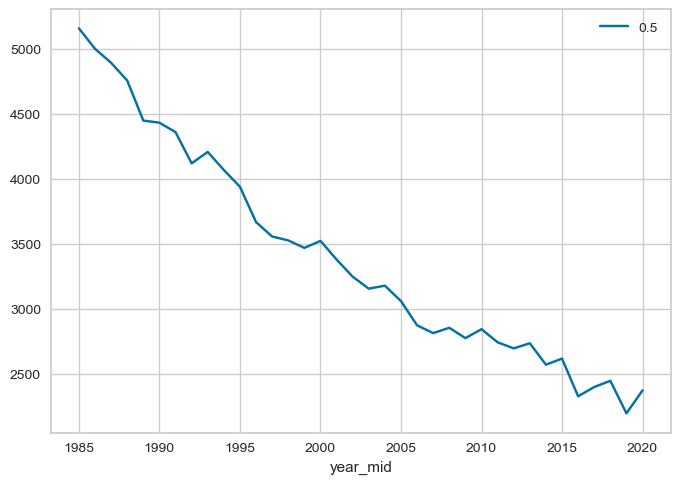

Country: GHA RMSE=11196.788 R2=0.984 Model=poisson_regression
Best RMSE=11196.788 Model=PoissonRegressor()


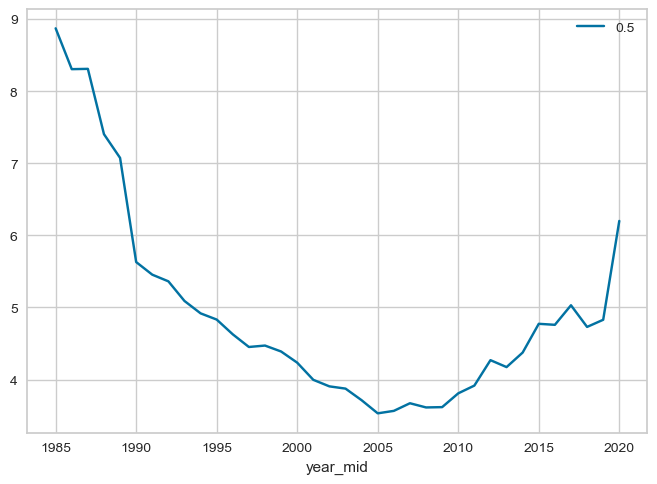

Country: GRC RMSE=0.947 R2=0.454 Model=poisson_regression
Best RMSE=0.947 Model=PoissonRegressor()


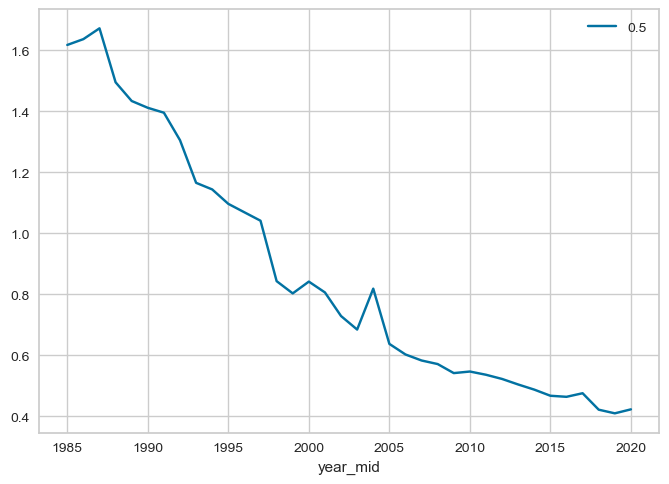

Country: GRD RMSE=0.114 R2=0.544 Model=poisson_regression
Country: GRD RMSE=0.104 R2=0.584 Model=bayesian_ard_regression
Country: GRD RMSE=0.104 R2=0.584 Model=bayesian_ridge_regression
Best RMSE=0.104 Model=Pipeline(steps=[('model', BayesianRidge())])


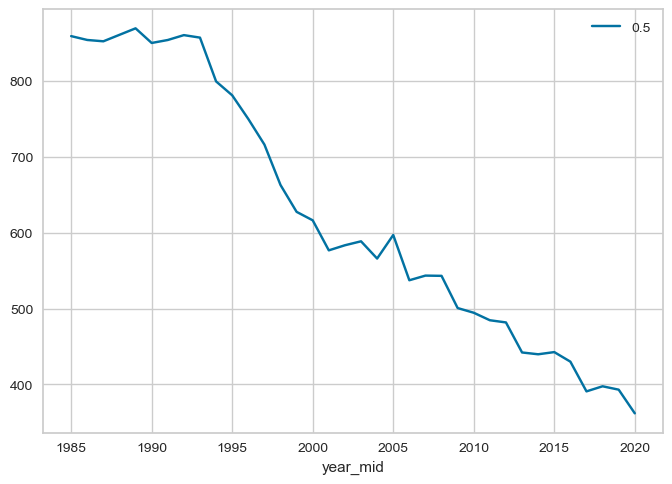

Country: GTM RMSE=1275.563 R2=0.954 Model=poisson_regression
Country: GTM RMSE=1192.722 R2=0.957 Model=bayesian_ard_regression
Best RMSE=1192.722 Model=Pipeline(steps=[('model', ARDRegression())])


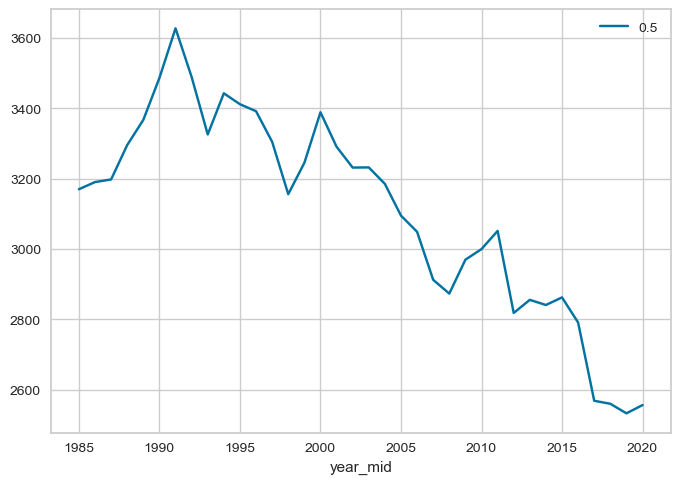

Country: GIN RMSE=22961.137 R2=0.696 Model=poisson_regression
Country: GIN RMSE=21243.753 R2=0.719 Model=bayesian_ard_regression
Best RMSE=21243.753 Model=Pipeline(steps=[('model', ARDRegression())])


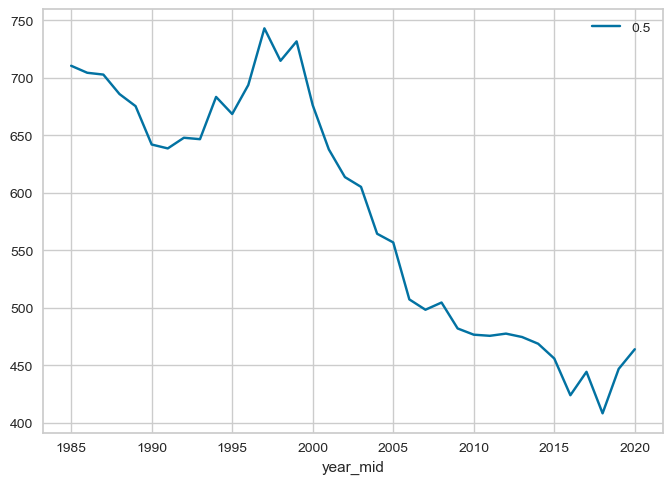

Country: GNB RMSE=2286.704 R2=0.792 Model=poisson_regression
Country: GNB RMSE=1950.537 R2=0.823 Model=bayesian_ard_regression
Best RMSE=1950.537 Model=Pipeline(steps=[('model', ARDRegression())])


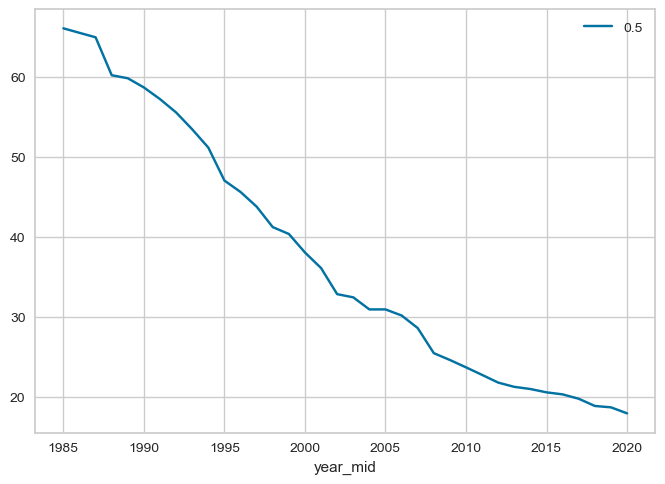

Country: GUY RMSE=2.519 R2=0.990 Model=poisson_regression
Best RMSE=2.519 Model=PoissonRegressor()


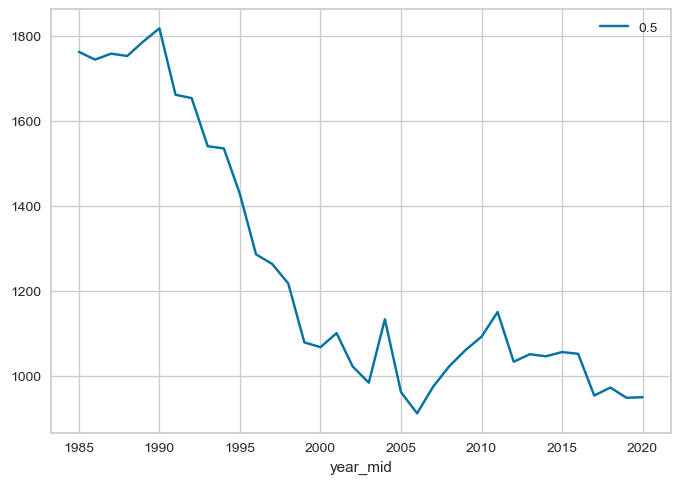

Country: HTI RMSE=16769.701 R2=0.818 Model=poisson_regression
Best RMSE=16769.701 Model=PoissonRegressor()


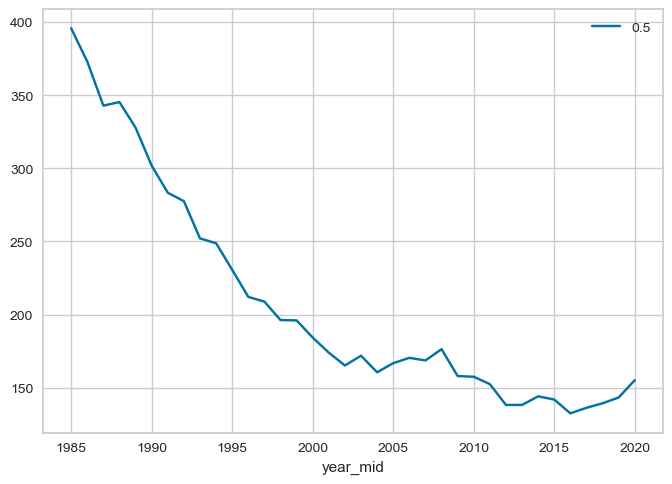

Country: HND RMSE=433.600 R2=0.923 Model=poisson_regression
Best RMSE=433.600 Model=PoissonRegressor()


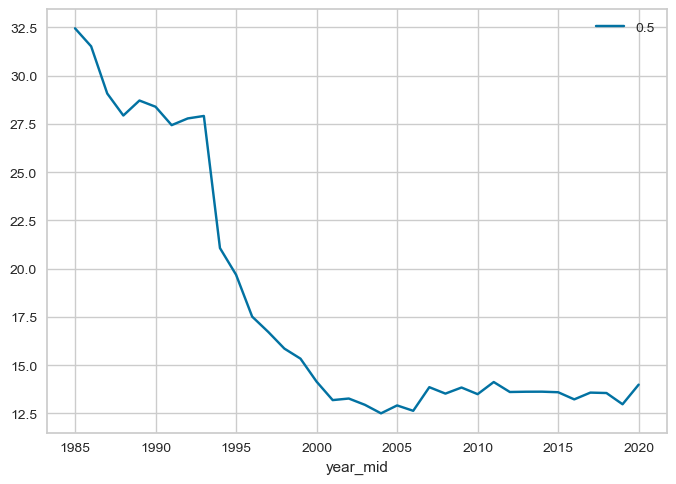

Country: HUN RMSE=8.408 R2=0.808 Model=poisson_regression
Best RMSE=8.408 Model=PoissonRegressor()


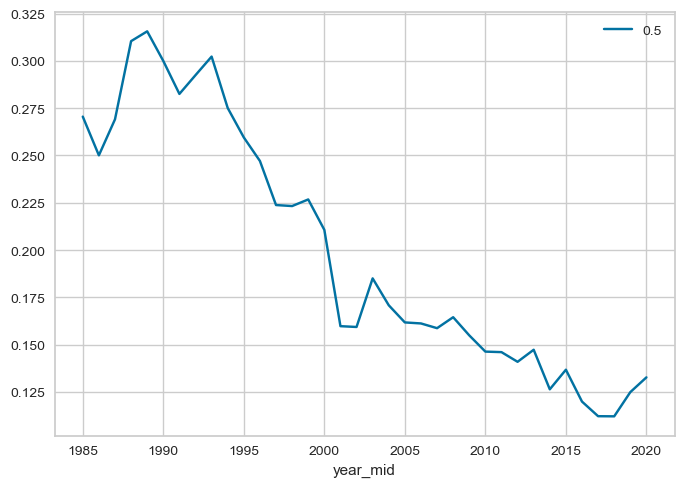

Best RMSE=inf Model=None


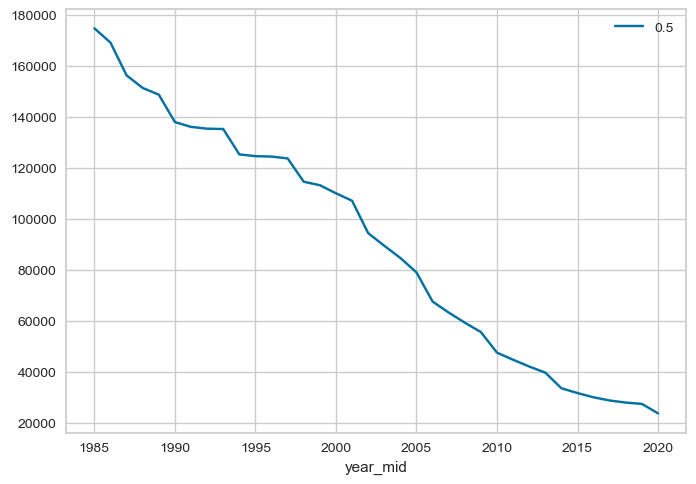

Country: IND RMSE=137177494.222 R2=0.935 Model=poisson_regression
Country: IND RMSE=32350582.976 R2=0.985 Model=bayesian_ard_regression
Best RMSE=32350582.976 Model=Pipeline(steps=[('model', ARDRegression())])


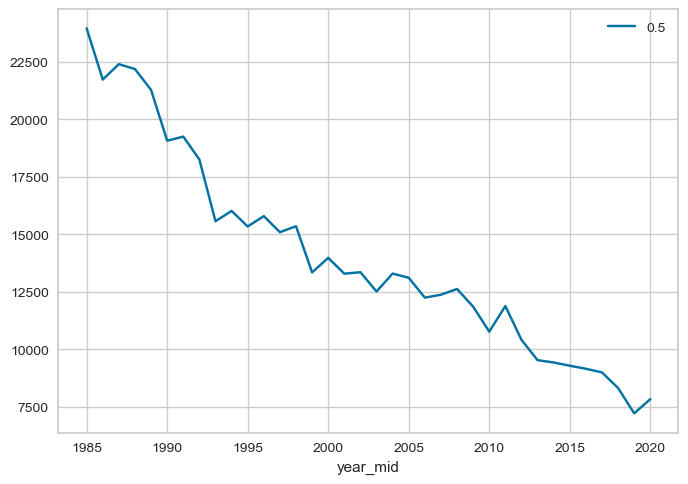

Country: IDN RMSE=773218.787 R2=0.960 Model=poisson_regression
Best RMSE=773218.787 Model=PoissonRegressor()


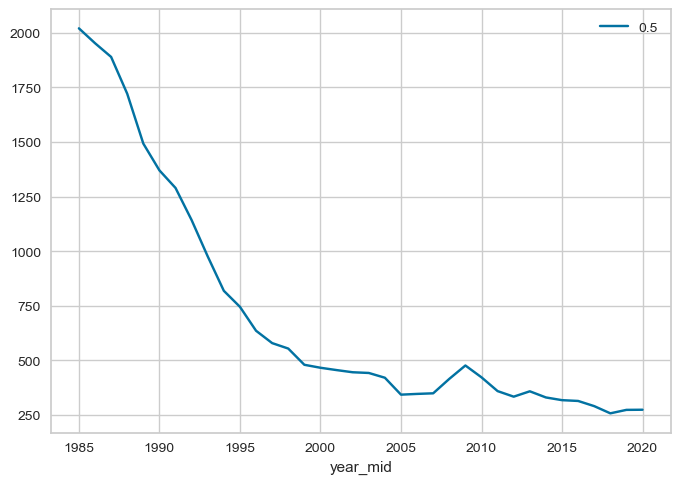

Country: IRN RMSE=20068.317 R2=0.928 Model=poisson_regression
Best RMSE=20068.317 Model=PoissonRegressor()


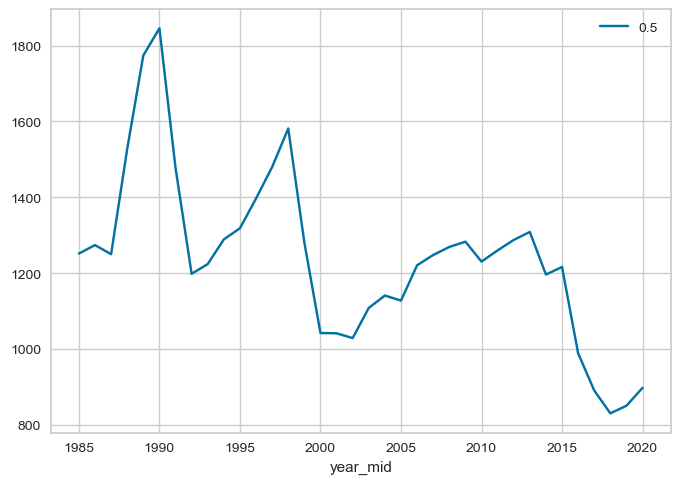

Country: IRQ RMSE=30867.311 R2=0.358 Model=poisson_regression
Country: IRQ RMSE=30564.771 R2=0.364 Model=bayesian_ard_regression
Best RMSE=30564.771 Model=Pipeline(steps=[('model', ARDRegression())])


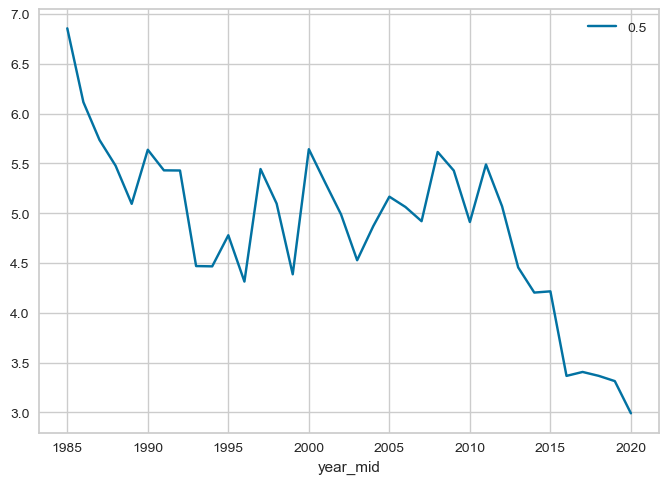

Country: IRL RMSE=0.529 R2=0.386 Model=poisson_regression
Country: IRL RMSE=0.520 R2=0.397 Model=bayesian_ard_regression
Best RMSE=0.520 Model=Pipeline(steps=[('model', ARDRegression())])


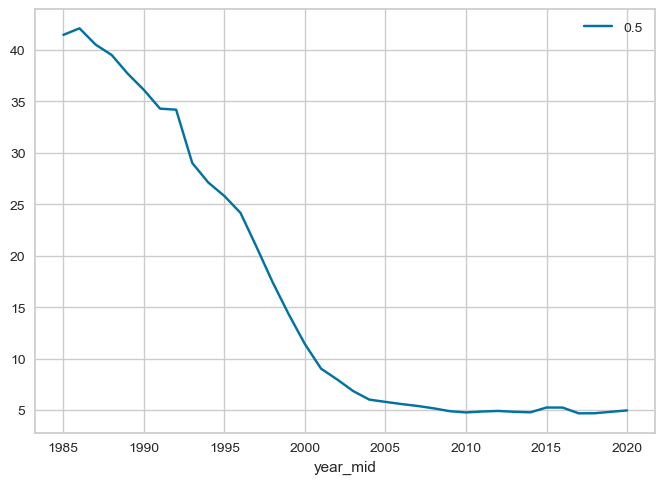

Country: ISR RMSE=10.465 R2=0.944 Model=poisson_regression
Best RMSE=10.465 Model=PoissonRegressor()


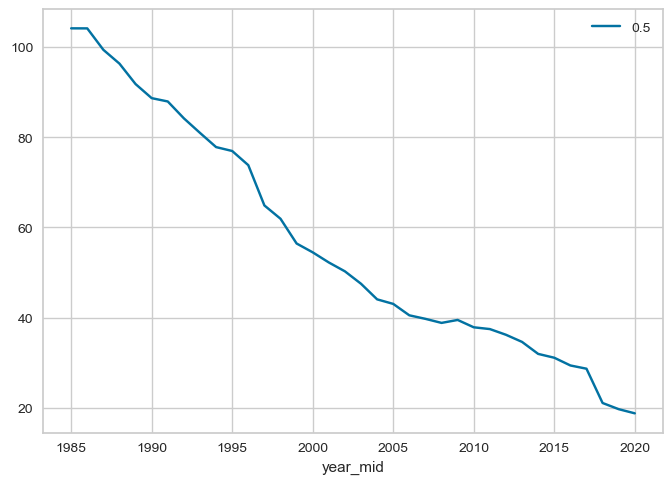

Country: ITA RMSE=8.945 R2=0.986 Model=poisson_regression
Best RMSE=8.945 Model=PoissonRegressor()


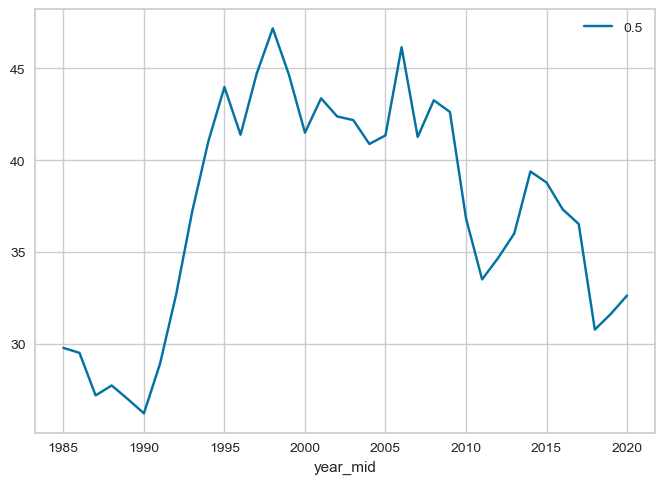

Country: JAM RMSE=36.477 R2=0.000 Model=gamma_regression
Country: JAM RMSE=36.035 R2=0.012 Model=huber_regression
Country: JAM RMSE=33.466 R2=0.083 Model=bayesian_ard_regression
Best RMSE=33.466 Model=Pipeline(steps=[('model', ARDRegression())])


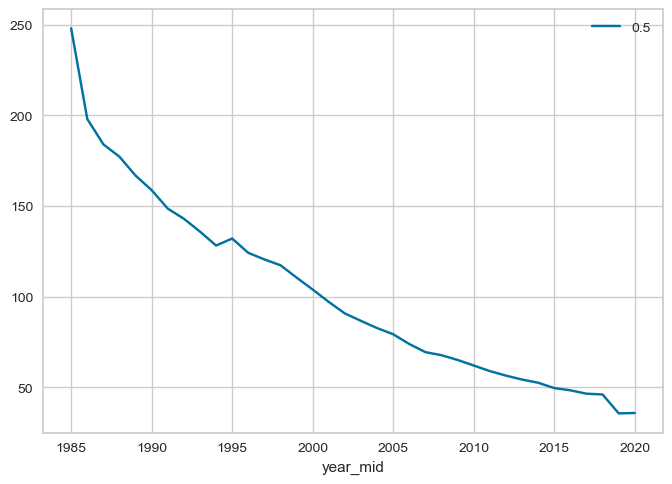

Country: JPN RMSE=54.097 R2=0.979 Model=poisson_regression
Best RMSE=54.097 Model=PoissonRegressor()


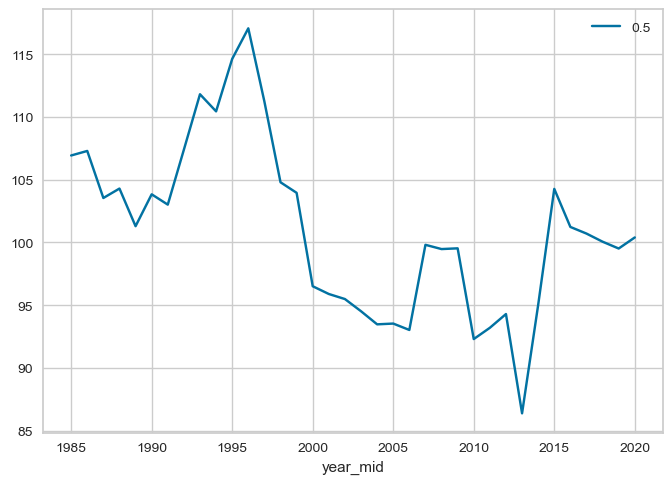

Country: JOR RMSE=47.987 R2=0.000 Model=poisson_regression
Country: JOR RMSE=32.940 R2=0.314 Model=bayesian_ard_regression
Country: JOR RMSE=32.940 R2=0.314 Model=bayesian_ridge_regression
Best RMSE=32.940 Model=Pipeline(steps=[('model', BayesianRidge())])


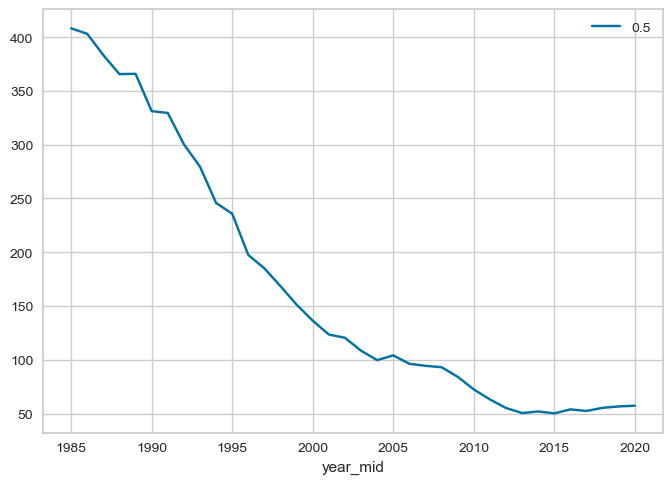

Country: KAZ RMSE=257.165 R2=0.982 Model=poisson_regression
Best RMSE=257.165 Model=PoissonRegressor()


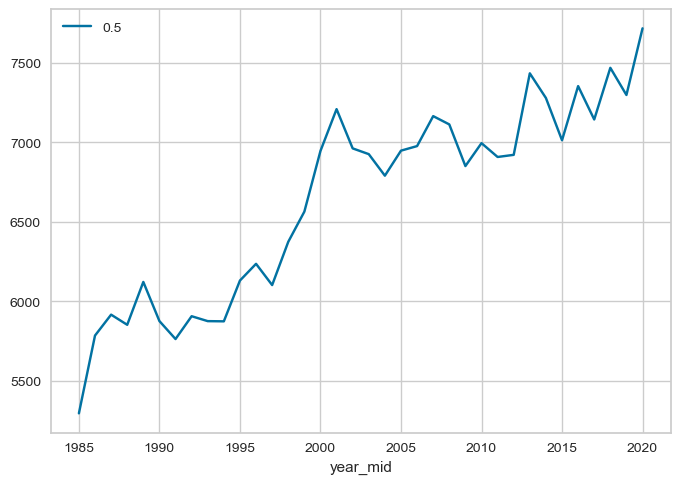

Country: KEN RMSE=59629.450 R2=0.833 Model=gamma_regression
Country: KEN RMSE=54811.502 R2=0.846 Model=bayesian_ard_regression
Best RMSE=54811.502 Model=Pipeline(steps=[('model', ARDRegression())])


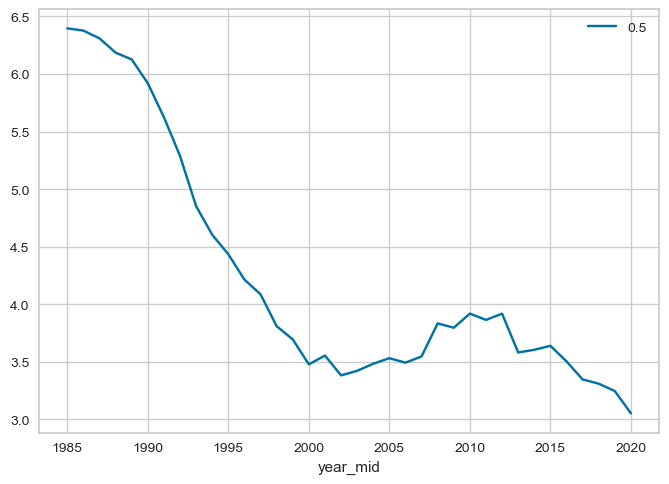

Country: KIR RMSE=0.388 R2=0.630 Model=poisson_regression
Best RMSE=0.388 Model=PoissonRegressor()


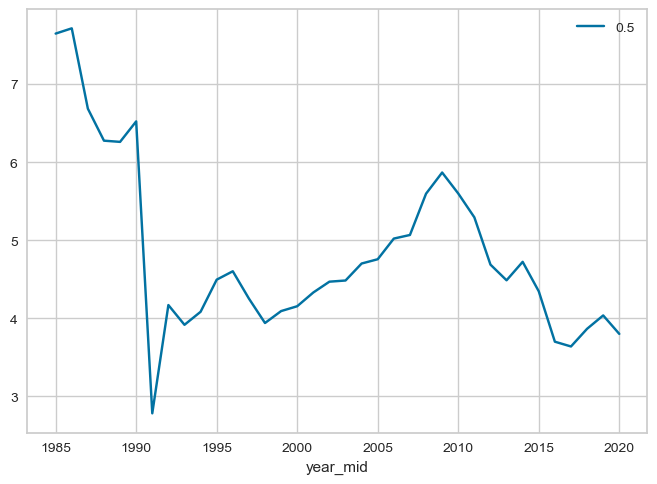

Country: KWT RMSE=1.207 R2=0.181 Model=poisson_regression
Best RMSE=1.207 Model=PoissonRegressor()


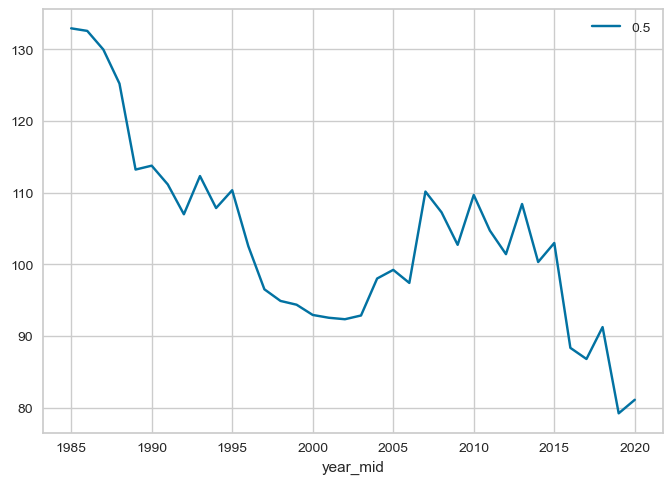

Country: KGZ RMSE=75.695 R2=0.515 Model=poisson_regression
Best RMSE=75.695 Model=PoissonRegressor()


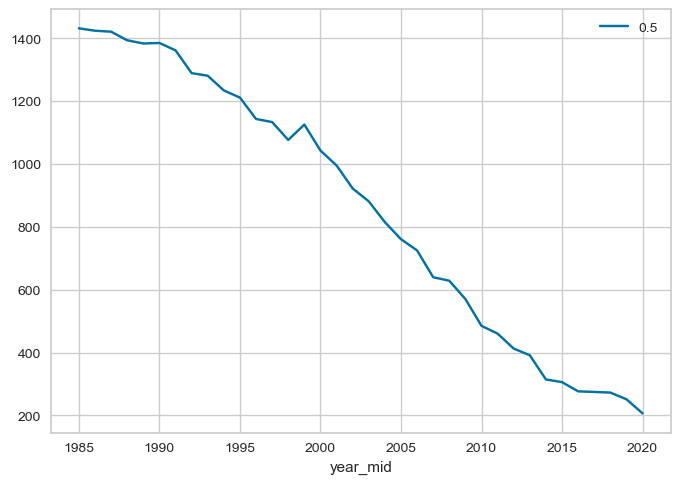

Country: LAO RMSE=16671.948 R2=0.901 Model=poisson_regression
Country: LAO RMSE=3142.589 R2=0.981 Model=bayesian_ard_regression
Best RMSE=3142.589 Model=Pipeline(steps=[('model', ARDRegression())])


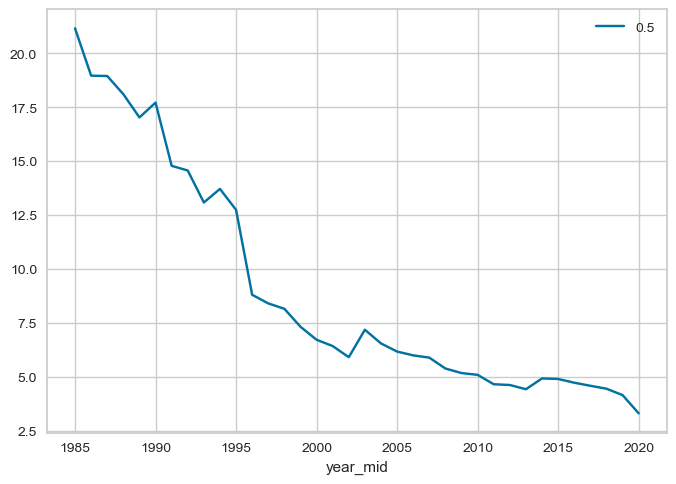

Country: LVA RMSE=1.667 R2=0.940 Model=poisson_regression
Best RMSE=1.667 Model=PoissonRegressor()


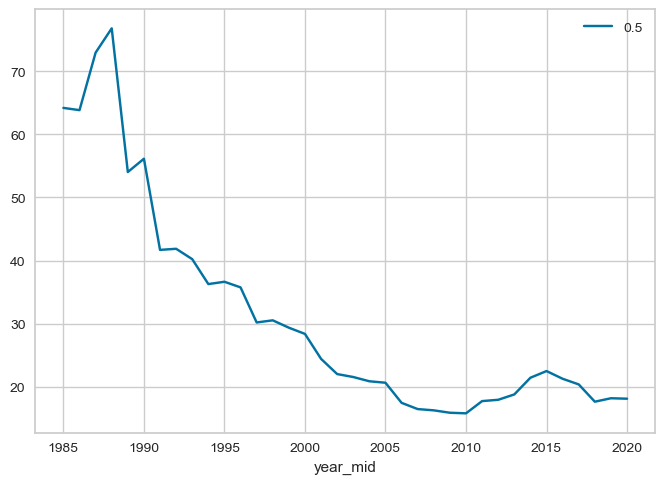

Country: LBN RMSE=39.505 R2=0.866 Model=poisson_regression
Best RMSE=39.505 Model=PoissonRegressor()


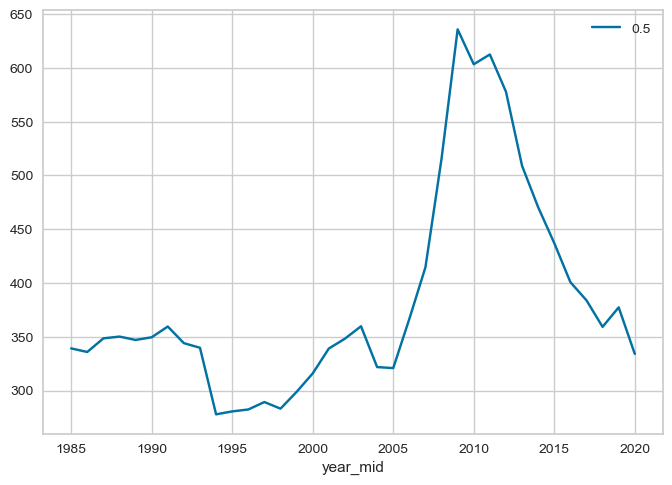

Country: LSO RMSE=6720.287 R2=0.298 Model=gamma_regression
Best RMSE=6720.287 Model=Pipeline(steps=[('model', GammaRegressor())])


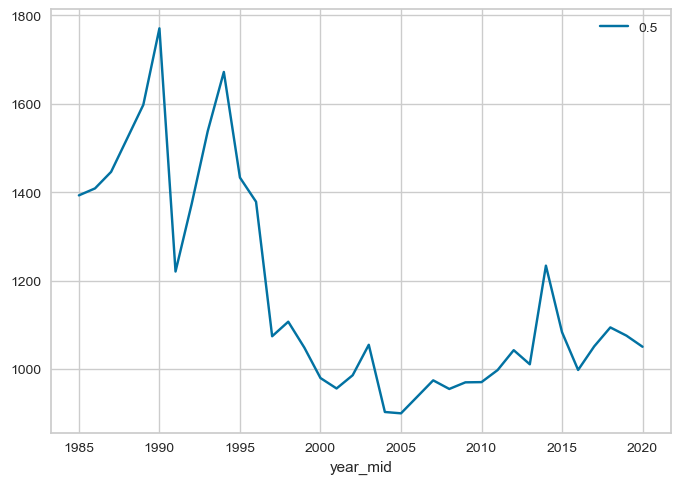

Country: LBR RMSE=27630.256 R2=0.529 Model=poisson_regression
Best RMSE=27630.256 Model=PoissonRegressor()


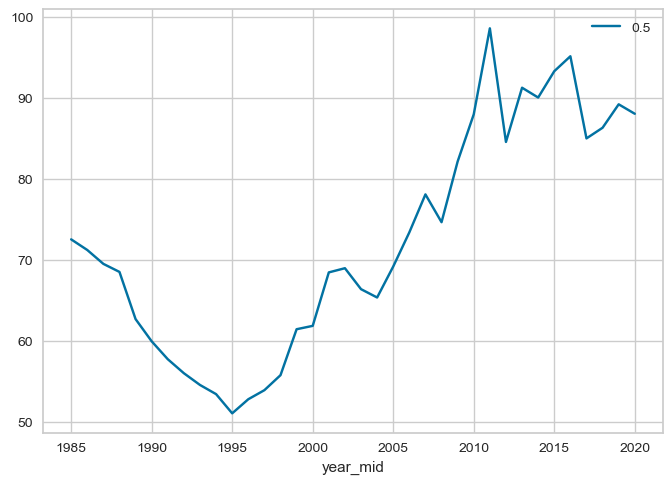

Country: LBY RMSE=70.283 R2=0.632 Model=gamma_regression
Best RMSE=70.283 Model=Pipeline(steps=[('model', GammaRegressor())])


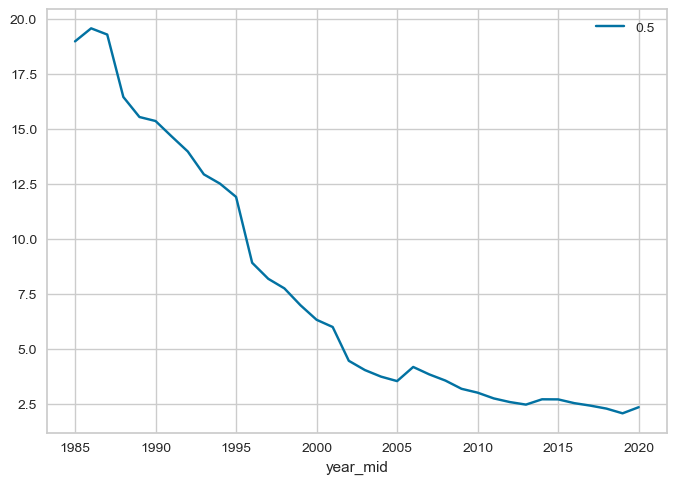

Country: LTU RMSE=0.963 R2=0.971 Model=poisson_regression
Best RMSE=0.963 Model=PoissonRegressor()


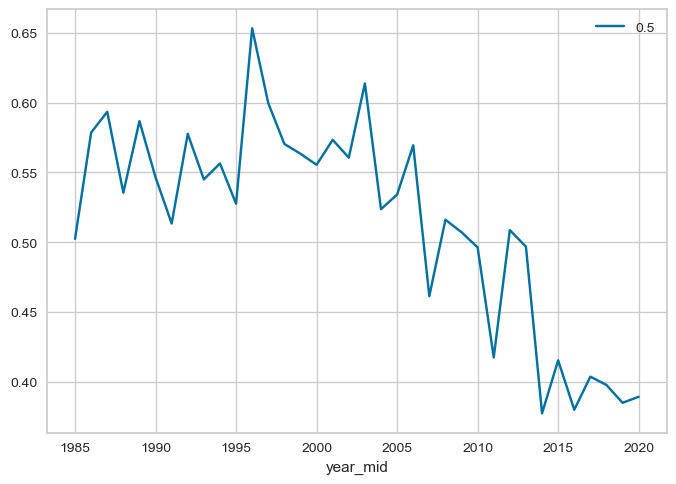

Country: LUX RMSE=0.119 R2=0.417 Model=poisson_regression
Country: LUX RMSE=0.089 R2=0.564 Model=bayesian_ard_regression
Best RMSE=0.089 Model=Pipeline(steps=[('model', ARDRegression())])


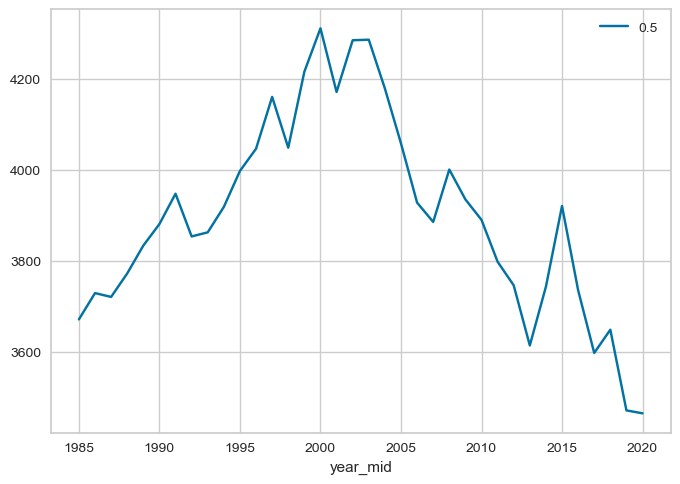

Country: MDG RMSE=43351.154 R2=0.000 Model=poisson_regression
Country: MDG RMSE=41917.904 R2=0.033 Model=bayesian_ard_regression
Country: MDG RMSE=41917.904 R2=0.033 Model=bayesian_ridge_regression
Best RMSE=41917.904 Model=Pipeline(steps=[('model', BayesianRidge())])


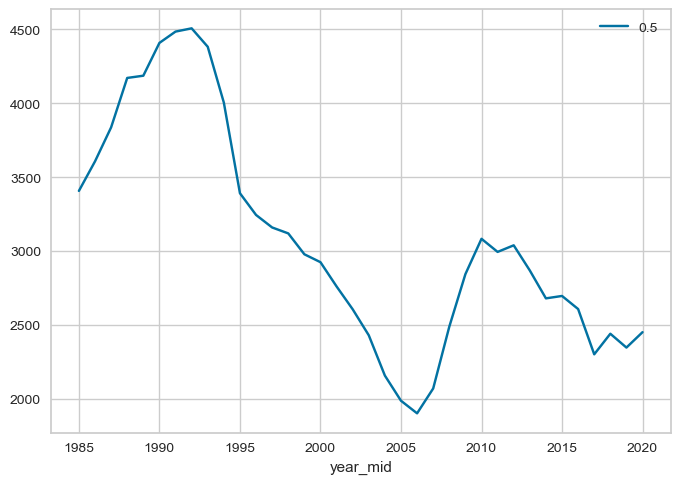

Country: MWI RMSE=234291.979 R2=0.581 Model=poisson_regression
Best RMSE=234291.979 Model=PoissonRegressor()


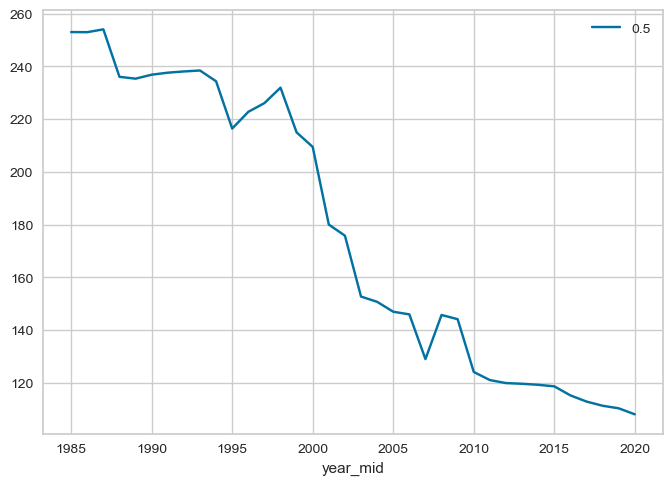

Country: MYS RMSE=229.527 R2=0.917 Model=poisson_regression
Country: MYS RMSE=184.162 R2=0.934 Model=bayesian_ard_regression
Country: MYS RMSE=184.162 R2=0.934 Model=bayesian_ridge_regression
Best RMSE=184.162 Model=Pipeline(steps=[('model', BayesianRidge())])


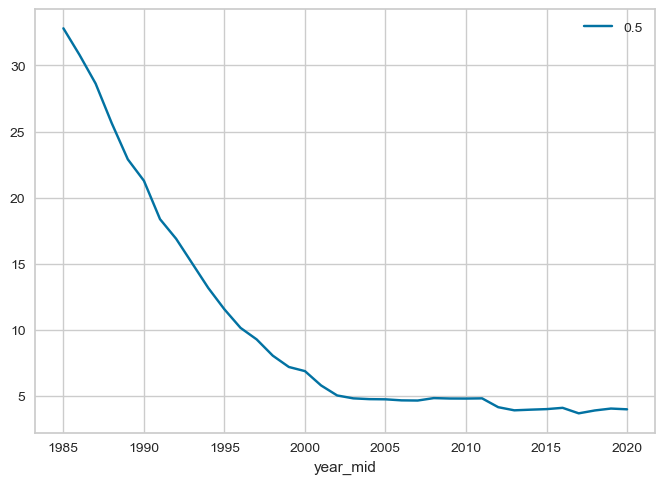

Country: MDV RMSE=3.673 R2=0.950 Model=poisson_regression
Best RMSE=3.673 Model=PoissonRegressor()


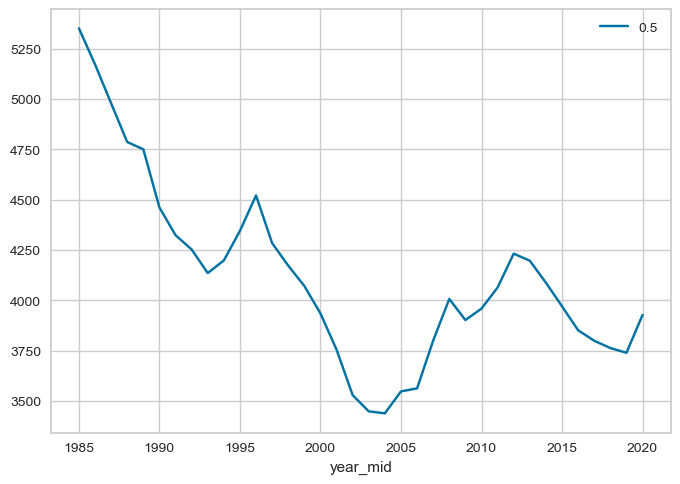

Country: MLI RMSE=102601.992 R2=0.514 Model=poisson_regression
Best RMSE=102601.992 Model=PoissonRegressor()


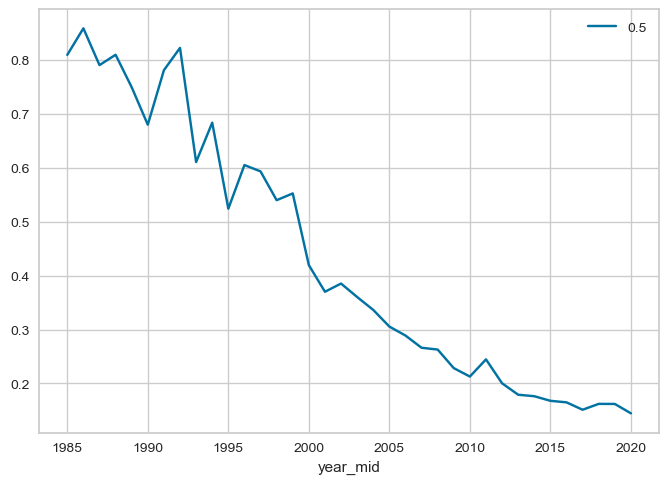

Country: MLT RMSE=0.100 R2=0.592 Model=poisson_regression
Country: MLT RMSE=0.065 R2=0.735 Model=bayesian_ard_regression
Best RMSE=0.065 Model=Pipeline(steps=[('model', ARDRegression())])


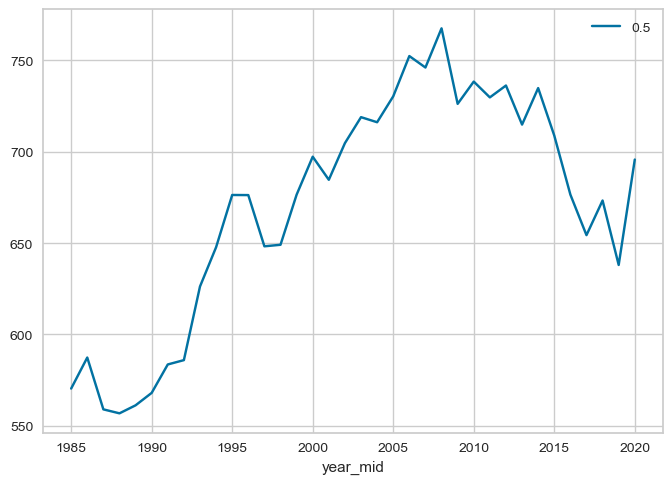

Country: MRT RMSE=1999.072 R2=0.498 Model=gamma_regression
Country: MRT RMSE=1884.249 R2=0.527 Model=bayesian_ard_regression
Best RMSE=1884.249 Model=Pipeline(steps=[('model', ARDRegression())])


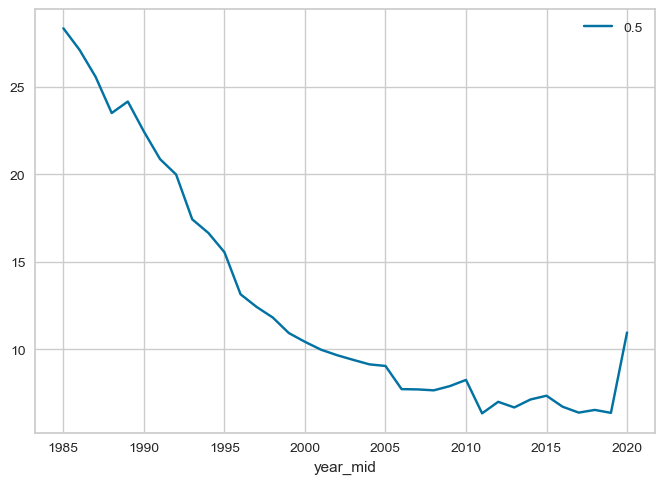

Country: MUS RMSE=1.929 R2=0.959 Model=poisson_regression
Best RMSE=1.929 Model=PoissonRegressor()


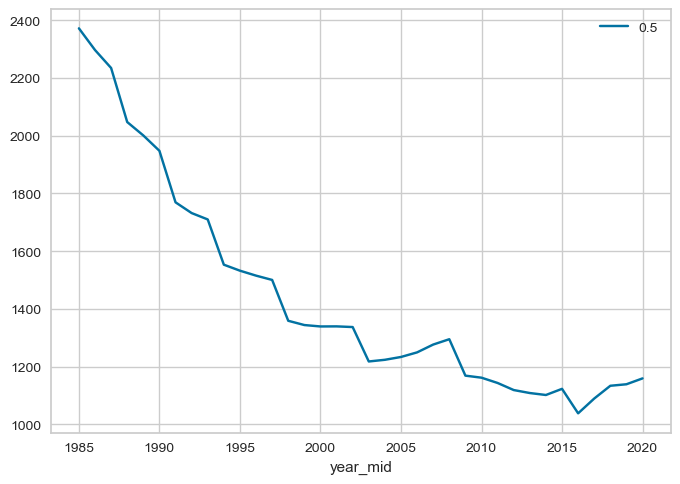

Country: MEX RMSE=14526.502 R2=0.896 Model=poisson_regression
Best RMSE=14526.502 Model=PoissonRegressor()


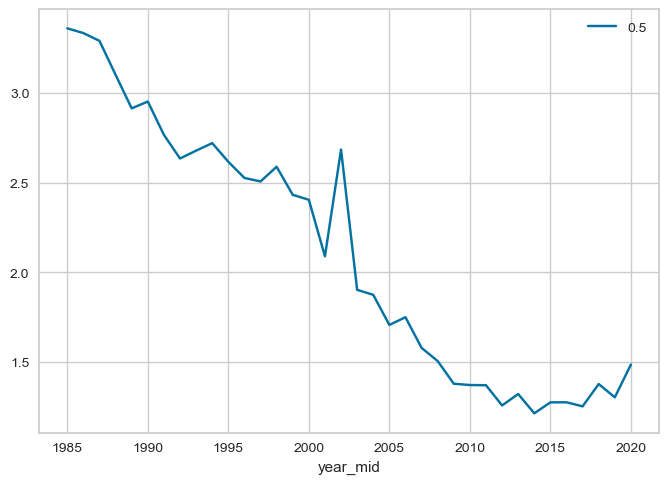

Country: FSM RMSE=0.157 R2=0.785 Model=poisson_regression
Country: FSM RMSE=0.107 R2=0.854 Model=bayesian_ard_regression
Best RMSE=0.107 Model=Pipeline(steps=[('model', ARDRegression())])


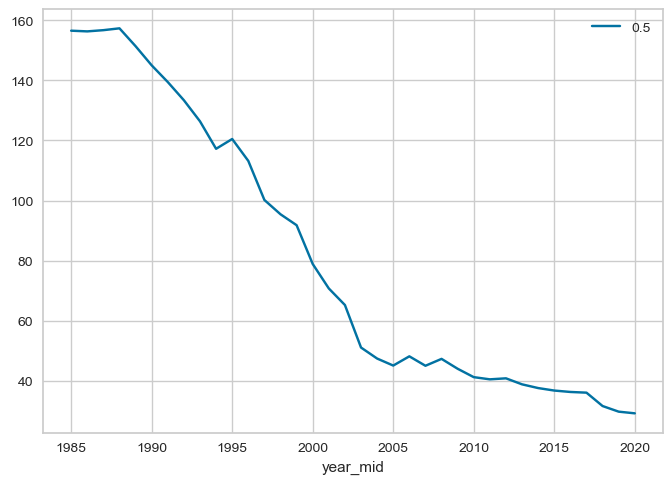

Country: MNG RMSE=84.985 R2=0.959 Model=poisson_regression
Best RMSE=84.985 Model=PoissonRegressor()


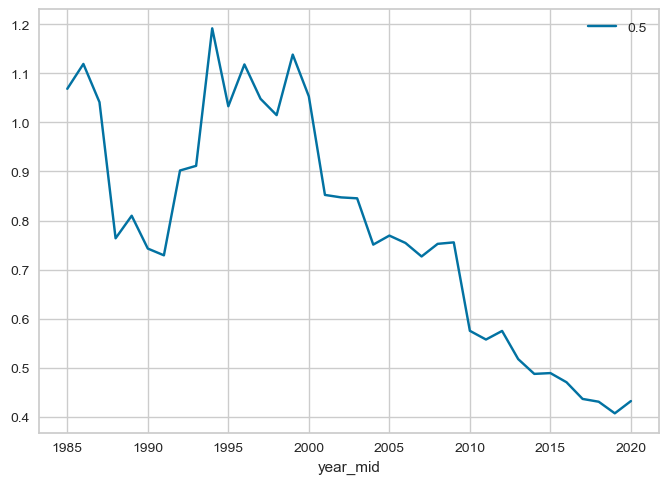

Country: MNE RMSE=0.095 R2=0.329 Model=poisson_regression
Country: MNE RMSE=0.082 R2=0.426 Model=bayesian_ard_regression
Best RMSE=0.082 Model=Pipeline(steps=[('model', ARDRegression())])


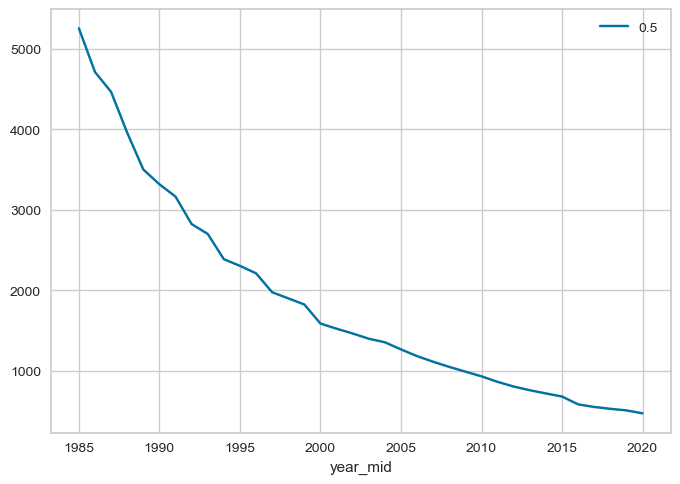

Country: MAR RMSE=15817.668 R2=0.990 Model=poisson_regression
Best RMSE=15817.668 Model=PoissonRegressor()


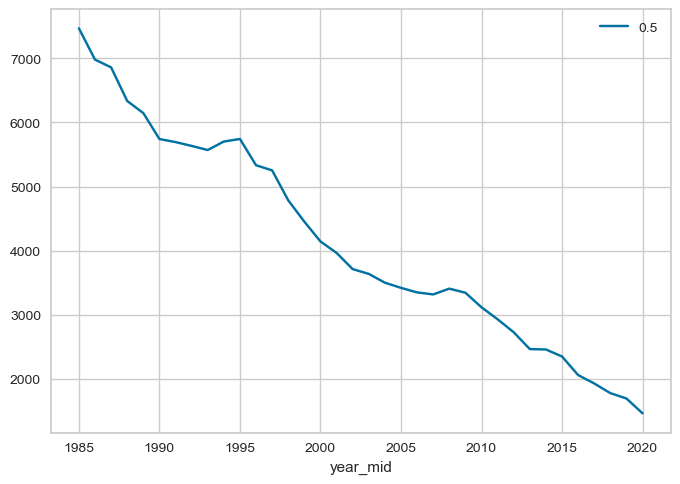

Country: MOZ RMSE=68162.982 R2=0.974 Model=poisson_regression
Country: MOZ RMSE=67907.703 R2=0.974 Model=bayesian_ard_regression
Best RMSE=67907.703 Model=Pipeline(steps=[('model', ARDRegression())])


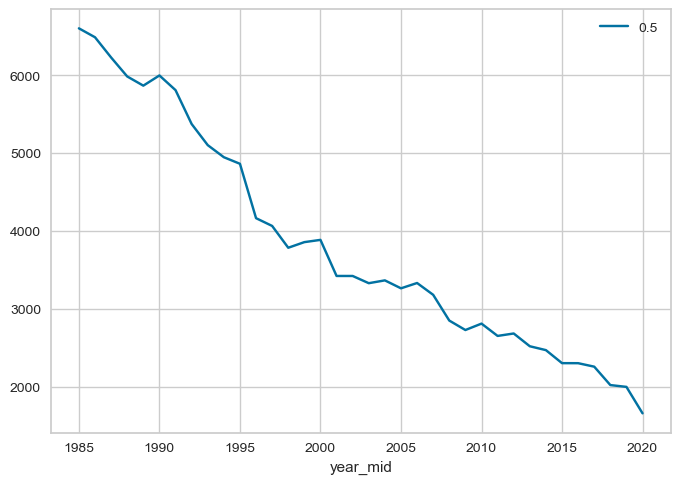

Country: MMR RMSE=33756.977 R2=0.983 Model=poisson_regression
Best RMSE=33756.977 Model=PoissonRegressor()


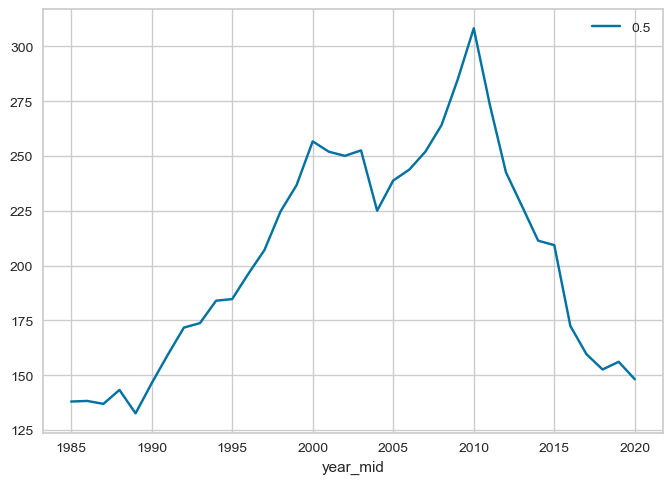

Country: NAM RMSE=1999.351 R2=0.151 Model=gamma_regression
Country: NAM RMSE=1880.013 R2=0.202 Model=bayesian_ard_regression
Best RMSE=1880.013 Model=Pipeline(steps=[('model', ARDRegression())])


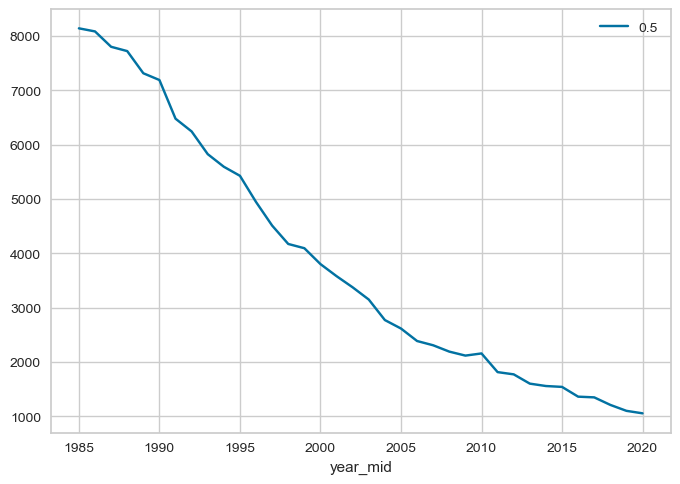

Country: NPL RMSE=61766.814 R2=0.988 Model=poisson_regression
Best RMSE=61766.814 Model=PoissonRegressor()


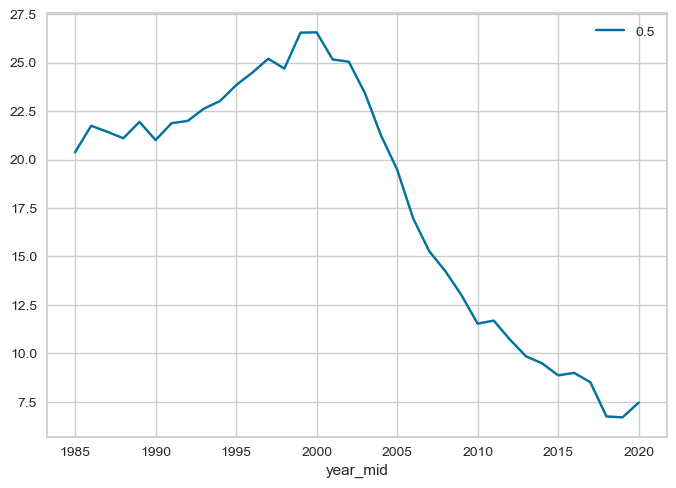

Country: NLD RMSE=18.644 R2=0.538 Model=poisson_regression
Country: NLD RMSE=14.159 R2=0.649 Model=bayesian_ard_regression
Best RMSE=14.159 Model=Pipeline(steps=[('model', ARDRegression())])


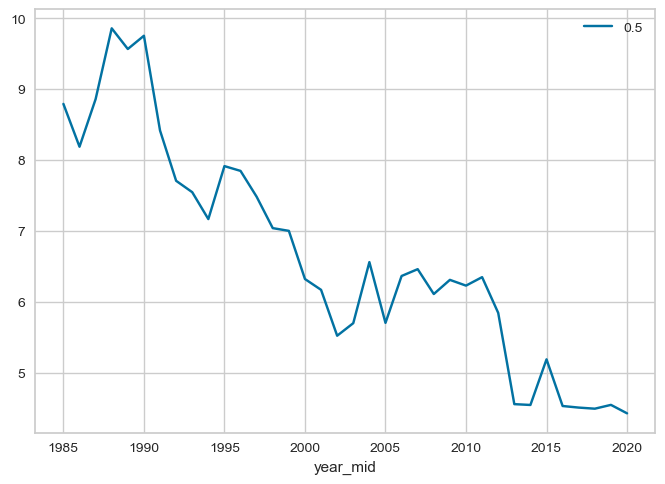

Country: NZL RMSE=0.358 R2=0.851 Model=poisson_regression
Best RMSE=0.358 Model=PoissonRegressor()


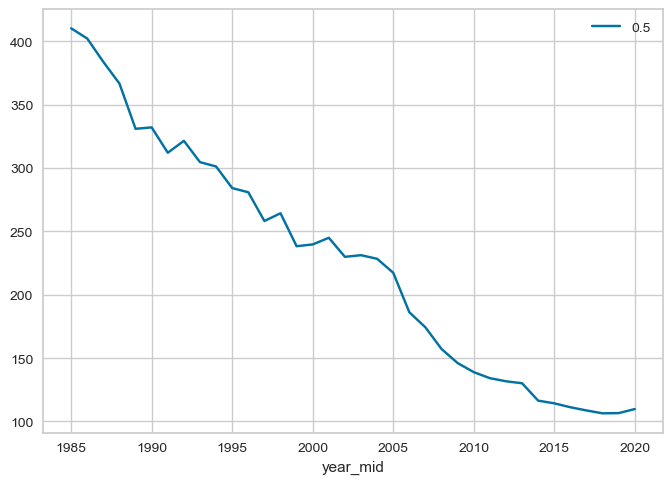

Country: NIC RMSE=198.841 R2=0.977 Model=poisson_regression
Best RMSE=198.841 Model=PoissonRegressor()


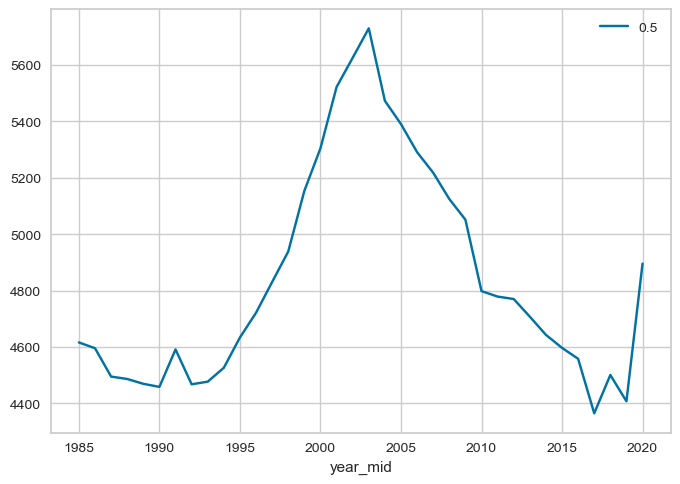

Country: NER RMSE=149398.958 R2=0.000 Model=poisson_regression
Country: NER RMSE=149398.900 R2=0.000 Model=gamma_regression
Country: NER RMSE=149397.476 R2=0.000 Model=bayesian_ard_regression
Best RMSE=149397.476 Model=Pipeline(steps=[('model', ARDRegression())])


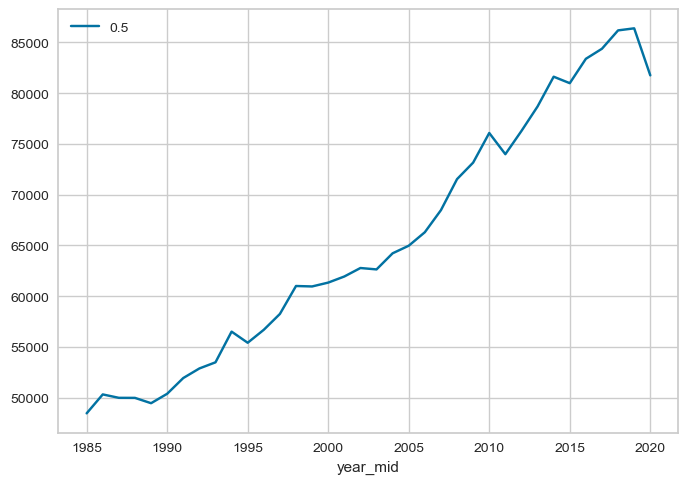

Country: NGA RMSE=1799628.879 R2=0.987 Model=gamma_regression
Best RMSE=1799628.879 Model=Pipeline(steps=[('model', GammaRegressor())])


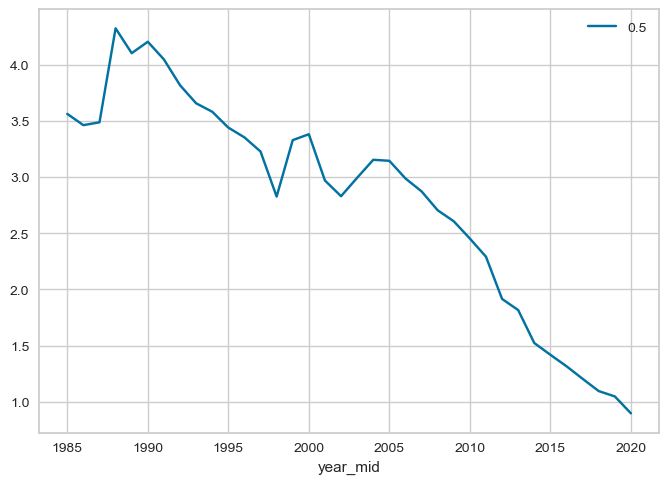

Country: NOR RMSE=0.285 R2=0.684 Model=poisson_regression
Country: NOR RMSE=0.217 R2=0.760 Model=huber_regression
Country: NOR RMSE=0.211 R2=0.766 Model=bayesian_ard_regression
Best RMSE=0.211 Model=Pipeline(steps=[('model', ARDRegression())])


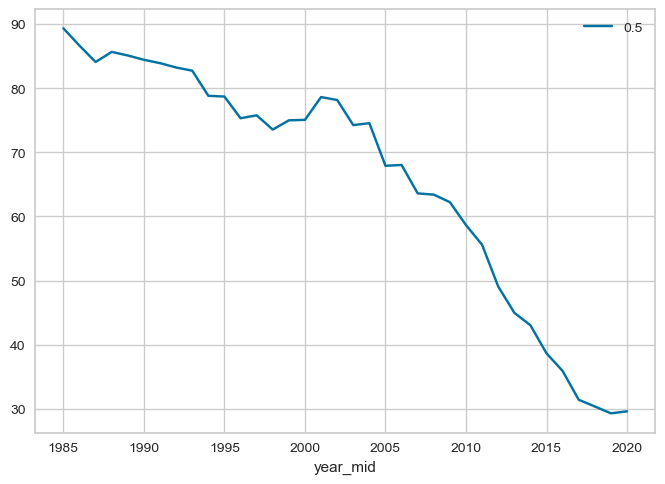

Country: PSE RMSE=63.434 R2=0.805 Model=poisson_regression
Country: PSE RMSE=38.877 R2=0.881 Model=bayesian_ard_regression
Best RMSE=38.877 Model=Pipeline(steps=[('model', ARDRegression())])


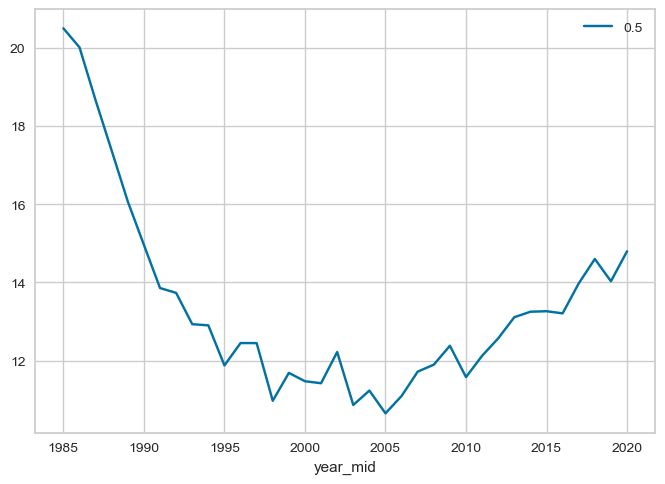

Country: OMN RMSE=4.295 R2=0.269 Model=poisson_regression
Best RMSE=4.295 Model=PoissonRegressor()


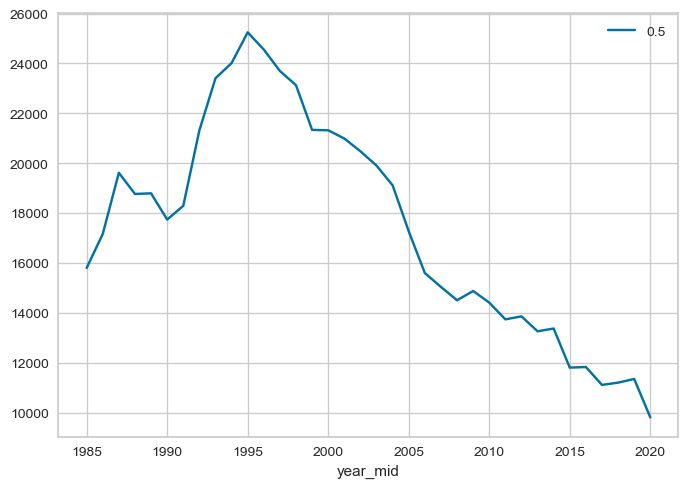

Country: PAK RMSE=9913379.101 R2=0.442 Model=poisson_regression
Country: PAK RMSE=8832239.257 R2=0.503 Model=bayesian_ard_regression
Best RMSE=8832239.257 Model=Pipeline(steps=[('model', ARDRegression())])


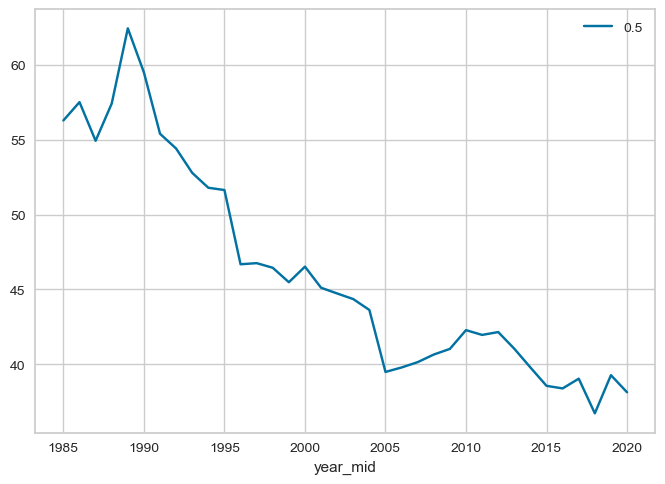

Country: PAN RMSE=5.424 R2=0.890 Model=poisson_regression
Best RMSE=5.424 Model=PoissonRegressor()


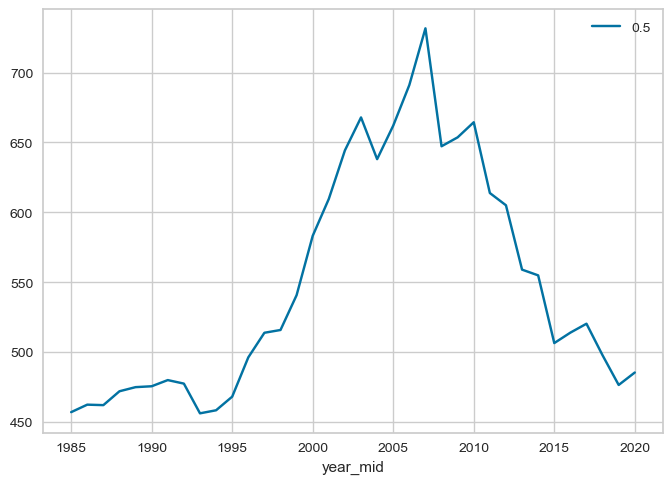

Country: PNG RMSE=5405.955 R2=0.193 Model=gamma_regression
Country: PNG RMSE=5268.117 R2=0.214 Model=bayesian_ard_regression
Best RMSE=5268.117 Model=Pipeline(steps=[('model', ARDRegression())])


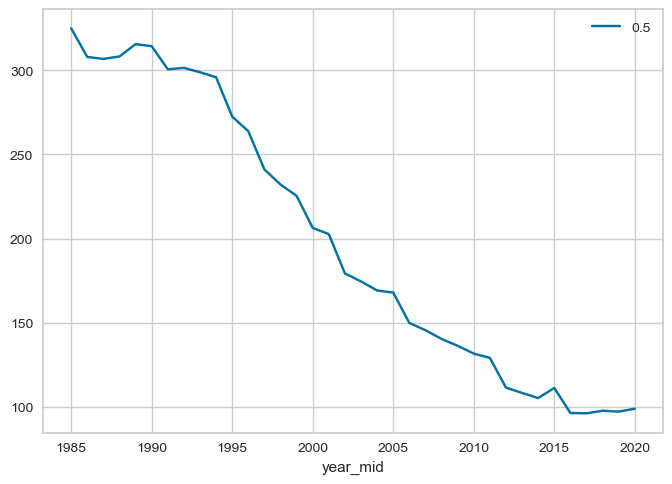

Country: PRY RMSE=339.597 R2=0.948 Model=poisson_regression
Country: PRY RMSE=234.896 R2=0.964 Model=bayesian_ard_regression
Best RMSE=234.896 Model=Pipeline(steps=[('model', ARDRegression())])


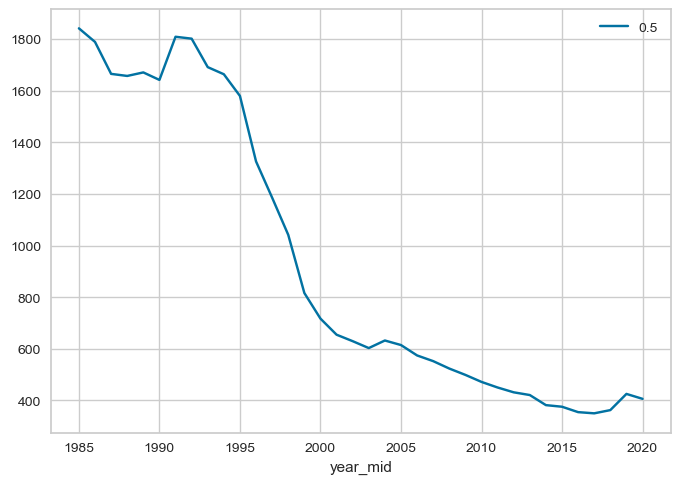

Country: PER RMSE=31506.509 R2=0.899 Model=poisson_regression
Best RMSE=31506.509 Model=PoissonRegressor()


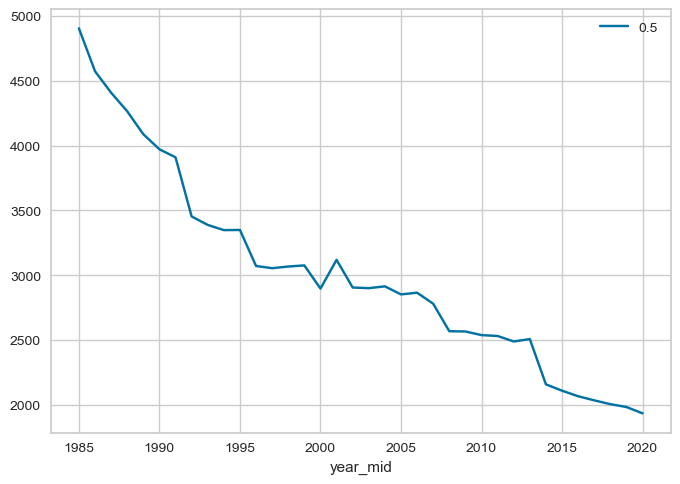

Country: PHL RMSE=30591.040 R2=0.946 Model=poisson_regression
Best RMSE=30591.040 Model=PoissonRegressor()


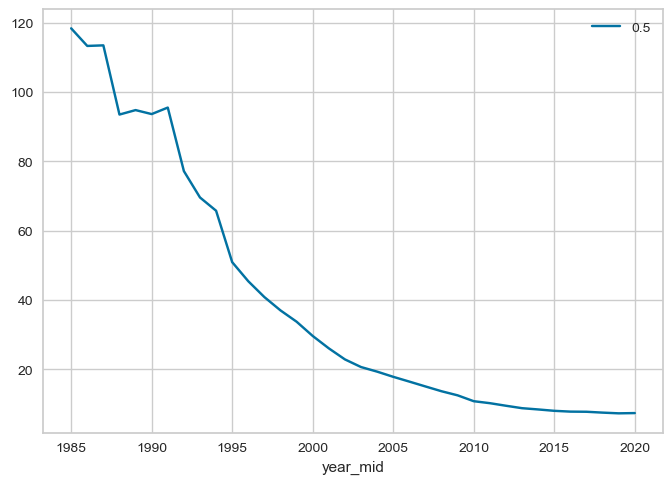

Country: POL RMSE=36.070 R2=0.973 Model=poisson_regression
Best RMSE=36.070 Model=PoissonRegressor()


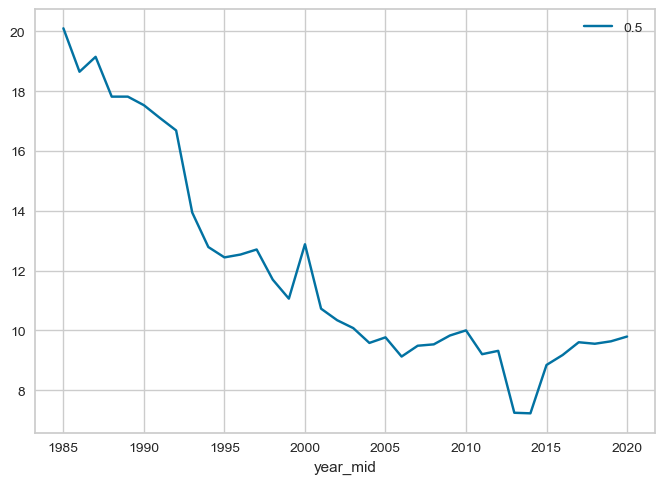

Country: PRT RMSE=1.835 R2=0.864 Model=poisson_regression
Best RMSE=1.835 Model=PoissonRegressor()


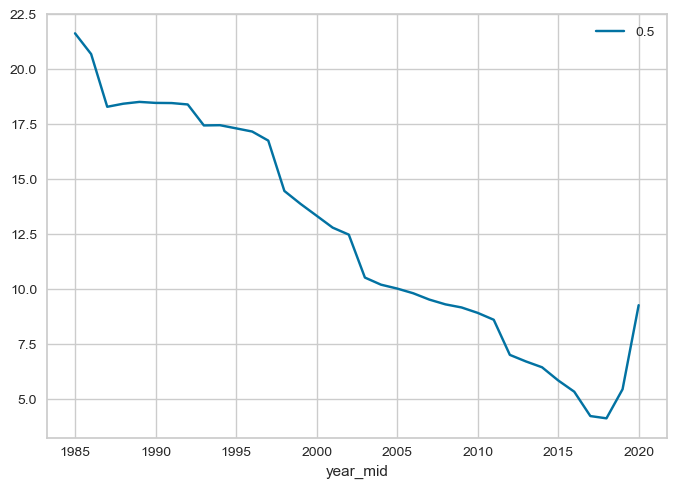

Country: PRI RMSE=1.701 R2=0.937 Model=poisson_regression
Country: PRI RMSE=0.707 R2=0.974 Model=bayesian_ard_regression
Best RMSE=0.707 Model=Pipeline(steps=[('model', ARDRegression())])


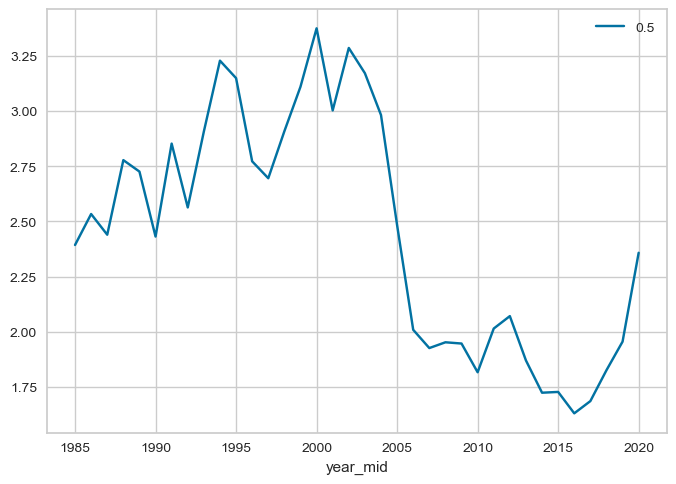

Country: QAT RMSE=0.166 R2=0.334 Model=poisson_regression
Country: QAT RMSE=0.160 R2=0.359 Model=bayesian_ard_regression
Best RMSE=0.160 Model=Pipeline(steps=[('model', ARDRegression())])


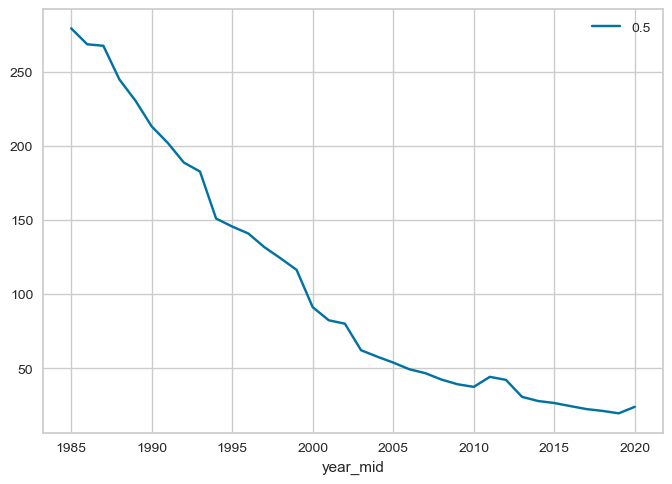

Country: KOR RMSE=105.690 R2=0.985 Model=poisson_regression
Best RMSE=105.690 Model=PoissonRegressor()


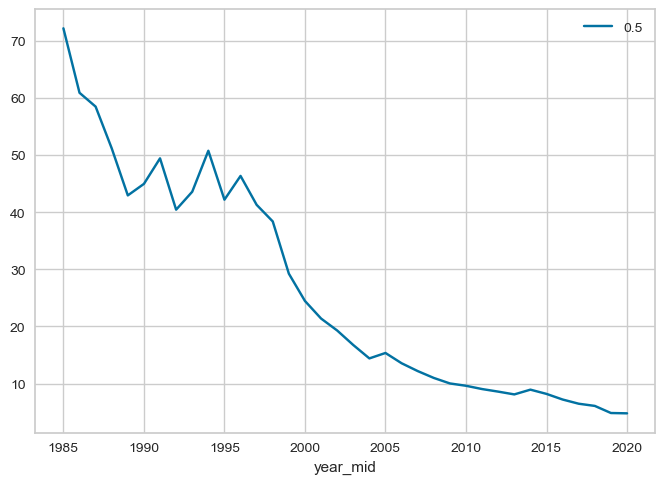

Country: MDA RMSE=29.179 R2=0.921 Model=poisson_regression
Best RMSE=29.179 Model=PoissonRegressor()


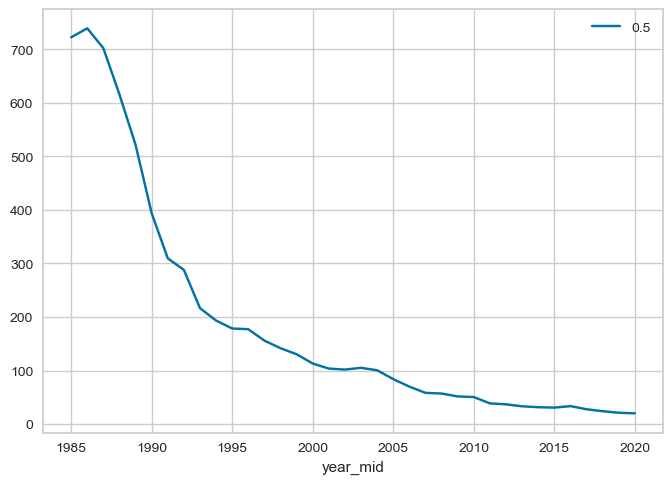

Country: ROU RMSE=1552.341 R2=0.965 Model=poisson_regression
Best RMSE=1552.341 Model=PoissonRegressor()


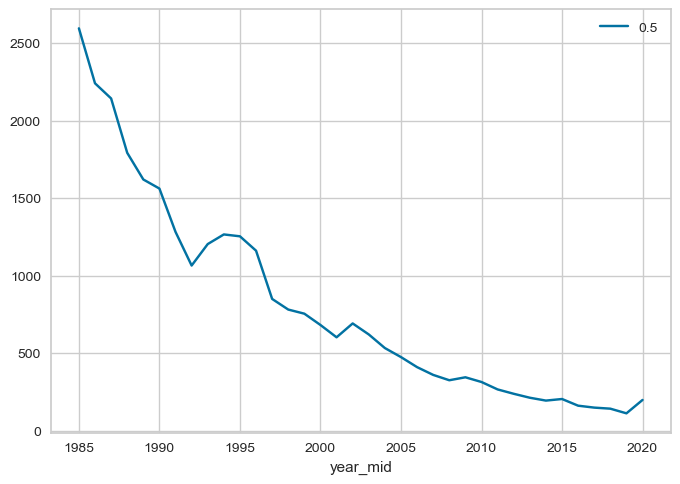

Country: RUS RMSE=8618.788 R2=0.980 Model=poisson_regression
Best RMSE=8618.788 Model=PoissonRegressor()


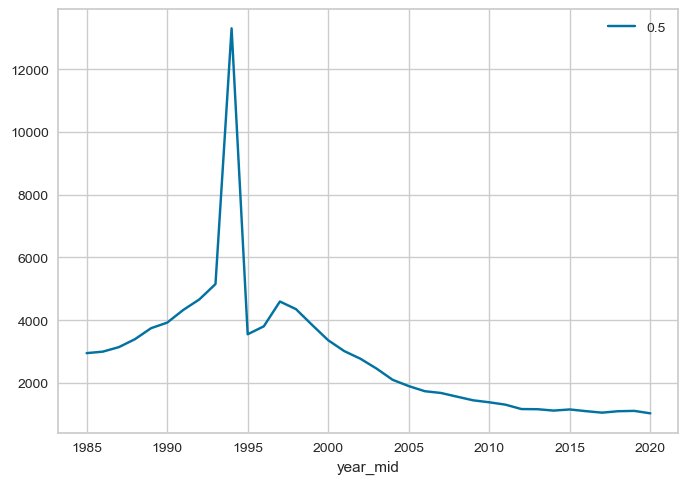

Country: RWA RMSE=3444054.507 R2=0.276 Model=poisson_regression
Country: RWA RMSE=3112662.786 R2=0.346 Model=bayesian_ard_regression
Best RMSE=3112662.786 Model=Pipeline(steps=[('model', ARDRegression())])


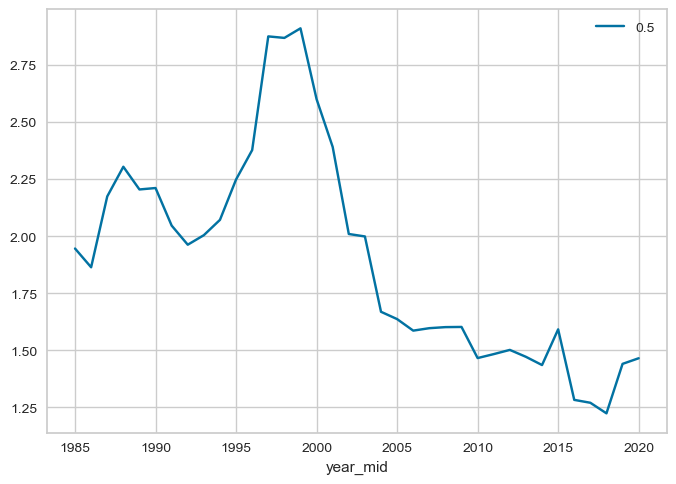

Country: LCA RMSE=0.237 R2=0.280 Model=poisson_regression
Country: LCA RMSE=0.228 R2=0.309 Model=huber_regression
Country: LCA RMSE=0.222 R2=0.325 Model=bayesian_ard_regression
Best RMSE=0.222 Model=Pipeline(steps=[('model', ARDRegression())])


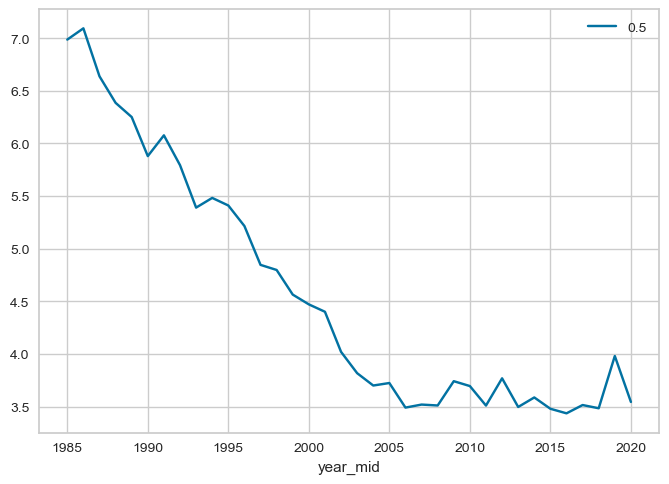

Country: WSM RMSE=0.201 R2=0.848 Model=poisson_regression
Best RMSE=0.201 Model=PoissonRegressor()


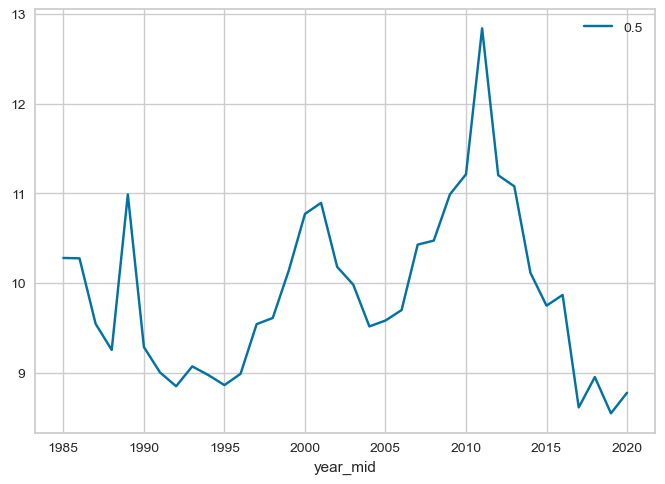

Country: STP RMSE=0.771 R2=0.000 Model=gamma_regression
Country: STP RMSE=0.765 R2=0.007 Model=huber_regression
Country: STP RMSE=0.733 R2=0.048 Model=bayesian_ard_regression
Best RMSE=0.733 Model=Pipeline(steps=[('model', ARDRegression())])


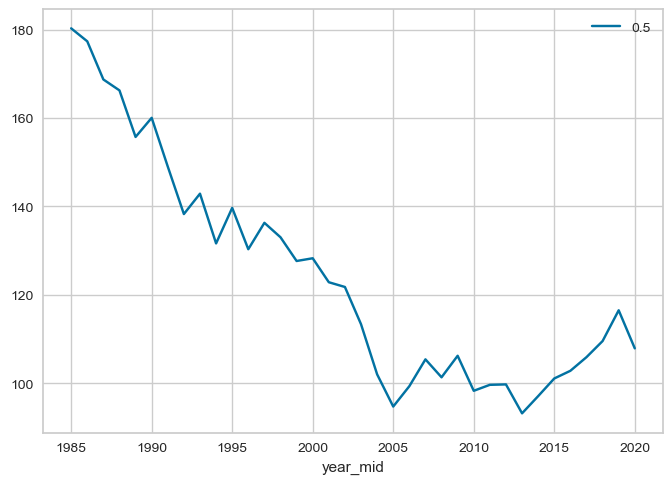

Country: SAU RMSE=95.440 R2=0.849 Model=poisson_regression
Best RMSE=95.440 Model=PoissonRegressor()


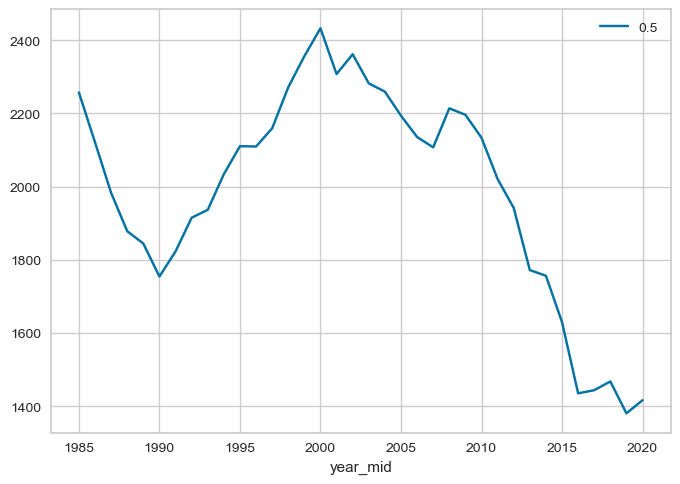

Country: SEN RMSE=65925.112 R2=0.160 Model=poisson_regression
Country: SEN RMSE=64943.380 R2=0.173 Model=bayesian_ard_regression
Best RMSE=64943.380 Model=Pipeline(steps=[('model', ARDRegression())])


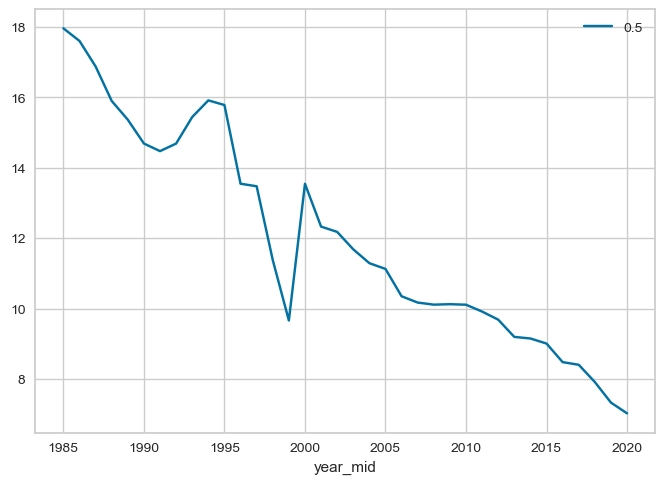

Country: SRB RMSE=0.816 R2=0.913 Model=poisson_regression
Best RMSE=0.816 Model=PoissonRegressor()


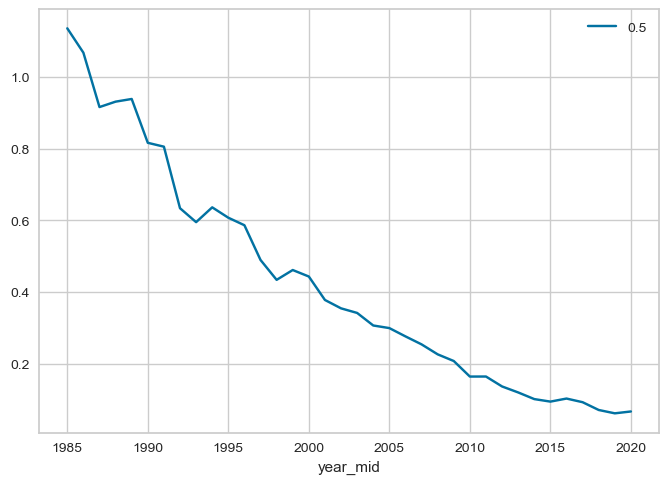

Country: SYC RMSE=0.080 R2=0.646 Model=poisson_regression
Country: SYC RMSE=0.073 R2=0.676 Model=bayesian_ard_regression
Best RMSE=0.073 Model=Pipeline(steps=[('model', ARDRegression())])


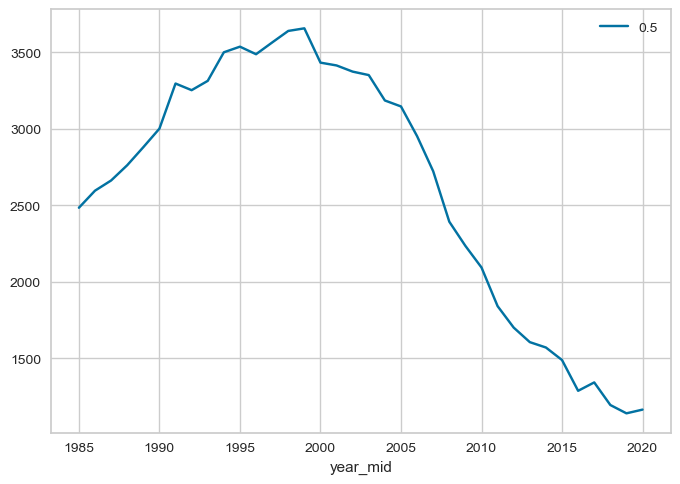

Country: SLE RMSE=386079.751 R2=0.412 Model=poisson_regression
Country: SLE RMSE=330690.884 R2=0.496 Model=huber_regression
Country: SLE RMSE=322915.611 R2=0.508 Model=bayesian_ard_regression
Best RMSE=322915.611 Model=Pipeline(steps=[('model', ARDRegression())])


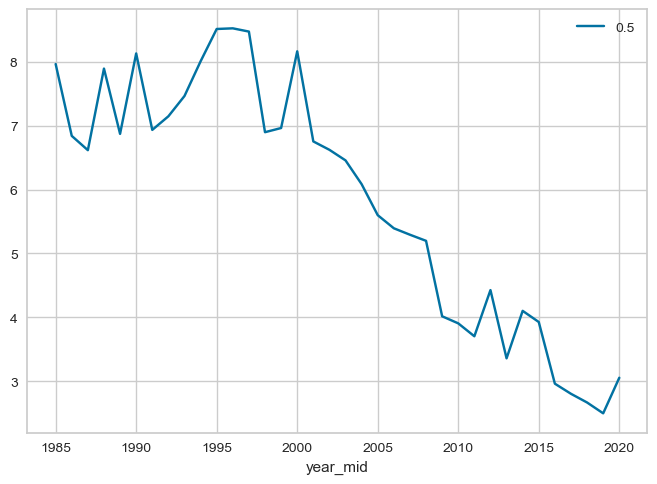

Country: SGP RMSE=1.119 R2=0.701 Model=poisson_regression
Country: SGP RMSE=0.797 R2=0.787 Model=bayesian_ard_regression
Best RMSE=0.797 Model=Pipeline(steps=[('model', ARDRegression())])


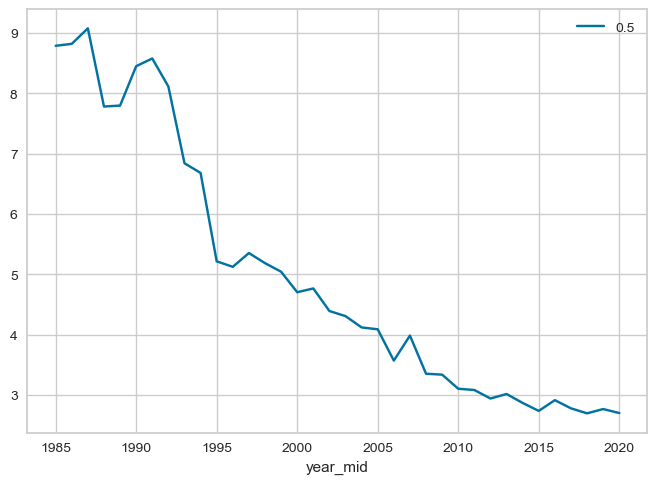

Country: SVK RMSE=0.312 R2=0.933 Model=poisson_regression
Best RMSE=0.312 Model=PoissonRegressor()


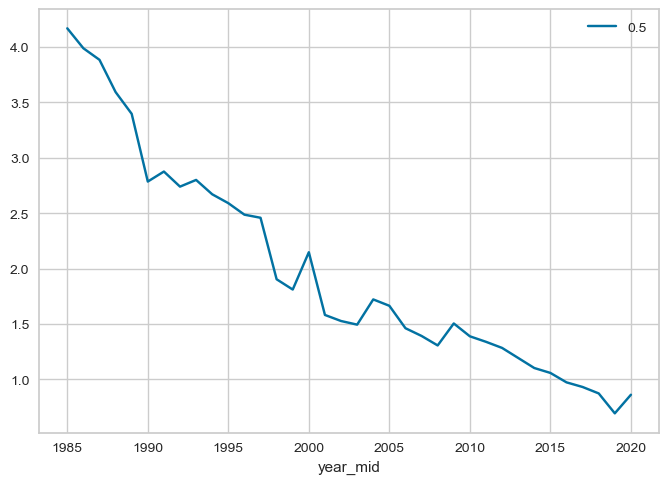

Country: SVN RMSE=0.095 R2=0.910 Model=poisson_regression
Best RMSE=0.095 Model=PoissonRegressor()


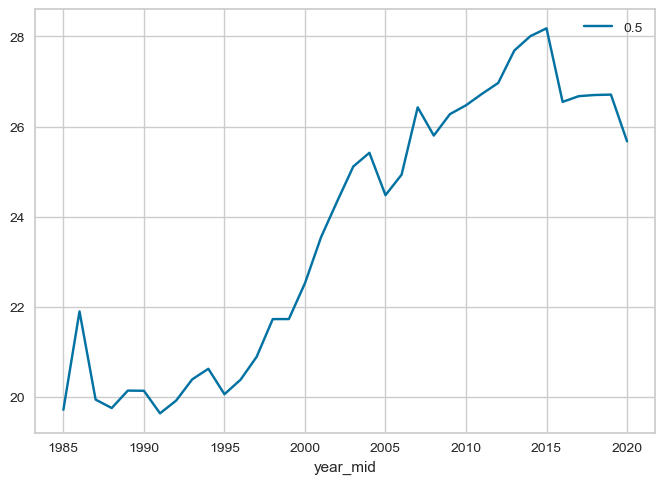

Country: SLB RMSE=0.971 R2=0.890 Model=gamma_regression
Country: SLB RMSE=0.969 R2=0.890 Model=bayesian_ard_regression
Best RMSE=0.969 Model=Pipeline(steps=[('model', ARDRegression())])


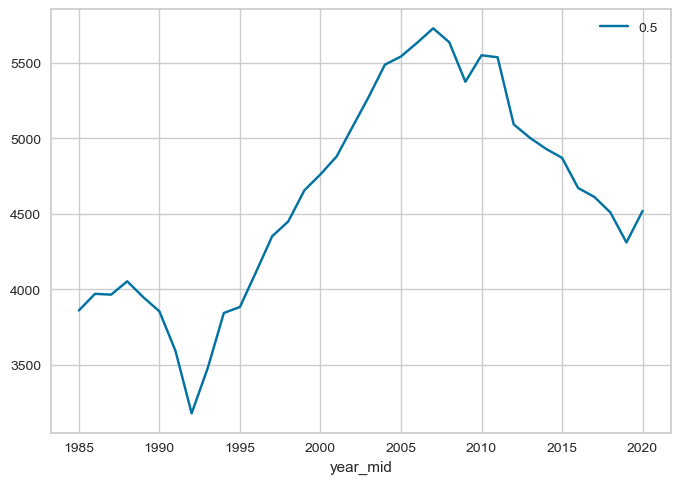

Country: SOM RMSE=297791.131 R2=0.394 Model=gamma_regression
Country: SOM RMSE=282260.335 R2=0.426 Model=bayesian_ard_regression
Country: SOM RMSE=282260.335 R2=0.426 Model=bayesian_ridge_regression
Best RMSE=282260.335 Model=Pipeline(steps=[('model', BayesianRidge())])


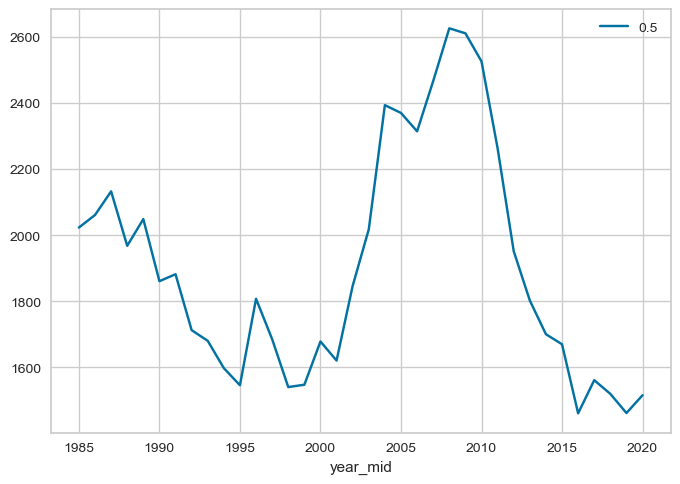

Country: ZAF RMSE=118038.198 R2=0.000 Model=poisson_regression
Country: ZAF RMSE=118038.131 R2=0.000 Model=bayesian_ard_regression
Best RMSE=118038.131 Model=Pipeline(steps=[('model', ARDRegression())])


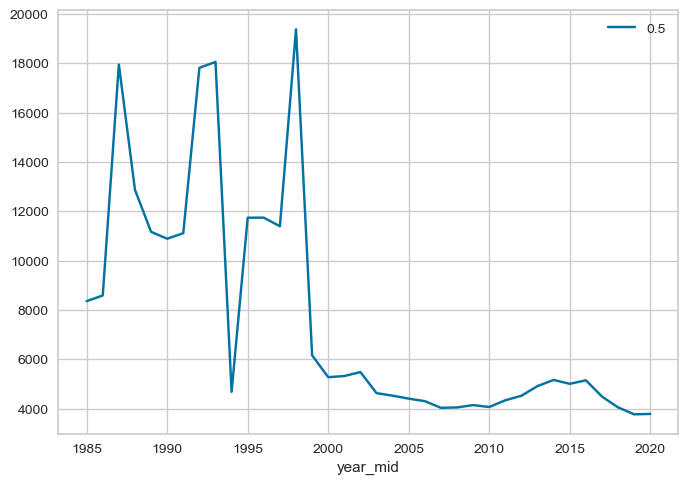

Country: SSD RMSE=11658837.878 R2=0.470 Model=poisson_regression
Country: SSD RMSE=11546020.541 R2=0.475 Model=bayesian_ard_regression
Best RMSE=11546020.541 Model=Pipeline(steps=[('model', ARDRegression())])


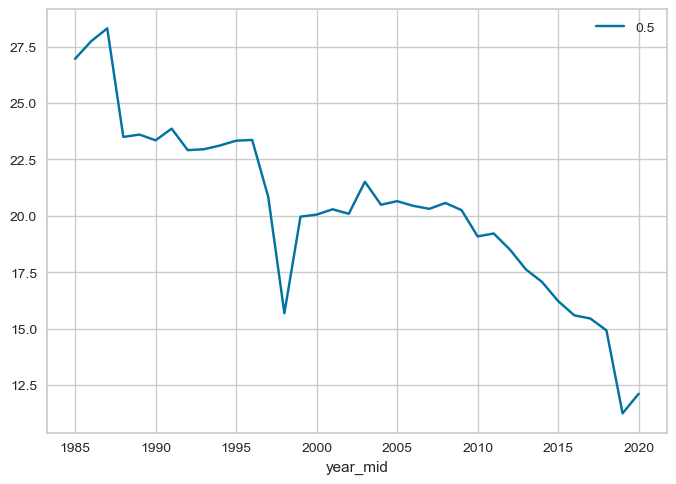

Country: ESP RMSE=2.930 R2=0.779 Model=poisson_regression
Country: ESP RMSE=2.878 R2=0.783 Model=bayesian_ard_regression
Best RMSE=2.878 Model=Pipeline(steps=[('model', ARDRegression())])


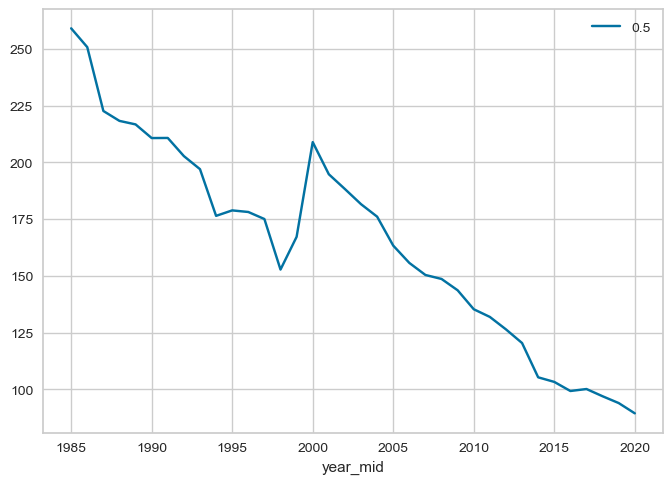

Country: LKA RMSE=225.717 R2=0.885 Model=poisson_regression
Country: LKA RMSE=192.286 R2=0.902 Model=bayesian_ard_regression
Country: LKA RMSE=192.286 R2=0.902 Model=bayesian_ridge_regression
Best RMSE=192.286 Model=Pipeline(steps=[('model', BayesianRidge())])


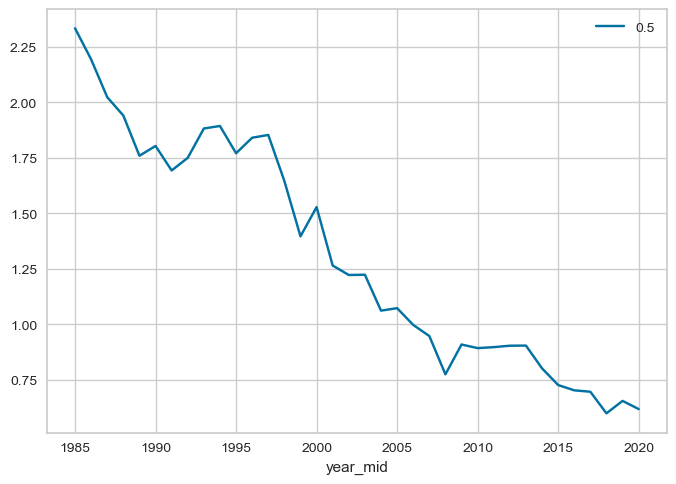

Country: VCT RMSE=0.063 R2=0.742 Model=poisson_regression
Best RMSE=0.063 Model=PoissonRegressor()


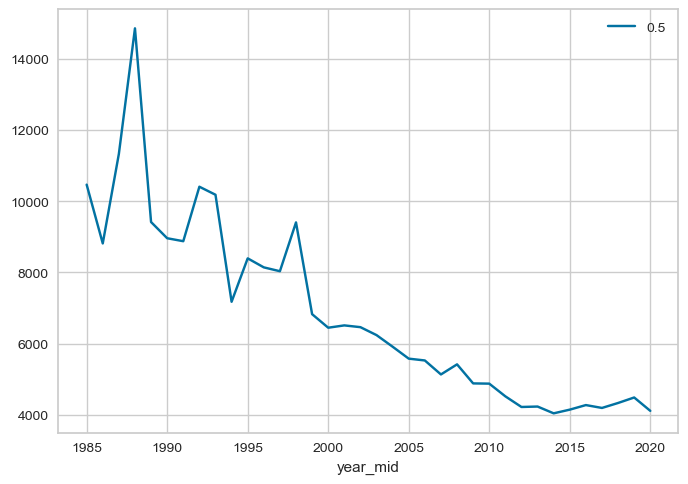

Country: SDN RMSE=1128523.903 R2=0.828 Model=poisson_regression
Best RMSE=1128523.903 Model=PoissonRegressor()


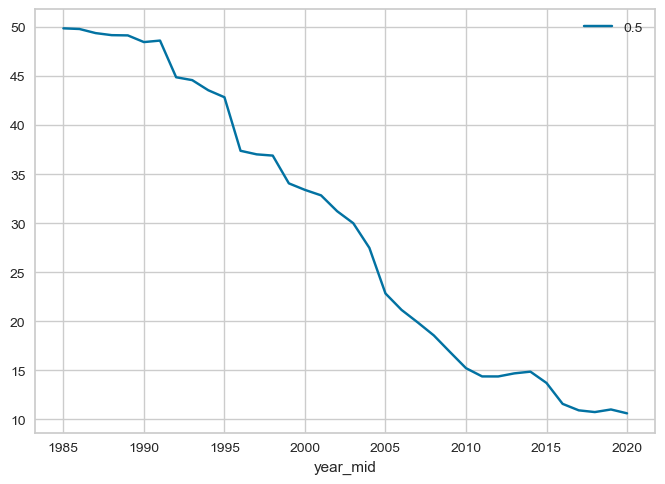

Country: SUR RMSE=13.363 R2=0.933 Model=poisson_regression
Country: SUR RMSE=5.612 R2=0.972 Model=bayesian_ard_regression
Country: SUR RMSE=5.612 R2=0.972 Model=bayesian_ridge_regression
Best RMSE=5.612 Model=Pipeline(steps=[('model', BayesianRidge())])


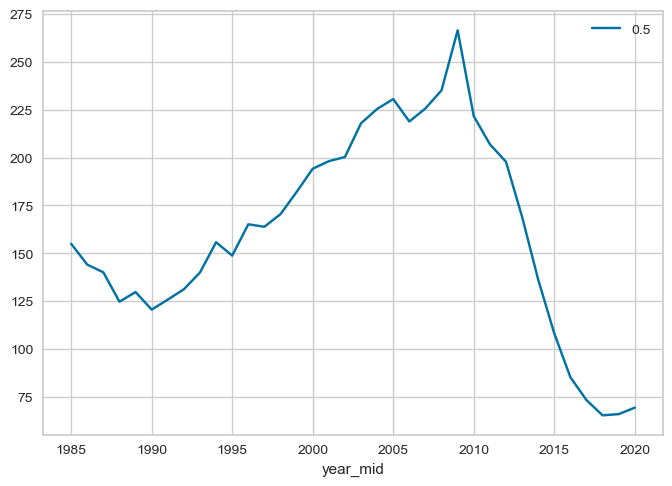

Country: SWZ RMSE=2582.142 R2=0.000 Model=poisson_regression
Country: SWZ RMSE=2582.140 R2=0.000 Model=bayesian_ard_regression
Best RMSE=2582.140 Model=Pipeline(steps=[('model', ARDRegression())])


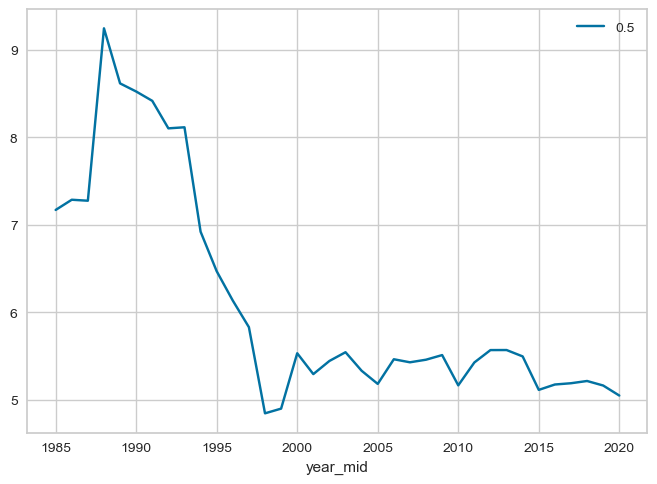

Country: SWE RMSE=0.688 R2=0.598 Model=poisson_regression
Best RMSE=0.688 Model=PoissonRegressor()


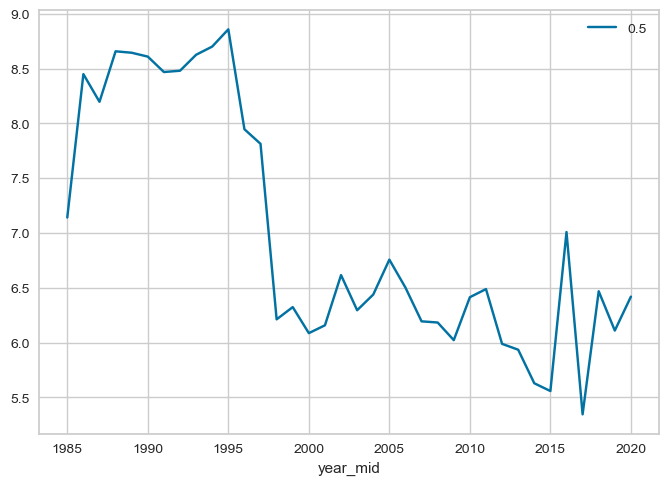

Country: CHE RMSE=0.595 R2=0.592 Model=poisson_regression
Best RMSE=0.595 Model=PoissonRegressor()


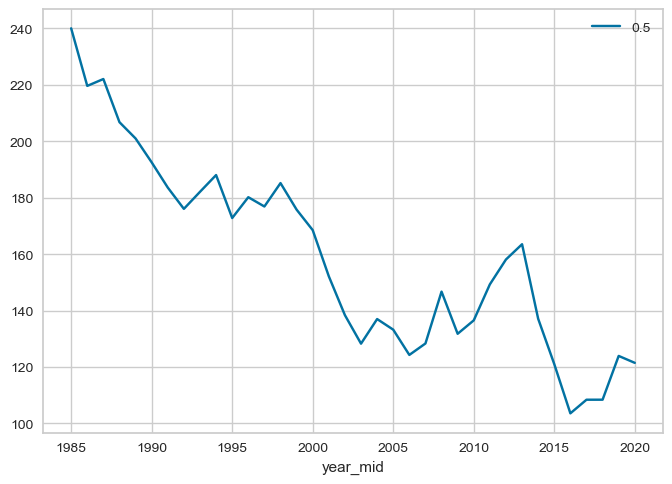

Country: SYR RMSE=195.509 R2=0.835 Model=poisson_regression
Best RMSE=195.509 Model=PoissonRegressor()


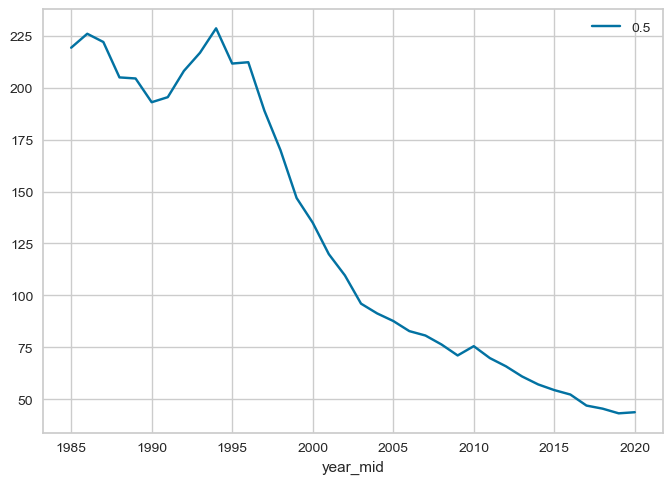

Country: TJK RMSE=579.508 R2=0.871 Model=poisson_regression
Country: TJK RMSE=387.725 R2=0.914 Model=bayesian_ard_regression
Best RMSE=387.725 Model=Pipeline(steps=[('model', ARDRegression())])


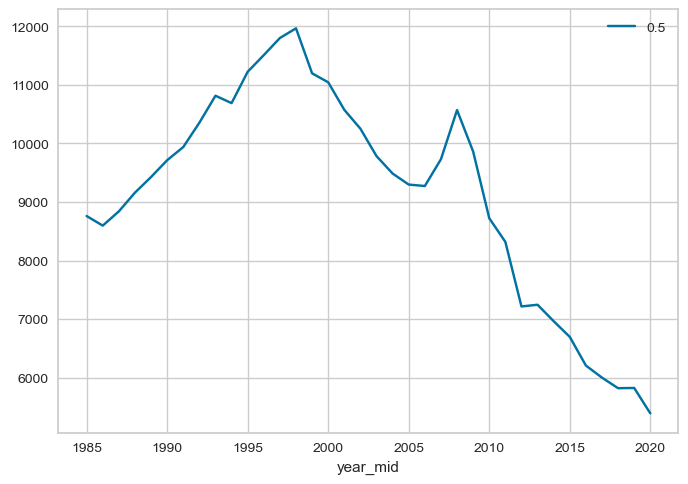

Country: TZA RMSE=1979186.715 R2=0.352 Model=poisson_regression
Country: TZA RMSE=1849128.022 R2=0.395 Model=huber_regression
Country: TZA RMSE=1830113.920 R2=0.401 Model=bayesian_ard_regression
Best RMSE=1830113.920 Model=Pipeline(steps=[('model', ARDRegression())])


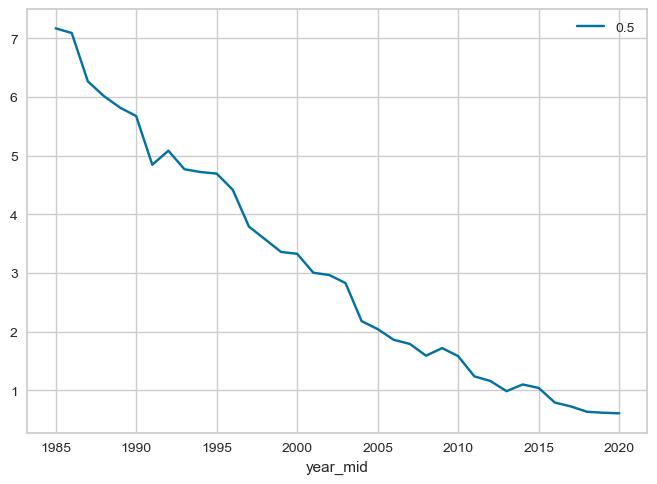

Country: MKD RMSE=0.136 R2=0.964 Model=poisson_regression
Best RMSE=0.136 Model=PoissonRegressor()


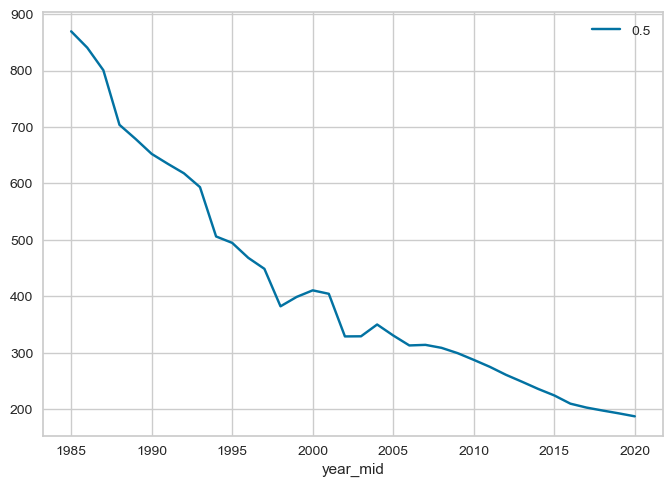

Country: THA RMSE=823.897 R2=0.978 Model=poisson_regression
Best RMSE=823.897 Model=PoissonRegressor()


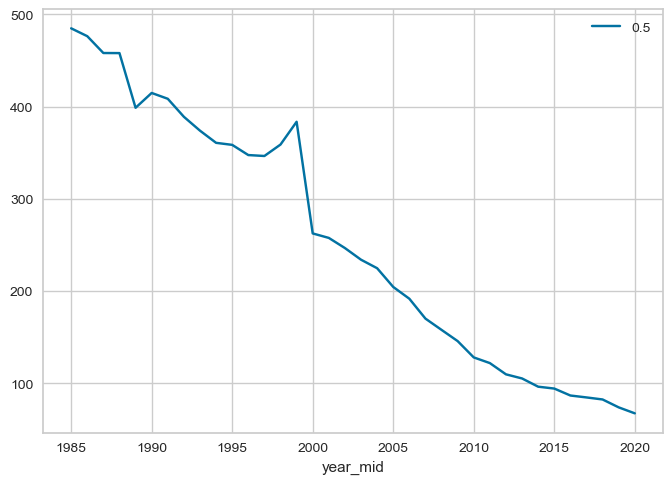

Country: TLS RMSE=1298.855 R2=0.929 Model=poisson_regression
Country: TLS RMSE=547.478 R2=0.970 Model=bayesian_ard_regression
Best RMSE=547.478 Model=Pipeline(steps=[('model', ARDRegression())])


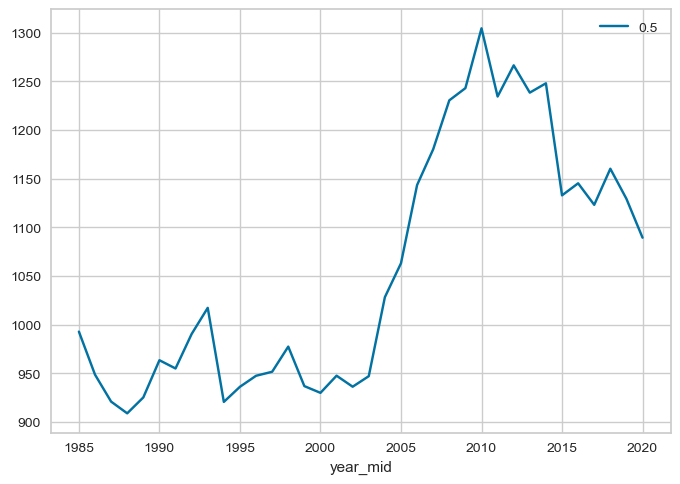

Country: TGO RMSE=5942.341 R2=0.627 Model=gamma_regression
Best RMSE=5942.341 Model=Pipeline(steps=[('model', GammaRegressor())])


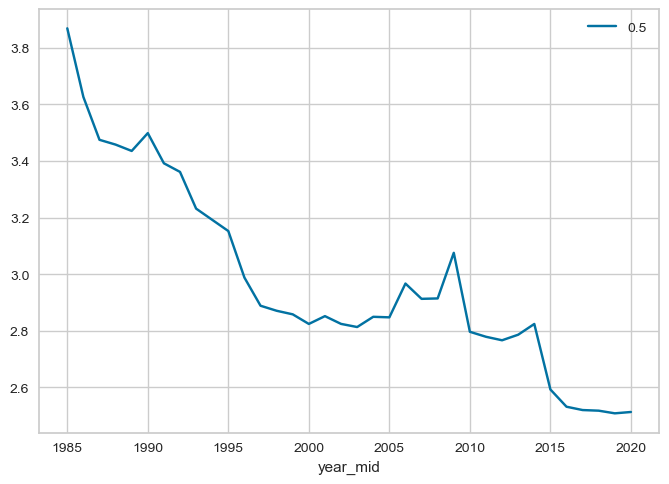

Country: TON RMSE=0.045 R2=0.167 Model=poisson_regression
Best RMSE=0.045 Model=PoissonRegressor()


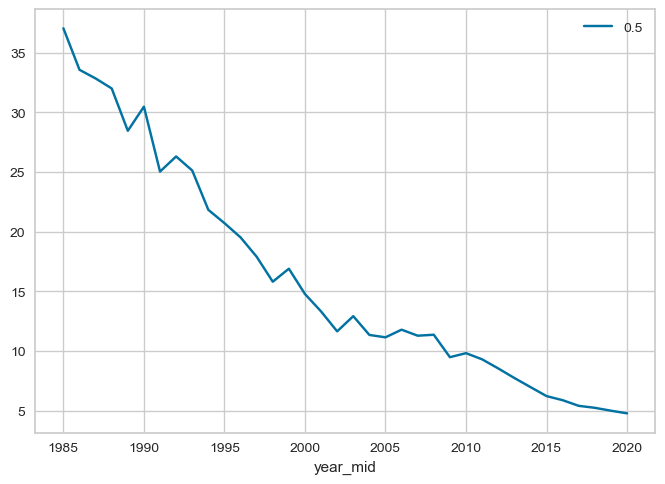

Country: TTO RMSE=0.989 R2=0.989 Model=poisson_regression
Best RMSE=0.989 Model=PoissonRegressor()


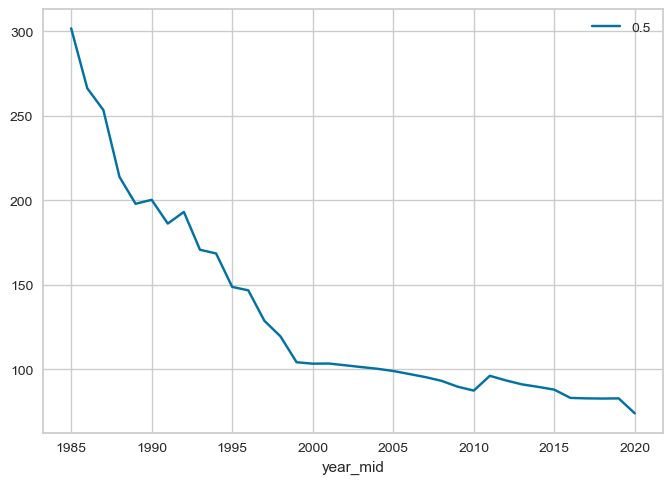

Country: TUN RMSE=374.745 R2=0.890 Model=poisson_regression
Best RMSE=374.745 Model=PoissonRegressor()


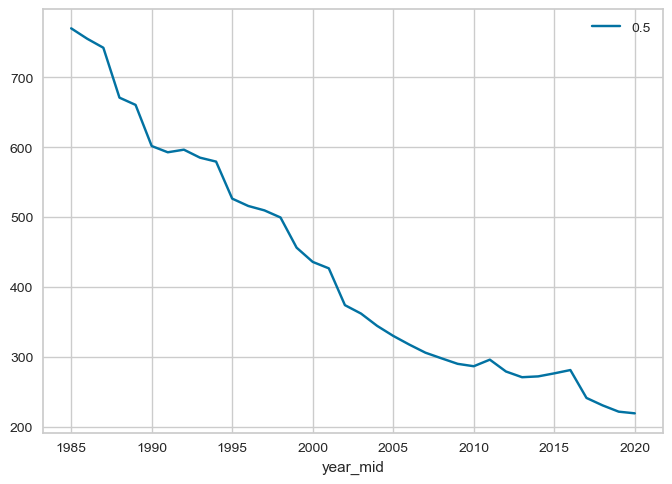

Country: TUR RMSE=443.060 R2=0.984 Model=poisson_regression
Best RMSE=443.060 Model=PoissonRegressor()


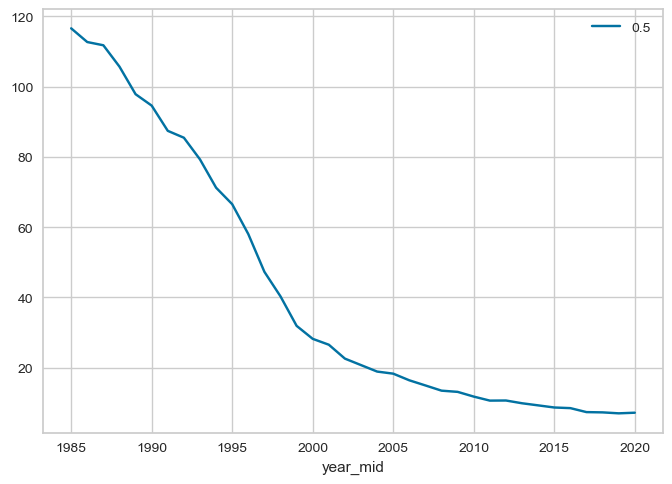

Country: TKM RMSE=50.965 R2=0.964 Model=poisson_regression
Best RMSE=50.965 Model=PoissonRegressor()


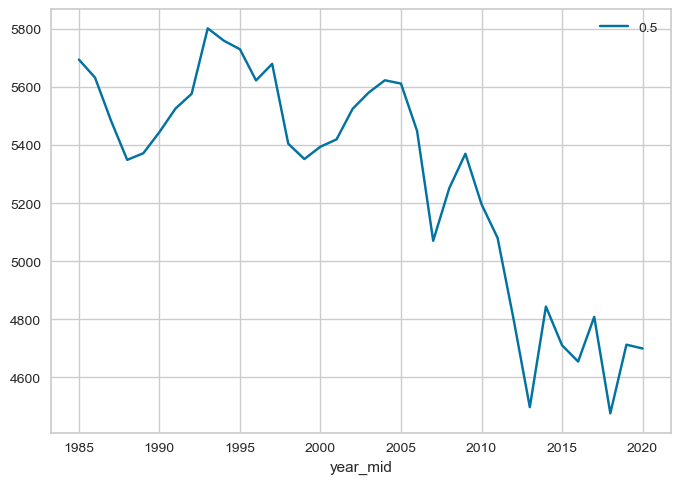

Country: UGA RMSE=142586.872 R2=0.000 Model=poisson_regression
Country: UGA RMSE=50803.217 R2=0.644 Model=bayesian_ard_regression
Best RMSE=50803.217 Model=Pipeline(steps=[('model', ARDRegression())])


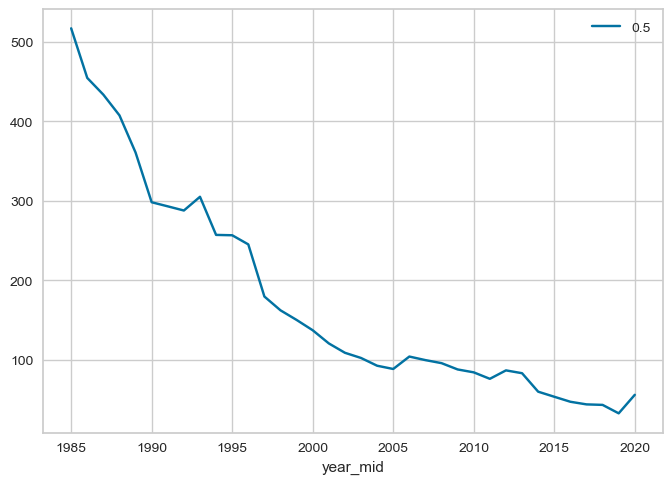

Country: UKR RMSE=347.972 R2=0.980 Model=poisson_regression
Best RMSE=347.972 Model=PoissonRegressor()


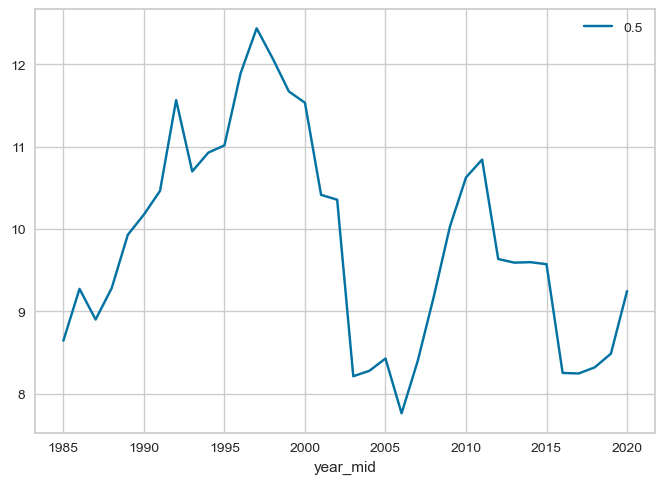

Country: ARE RMSE=1.764 R2=0.105 Model=poisson_regression
Best RMSE=1.764 Model=PoissonRegressor()


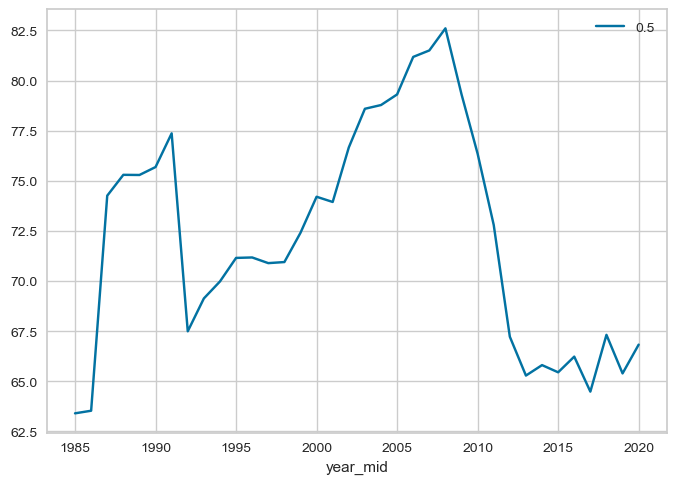

Country: GBR RMSE=32.274 R2=0.000 Model=poisson_regression
Country: GBR RMSE=32.257 R2=0.001 Model=bayesian_ard_regression
Best RMSE=32.257 Model=Pipeline(steps=[('model', ARDRegression())])


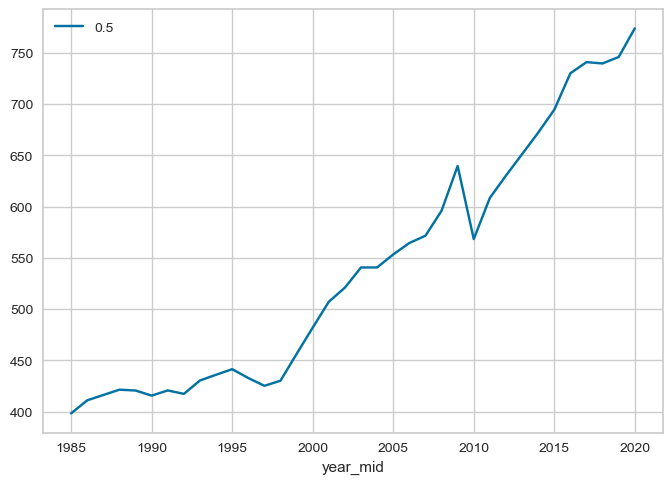

Country: USA RMSE=12737.669 R2=0.000 Model=poisson_regression
Country: USA RMSE=577.515 R2=0.955 Model=gamma_regression
Best RMSE=577.515 Model=Pipeline(steps=[('model', GammaRegressor())])


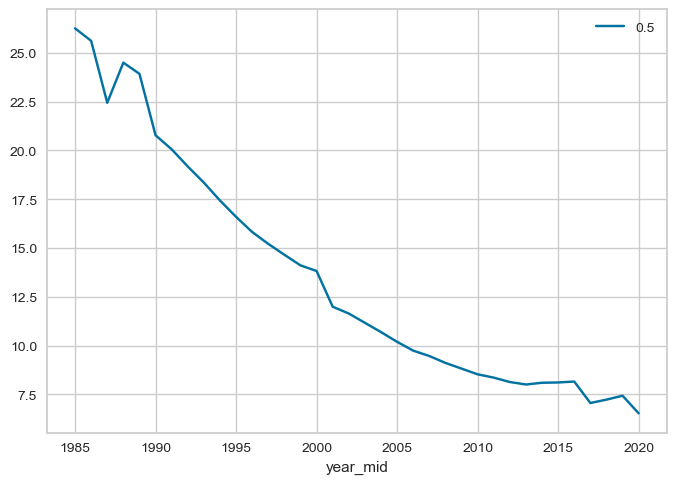

Country: URY RMSE=0.631 R2=0.982 Model=poisson_regression
Best RMSE=0.631 Model=PoissonRegressor()


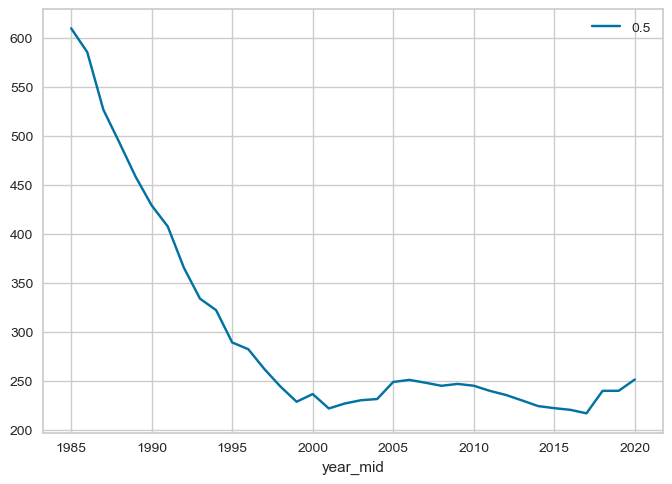

Country: UZB RMSE=3061.599 R2=0.746 Model=poisson_regression
Best RMSE=3061.599 Model=PoissonRegressor()


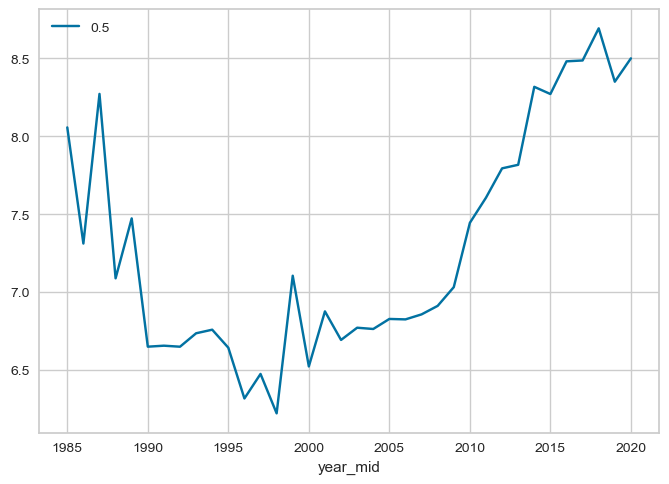

Country: VUT RMSE=0.420 R2=0.000 Model=gamma_regression
Country: VUT RMSE=0.313 R2=0.255 Model=bayesian_ard_regression
Country: VUT RMSE=0.313 R2=0.255 Model=bayesian_ridge_regression
Best RMSE=0.313 Model=Pipeline(steps=[('model', BayesianRidge())])


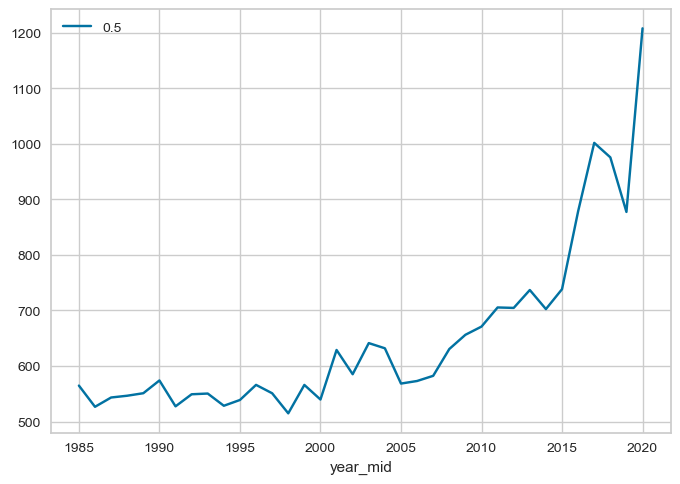

Country: VEN RMSE=4594.347 R2=0.708 Model=gamma_regression
Best RMSE=4594.347 Model=Pipeline(steps=[('model', GammaRegressor())])


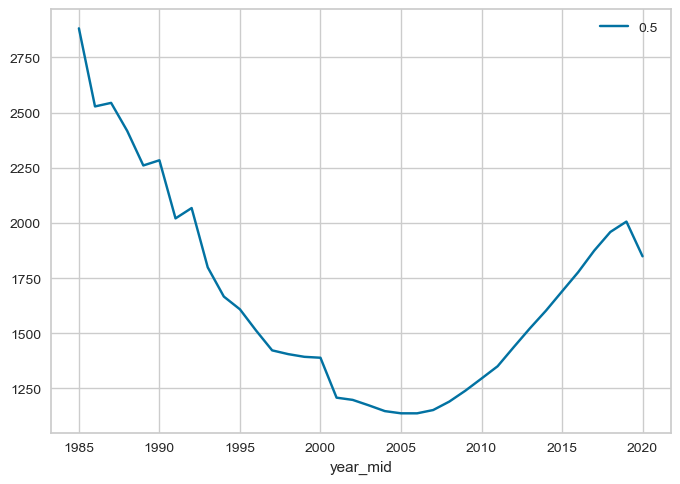

Country: VNM RMSE=147575.458 R2=0.324 Model=poisson_regression
Best RMSE=147575.458 Model=PoissonRegressor()


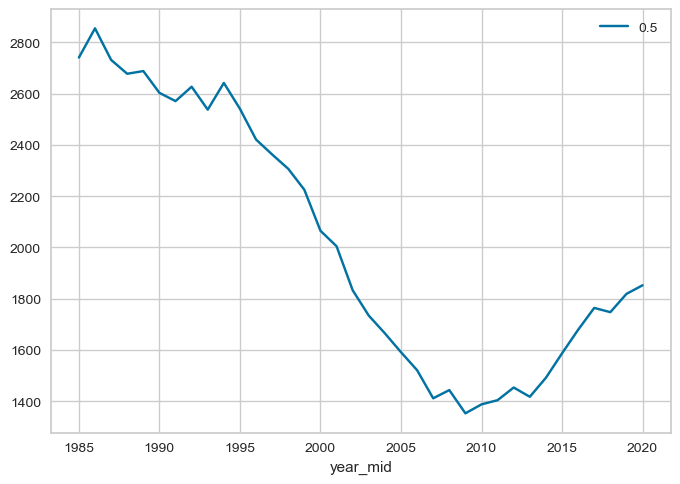

Country: YEM RMSE=44378.902 R2=0.827 Model=poisson_regression
Best RMSE=44378.902 Model=PoissonRegressor()


In [ ]:
df_average["value_col"] = df_average["round_0_5"]
combined_data_values = run_model(df_average, models)

In [ ]:
pd.set_option('display.float_format', lambda x:'%0.4f' % x)
# preds_normal = pd.concat(prediction_values, ignore_index=True)
# metrics_normal = pd.concat(model_metrics_test + model_metrics_train, axis=0, ignore_index=True)
combined_normal = pd.concat(combined_data_values, ignore_index=True).reset_index().drop(columns="index")

combined_normal["transform"] = "normal - no transformation"

### Include Country Name & Calculate Excess

In [ ]:
combined_normal = combined_normal[combined_normal["iso_code"] != "USA"]
combined_normal["country_name"] = combined_normal["iso_code"].apply(lambda x: iso_to_countryname(x))
combined_normal["continent"] = combined_normal["iso_code"].apply(lambda x: iso_to_continent(x))
combined_normal["value_col"]  = combined_normal["value_col"].round(0).astype(int)
combined_normal['excess'] = combined_normal["value_col"] - combined_normal['mid']
combined_normal["excess"] = combined_normal["excess"].apply(lambda x: 0 if x < 0 else x )
combined_normal["excess_category"] = combined_normal["excess"].apply(lambda x: excess_category(x))

### Export

In [ ]:
combined_normal.sort_values(by="excess").to_csv("./data/combined_normal_final_df.csv", index=False)

## Values Log Transformed

In [ ]:
models = [poisson_regression, svr_rbf_regression, gamma_regression, huber_regression, bayesian_ard_regression, bayesian_ridge_regression, QuantileRegressor, TheilSenRegressor]

In [ ]:
df_average["value_col"] = df_average['0.5'].apply(lambda x: math.log(x))
combined_data_values = run_model(df_average, models)

In [ ]:
pd.set_option('display.float_format', lambda x:'%0.4f' % x)
# preds_log = pd.concat(prediction_values, ignore_index=True)
# metrics_log = pd.concat(model_metrics_test + model_metrics_train, axis=0, ignore_index=True)
combined_log = pd.concat(combined_data_values, ignore_index=True).reset_index().drop(columns="index")

combined_log["transform"] = "log transform"
combined_log["value_col"] = np.exp(combined_log["value_col"]).round(0).astype(int)
combined_log["lower"] = np.exp(combined_log["lower"]).replace([np.inf, -np.inf, np.nan], 0).round(0).astype(int)
combined_log["mid"] = np.exp(combined_log["mid"]).replace([np.inf, -np.inf, np.nan], 0).round(0).astype(int)
combined_log["upper"] = np.exp(combined_log["upper"]).replace([np.inf, -np.inf, np.nan], 0).round(0).astype(int)
combined_log['excess'] = combined_log["value_col"] - combined_log['mid']

### Include Country Name & Calculate Excess

In [ ]:
combined_log = combined_log[combined_log["iso_code"] != "USA"]
combined_log["country_name"] = combined_log["iso_code"].apply(lambda x: iso_to_countryname(x))
combined_log["continent"] = combined_log["iso_code"].apply(lambda x: iso_to_continent(x))
combined_log["excess_category"] = combined_log["excess"].apply(lambda x: excess_category(x))
combined_log["excess"] = combined_log["excess"].apply(lambda x: 0 if x < 0 else x )

### Export

In [ ]:
combined_log.sort_values(by="excess").to_csv("./data/combined_log_final_df.csv", index=False)

## Values Divided by 100

In [ ]:
models = [poisson_regression, svr_rbf_regression, gamma_regression, bayesian_ard_regression, bayesian_ridge_regression, QuantileRegressor, TheilSenRegressor]

In [ ]:
df_average["value_col"] = df_average['0.5']/100
combined_data_values = run_model(df_average, models)

In [ ]:
pd.set_option('display.float_format', lambda x:'%0.4f' % x)
# preds_divide = pd.concat(prediction_values, ignore_index=True)
# metrics_divide = pd.concat(model_metrics_test + model_metrics_train, axis=0, ignore_index=True)
combined_divide = pd.concat(combined_data_values, ignore_index=True)

combined_divide["transform"] = "divide by 100"
combined_divide["value_col"] = combined_divide["value_col"]*100
combined_divide["lower"] = combined_divide["lower"]*100
combined_divide["mid"] = combined_divide["mid"]*100
combined_divide["upper"] = combined_divide["upper"]*100
combined_divide['excess'] = combined_divide["value_col"] - combined_divide['mid']

### Include Country Name & Calculate Excess

In [ ]:
combined_divide = combined_divide[combined_divide["iso_code"] != "USA"]
combined_divide["country_name"] = combined_divide["iso_code"].apply(lambda x: iso_to_countryname(x))
combined_divide["continent"] = combined_divide["iso_code"].apply(lambda x: iso_to_continent(x))
combined_divide["excess_category"] = combined_divide["excess"].apply(lambda x: excess_category(x))
combined_divide["excess"] = combined_divide["excess"].apply(lambda x: 0 if x < 0 else x )

### Export

In [ ]:
combined_divide.sort_values(by="excess").to_csv("./data/combined_divide_final_df.csv", index=False)

## Values Square root transformed

In [ ]:
models = [poisson_regression, svr_linear_regression, svr_rbf_regression, gamma_regression, huber_regression, bayesian_ard_regression, bayesian_ridge_regression, QuantileRegressor, TheilSenRegressor]

In [ ]:
df_average["value_col"] = df_average['0.5'].apply(lambda x: math.sqrt(x))
combined_data_values = run_model(df_average, models)

In [ ]:
pd.set_option('display.float_format', lambda x:'%0.4f' % x)
# preds_sqrt = pd.concat(prediction_values, ignore_index=True)
# metrics_sqrt = pd.concat(model_metrics_test + model_metrics_train, axis=0, ignore_index=True)
combined_sqrt = pd.concat(combined_data_values, ignore_index=True)

combined_sqrt["transform"] = "square root transform"
combined_sqrt["value_col"] = (combined_sqrt["value_col"]*combined_sqrt["value_col"]).round(0).astype(int)
combined_sqrt["lower"] = (combined_sqrt["lower"]*combined_sqrt["lower"]).replace([np.inf, -np.inf, np.nan], 0).round(0).astype(int)
combined_sqrt["mid"] = (combined_sqrt["mid"]*combined_sqrt["mid"]).replace([np.inf, -np.inf, np.nan], 0).round(0).astype(int)
combined_sqrt["upper"] = (combined_sqrt["upper"]*combined_sqrt["upper"]).replace([np.inf, -np.inf, np.nan], 0).round(0).astype(int)
combined_sqrt['excess'] = combined_sqrt["value_col"] - combined_sqrt['mid']

### Include Country Name & Calculate Excess

In [ ]:
combined_sqrt = combined_sqrt[combined_sqrt["iso_code"] != "USA"]
combined_sqrt["country_name"] = combined_sqrt["iso_code"].apply(lambda x: iso_to_countryname(x))
combined_sqrt["continent"] = combined_sqrt["iso_code"].apply(lambda x: iso_to_continent(x))
combined_sqrt["excess_category"] = combined_sqrt["excess"].apply(lambda x: excess_category(x))
combined_sqrt["excess"] = combined_sqrt["excess"].apply(lambda x: 0 if x < 0 else x )

### Export

In [ ]:
combined_sqrt.sort_values(by="excess").to_csv("./data/combined_sqrt_final_df.csv", index=False)

## Map Findings

### Mapping - Online

In [ ]:
# fig = go.Figure()


# fig.add_trace(go.Choropleth(
#     locations = final_df_r2['iso_code'],
#     z = final_df_r2['excess'],
#     text = final_df_r2['country_name'],
#     colorscale = ['rgb(3, 35, 51)', 'rgb(13, 48, 100)', 'rgb(53, 50, 155)', 'rgb(93, 62, 153)', 'rgb(126, 77, 143)', 'rgb(158, 89, 135)', 'rgb(193, 100, 121)', 'rgb(225, 113, 97)', 'rgb(246, 139, 69)', 'rgb(251, 173, 60)', 'rgb(246, 211, 70)', 'rgb(255,247,243)'],
#     autocolorscale=False,
#     reversescale=True,
#     marker_line_color='darkgray',
#     marker_line_width=0.5,
#     colorbar_title = 'Excesss Maternal Deaths<br>per 100,000',
#     colorbar=dict(
#         title="Surface Heat",
#         titleside="top",
#         tickmode="array",
#         tickvals=[0, 300, 700, 1000],
#         ticktext=['No Excess Deaths', '300', '700', 'Greater than 1000'],
#         ticks="outside"
#     )
# ))

# # fig.add_scattergeo(
# #     locations=final_df_r2['iso_code'],
# #     locationmode="ISO-3", 
# #     text=final_df_r2['iso_code'],
# #     mode='text',
# # )
# fig.show()

In [ ]:
# #*# Write to pdf
# fig.write_image("final_df_r2.pdf")

# #*# Write to png
# fig.write_image("final_df_r2.png")

# #*# Write to html
# fig.write_html("final_df_r2.html")

### Manually - Offline - mae

In [ ]:
world = json.load(open("./data/world.geojson", "r"))

In [ ]:
spatial_gdf = gpd.GeoDataFrame.from_features(world).set_index(pd.json_normalize(world["features"])["id"].values).reset_index().rename(columns={"index":"iso_code"})
df  = spatial_gdf.merge(combined_sqrt, on='iso_code', how='left').sort_values(by="excess_category").set_index("iso_code")
# df  = tab_df.merge(spatial_df, on='mukey', how='right')
gdf = gpd.GeoDataFrame(df)

In [ ]:
fig = px.choropleth_mapbox(gdf,
                           geojson=gdf.geometry,
                           locations=gdf.index,
                           color="excess_category",
#                             color_discrete_map = {'No Excess Deaths': 'rgb(255,247,243)', 'setosa': 'rgb(0,255,0)', 'versicolor': 'rgb(0,0,255)'}
                           color_discrete_sequence=['rgb(255,247,243)', '#e2d9e7', '#feca8d', '#fd9668', '#f1605d', '#cd4071', '#9e2f7f', '#721f81', '#440f76', '#180f3d', '#000004'],
                            hover_name = 'country_name', 
                            hover_data = ["excess_category","excess"],
                           center={"lat": 0, "lon": 0},
                           mapbox_style="open-street-map",
                           zoom=1)

# fig.update_traces(
#     colorscale = ['rgb(3, 35, 51)', 'rgb(13, 48, 100)', 'rgb(53, 50, 155)', 'rgb(93, 62, 153)', 'rgb(126, 77, 143)', 'rgb(158, 89, 135)', 'rgb(193, 100, 121)', 'rgb(225, 113, 97)', 'rgb(246, 139, 69)', 'rgb(251, 173, 60)', 'rgb(246, 211, 70)', 'rgb(255,247,243)'],
#     autocolorscale=False,
#     reversescale=True,
#     marker_line_color='darkgray',
#     marker_line_width=0.5,
#     colorbar_title = 'Excesss Maternal Deaths<br>per 100,000',
#     colorbar=dict(
#         title="Surface Heat",
#         titleside="top",
#         tickmode="array",
#         tickvals=[0, 300, 700, 1000],
#         ticktext=['No Excess Deaths', '300', '700', 'Greater than 1000'],
#         ticks="outside"
#     )
# )
fig.show()

In [ ]:
#*# Write to pdf
fig.write_image("combined_sqrt_final_df.pdf")

#*# Write to png
fig.write_image("combined_sqrt_final_df.png")

#*# Write to html
fig.write_html("combined_sqrt_final_df.html")